<a href="https://colab.research.google.com/github/Anik06102/Phi-system-test/blob/main/close_to_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import math, random, heapq, collections, warnings
import numpy as np
from numpy.linalg import norm
from scipy.sparse import csr_matrix, csgraph
from sklearn.decomposition import PCA
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (
    GridSearchCV, StratifiedKFold, StratifiedShuffleSplit
)
from tensorflow.keras.datasets import mnist

warnings.filterwarnings("ignore")
SEED = 0
random.seed(SEED); np.random.seed(SEED)

# ───────────────────────── Hyperparameters ────────────────────────────────
DOWN_SIZE        = 8      # downsample to 8×8
MVA_DIM          = 30     # PCA dims
KNN_K            = 10     # k for k-NN graph
PRUNE_PERCENTILE = 1      # prune bottom 1%
CHEB_K, CHEB_R   = 80, 20 # Cheb recursion & basis
SHELL_K          = 16     # soft-shells
EPISODES         = 300    # RL episodes
TOTAL_SAMPLES    = 8000   # subsample for speed

# ──────────── 1) Load MNIST, filter 0–7, downsample ────────────────────────
(X_tr, y_tr), (X_te, y_te) = mnist.load_data()
X = np.vstack([X_tr, X_te]).reshape(-1,28*28).astype("float32")/255.0
y = np.hstack([y_tr, y_te]).astype(int)

# Boolean mask on both X and y
mask = (y < 8)
X, y = X[mask], y[mask]   # now X.shape[0] == y.shape[0]

def downsample(X_flat, orig=28, new=DOWN_SIZE):
    n = X_flat.shape[0]
    counts = np.zeros((new,new), int)
    for i in range(orig):
        for j in range(orig):
            counts[(i*new)//orig,(j*new)//orig] += 1
    X_ds = np.zeros((n,new,new), float)
    for idx in range(n):
        img = X_flat[idx].reshape(orig,orig)
        for i in range(orig):
            for j in range(orig):
                ii, jj = (i*new)//orig, (j*new)//orig
                X_ds[idx,ii,jj] += img[i,j]
    X_ds /= counts[None,:,:]
    return X_ds.reshape(n,new*new)

X_ds = downsample(X)

# ────────────── 2) Subsample 8 000 for speed ───────────────────────────────
sss0 = StratifiedShuffleSplit(n_splits=1, train_size=TOTAL_SAMPLES, random_state=SEED)
idx_sub, _ = next(sss0.split(X_ds, y))
X_sub, y_sub = X_ds[idx_sub], y[idx_sub]

# ────────────── 3) Train / Val / Test split ───────────────────────────────
#   2 000 for test
sss1 = StratifiedShuffleSplit(n_splits=1, test_size=2000, random_state=SEED)
idx_tv, idx_test = next(sss1.split(X_sub, y_sub))
X_tv, y_tv     = X_sub[idx_tv],   y_sub[idx_tv]
X_test, y_test = X_sub[idx_test], y_sub[idx_test]

#   from train+val (6 000), split 80/20 → 4 800 / 1 200
sss2 = StratifiedShuffleSplit(n_splits=1, test_size=1200, random_state=SEED)
idx_train, idx_val = next(sss2.split(X_tv, y_tv))
X_train, y_train = X_tv[idx_train], y_tv[idx_train]
X_val,   y_val   = X_tv[idx_val],   y_tv[idx_val]

print("Splits:", X_train.shape[0], X_val.shape[0], X_test.shape[0])
# → Splits: 4800 1200 2000

# ──────────── 4) PCA whitening on train → transform val & test ────────────
pca = PCA(n_components=MVA_DIM, whiten=True, random_state=SEED)
X_mva_train = pca.fit_transform(X_train)
X_mva_val   = pca.transform(X_val)
X_mva_test  = pca.transform(X_test)

# ──────────── 5) Chebyshev feature builder ────────────────────────────────
def pascal_basis(n, R):
    X0 = np.zeros((n,R)); X0[:,0] = 1/np.sqrt(n)
    for r in range(1,R):
        row = [math.comb(r,k) for k in range(r+1)] + [0]*(n-r-1)
        X0[:,r] = np.array(row[:n])/(np.linalg.norm(row)+1e-12)
    return X0

def build_cheb_features(Xp):
    # k-NN graph → prune → Laplacian
    D  = kneighbors_graph(Xp, KNN_K, mode="distance", include_self=False)
    A  = D.minimum(D.T)
    sim = 1/(1 + A.data)
    thr = np.percentile(sim, PRUNE_PERCENTILE)
    A.data = np.where(sim > thr, sim, 0); A.eliminate_zeros()
    L  = csgraph.laplacian(A, normed=True)

    # Cheb recursion
    n = L.shape[0]
    X0 = pascal_basis(n, CHEB_R)
    Lt = 2*csr_matrix(L) - csr_matrix(np.eye(n))
    feats = [X0]
    X1 = Lt @ X0
    X1 /= (np.linalg.norm(X1,axis=0,keepdims=True)+1e-12)
    feats.append(X1)
    for k in range(2, CHEB_K):
        Xk = 2*(Lt @ X1) - X0
        Xk *= math.comb(k, k//2)
        Xk /= (np.linalg.norm(Xk,axis=0,keepdims=True)+1e-12)
        feats.append(Xk)
        X0, X1 = X1, Xk

    F = np.hstack(feats)
    return StandardScaler().fit_transform(F)

# Cache on train+val
F_tv = build_cheb_features(np.vstack([X_mva_train, X_mva_val]))
F_train = F_tv[:X_mva_train.shape[0]]
F_val   = F_tv[X_mva_train.shape[0]:]

# Separately build on test (no contamination)
F_test  = build_cheb_features(X_mva_test)

# ──────────── 6) Dim‐reduce Cheb → Optional (PCA on F) ────────────────────
pca_f = PCA(n_components=MVA_DIM, random_state=SEED)
F_train_red = pca_f.fit_transform(F_train)
F_val_red   = pca_f.transform(F_val)
F_test_red  = pca_f.transform(F_test)

# ──────────── 7) Classification: MVA-only, Cheb-only, Combined ───────────
cv = StratifiedKFold(5, shuffle=True, random_state=SEED)
pipe = Pipeline([("sc", StandardScaler()),
                 ("clf", LogisticRegression(multi_class="multinomial",
                                            max_iter=4000))])
params = {"clf__C":[0.1,1,10]}

def tune_and_eval(Xtr, ytr, Xva, yva, Xte, yte):
    gs = GridSearchCV(pipe, params, cv=cv, n_jobs=-1)
    gs.fit(Xtr, ytr)
    return gs.best_params_["clf__C"], gs.score(Xva, yva), gs.score(Xte, yte)

c_mva, val_mva, test_mva     = tune_and_eval(X_mva_train, y_train,
                                              X_mva_val,   y_val,
                                              X_mva_test,  y_test)
c_cheb, val_cheb, test_cheb  = tune_and_eval(F_train_red, y_train,
                                              F_val_red,   y_val,
                                              F_test_red,  y_test)
c_comb, val_comb, test_comb  = tune_and_eval(
    np.hstack([X_mva_train, F_train_red]), y_train,
    np.hstack([X_mva_val,   F_val_red]),   y_val,
    np.hstack([X_mva_test,  F_test_red]),  y_test
)

print(f"Val PCA-only   : {val_mva:.3%} (C={c_mva})")
print(f"Val Cheb-only  : {val_cheb:.3%} (C={c_cheb})")
print(f"Val Combined   : {val_comb:.3%} (C={c_comb})")
print(f"Test PCA-only  : {test_mva:.3%}")
print(f"Test Cheb-only : {test_cheb:.3%}")
print(f"Test Combined  : {test_comb:.3%}")

# ──────────── 8) φ-Resonance, SoftShells, Cayley, A*, QAgent, rl_success ──
def phi_resonance(Z, shells, orbits, cycles=6,
                  eta0=0.02, gamma=0.12, rho=0.2, lam=0.02,
                  rep=0.05, clip=3.0):
    φ = Z.mean(0, keepdims=True)
    groups = collections.defaultdict(list)
    for i, key in enumerate(zip(shells, orbits)):
        groups[key].append(i)
    for t in range(cycles):
        η    = eta0 * math.exp(-gamma * t)
        grad = 2*(Z-φ)
        for idxs in groups.values():
            μ = Z[idxs].mean(0, keepdims=True)
            grad[idxs] += 2*rho*(Z[idxs]-μ)/len(idxs)
        m = Z.shape[1]
        for k in np.unique(shells):
            idxs = np.where(shells==k)[0]
            if len(idxs)<3: continue
            Σinv = np.linalg.inv(np.cov(Z[idxs].T)+1e-2*np.eye(m))
            grad[idxs] += lam*(Z[idxs]-Z[idxs].mean(0))@Σinv.T
        if rep>0:
            cent = {k:Z[shells==k].mean(0) for k in np.unique(shells)}
            for i,ci in cent.items():
                for j,cj in cent.items():
                    if j<=i: continue
                    d = ci-cj; g = rep*d/(norm(d)+1e-8)
                    grad[shells==i] +=  g
                    grad[shells==j] += -g
        gn = np.linalg.norm(grad, axis=1, keepdims=True)
        grad *= np.minimum(1.0, clip/(gn+1e-6))
        Z -= η*grad
    return Z

# Prepare test resonance
shells_test = np.digitize(F_test_red[:,0],
    np.quantile(F_test_red[:,0], np.linspace(0,1,5)[1:-1]))
orbits_test = np.digitize(F_test_red[:,1],
    np.quantile(F_test_red[:,1], np.linspace(0,1,4)[1:-1]))
Z_res_test = phi_resonance(F_test_red.copy(), shells_test, orbits_test)

class SoftShells:
    def __init__(self, Z, K=SHELL_K):
        r  = norm(Z-Z.mean(0),axis=1)
        qs = (np.arange(K)+.5)/K
        self.mu    = np.quantile(r,qs)
        self.sigma = np.full(K, (r.max()-r.min())/K)
        self.K     = K
    def weights(self, r):
        diff = r[:,None]-self.mu[None,:]
        w    = np.exp(-(diff**2)/(2*self.sigma[None,:]**2))
        return w/w.sum(1,keepdims=True)

def build_cayley(Z, soft):
    φ   = Z.mean(0)
    r   = norm(Z-φ,axis=1)
    W   = soft.weights(r)
    C   = np.vstack([(W[:,k][:,None]*Z).sum(0)/W[:,k].sum()
                     for k in range(soft.K)])
    p2     = PCA(2, random_state=SEED).fit(C)
    C2,φ2  = p2.transform(C), p2.transform(φ.reshape(1,-1))[0]
    nodes  = {k:C[k] for k in range(soft.K)}
    nodes[-1] = φ
    edges  = collections.defaultdict(list)
    for k in range(soft.K):
        edges[k] += [(k+1)%soft.K, (k-1)%soft.K, -1]
        edges[-1].append(k)
        θ = math.atan2(C2[k,1]-φ2[1], C2[k,0]-φ2[0])
        r2= norm(C2[k]-φ2)
        rot = φ2 + r2*np.array([math.cos(θ+2*math.pi/soft.K),
                                math.sin(θ+2*math.pi/soft.K)])
        j = int(np.argmin(norm(C - p2.inverse_transform(rot.reshape(1,2))[0],axis=1)))
        edges[k].append(j)
    return nodes, edges

def astar(nodes, edges, α=0.7, β=0.3):
    r = {n:norm(x-nodes[-1]) for n,x in nodes.items()}
    g = dict(r)
    pq = [(g[n]+r[n], n) for n in nodes]; heapq.heapify(pq)
    while pq:
        _, n = heapq.heappop(pq)
        for m in edges[n]:
            step = α*max(0, r[n]-r[m]) + β*math.log1p(r[m])
            if g[n]+step < g[m]:
                g[m] = g[n]+step
                heapq.heappush(pq,(g[m]+r[m],m))
    return g

class QAgent:
    def __init__(self, edges, g, ε=0.1, lr=0.3, γ=0.9):
        self.Q, self.edges, self.g = collections.defaultdict(lambda:collections.defaultdict(float)), edges, g
        self.ε, self.lr, self.γ    = ε, lr, γ
    def act(self, s):
        return random.choice(self.edges[s]) if random.random()<self.ε else min(self.edges[s], key=lambda a: self.Q[s][a])
    def update(self, s, a, r, s2):
        best = min(self.Q[s2].values()) if self.Q[s2] else 0
        self.Q[s][a] += self.lr*(r + self.γ*best - self.Q[s][a])

def rl_success(Z):
    soft  = SoftShells(Z)
    nodes, edges = build_cayley(Z, soft)
    gstar        = astar(nodes, edges)
    agent        = QAgent(edges, gstar)
    succ = 0
    for _ in range(EPISODES):
        s = random.choice(list(nodes))
        for _ in range(100):
            a = agent.act(s)
            agent.update(s, a, -1 + (-gstar[a]), a)
            s = a
            if a == -1:
                succ += 1
                break
    return succ / EPISODES

rl_rate_test = rl_success(Z_res_test)
print(f"Test RL success rate: {rl_rate_test:.3%}")


Val PCA-only acc    : 91.583% (C=0.1)
Val Cheb-only acc   : 30.750% (C=10)
Val Combined acc    : 91.167% (C=0.1)
Test PCA-only acc   : 92.350%
Test Cheb-only acc  : 11.400%
Test Combined acc   : 91.550%
Test RL success rate: 91.000%


In [ ]:
import math, random, heapq, collections, warnings
import numpy as np
from numpy.linalg import norm
from scipy.sparse import csr_matrix, csgraph
from sklearn.decomposition import PCA
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import StratifiedShuffleSplit
from tensorflow.keras.datasets import mnist
import tensorflow as tf

# ───────────────────────── Hyperparameters ────────────────────────────────
SEED = 0
random.seed(SEED); np.random.seed(SEED)
TOTAL_SAMPLES    = 8000    # total points for fast prototyping
DOWN_SIZE        = 8       # downsample to 8×8
MVA_DIM          = 30      # PCA dims for images
CHEB_K, CHEB_R   = 80, 20  # Chebyshev recursion depth & basis size
KNN_K            = 10      # neighbors for graph
PRUNE_PERCENTILE = 1       # prune bottom 1%
CHEB_PCA_DIM     = 30      # reduced dim of Cheb
MLP_HIDDEN       = 64      # hidden units in MLP head
EPOCHS           = 20      # training epochs
BATCH_SIZE       = 128     # batch size
LAMBDA_EQUIV     = 0.1     # equivariance loss weight

warnings.filterwarnings("ignore")

# ---------------------- Data Preparation ----------------------
# 1) Load & filter MNIST digits 0–7
(X_tr, y_tr), (X_te, y_te) = mnist.load_data()
X = np.vstack([X_tr, X_te]).reshape(-1,28*28).astype("float32")
y = np.hstack([y_tr, y_te])
mask = y < 8
X, y = X[mask], y[mask]

# 2) Downsample to 8×8 and rescale to [0,1]
def downsample(X_flat, orig=28, new=DOWN_SIZE):
    n = X_flat.shape[0]
    counts = np.zeros((new,new),int)
    for i in range(orig):
        for j in range(orig):
            counts[(i*new)//orig,(j*new)//orig] += 1
    X_ds = np.zeros((n,new,new),float)
    for idx in range(n):
        img = X_flat[idx].reshape(orig,orig)
        for i in range(orig):
            for j in range(orig):
                ii,jj = (i*new)//orig,(j*new)//orig
                X_ds[idx,ii,jj] += img[i,j]
    X_ds /= counts[None,:,:]
    return X_ds.reshape(n,new*new)

X = downsample(X)
X = MinMaxScaler(feature_range=(0,1)).fit_transform(X)

# 3) Subsample for speed
sss0 = StratifiedShuffleSplit(n_splits=1, train_size=TOTAL_SAMPLES, random_state=SEED)
idx_sub, _ = next(sss0.split(X, y))
X, y = X[idx_sub], y[idx_sub]

# 4) Train/Val/Test split (4800/1200/2000)
sss1 = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=SEED)
idx_tv, idx_test = next(sss1.split(X, y))
X_tv, y_tv     = X[idx_tv], y[idx_tv]
X_test, y_test = X[idx_test], y[idx_test]
sss2 = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=SEED)
idx_train, idx_val = next(sss2.split(X_tv, y_tv))
X_train, y_train = X_tv[idx_train], y_tv[idx_train]
X_val,   y_val   = X_tv[idx_val],   y_tv[idx_val]

# ---------------------- Feature Extraction ----------------------
# 5) PCA whitening on raw pixels
pca_img = PCA(n_components=MVA_DIM, whiten=True, random_state=SEED)
X_mva_train = pca_img.fit_transform(X_train)
X_mva_val   = pca_img.transform(X_val)
X_mva_test  = pca_img.transform(X_test)

# 6) Chebyshev feature builder & PCA reduction for noise suppression
def pascal_basis(n, R):
    X0 = np.zeros((n, R))
    X0[:,0] = 1/np.sqrt(n)
    for r in range(1, R):
        row = [math.comb(r, k) for k in range(r+1)] + [0]*(n-r-1)
        X0[:,r] = np.array(row[:n]) / (np.linalg.norm(row) + 1e-12)
    return X0

def build_cheb(X_mva):
    D = kneighbors_graph(X_mva, KNN_K, mode="distance", include_self=False)
    A = D.minimum(D.T)
    sim = 1/(1 + A.data)
    thr = np.percentile(sim, PRUNE_PERCENTILE)
    A.data = np.where(sim > thr, sim, 0); A.eliminate_zeros()
    L = csgraph.laplacian(A, normed=True)

    n = L.shape[0]
    X0 = pascal_basis(n, CHEB_R)
    Lt = 2*csr_matrix(L) - csr_matrix(np.eye(n))
    feats = [X0]
    X1 = Lt @ X0
    X1 /= (np.linalg.norm(X1, axis=0, keepdims=True) + 1e-12)
    feats.append(X1)
    for k in range(2, CHEB_K):
        Xk = 2*(Lt @ X1) - X0
        Xk *= math.comb(k, k//2)
        Xk /= (np.linalg.norm(Xk, axis=0, keepdims=True) + 1e-12)
        feats.append(Xk)
        X0, X1 = X1, Xk
    F = np.hstack(feats)
    return F

# compute and cache on train+val
X_mva_tv = np.vstack([X_mva_train, X_mva_val])
F_tv = build_cheb(X_mva_tv)
pca_cheb = PCA(n_components=CHEB_PCA_DIM, random_state=SEED).fit(F_tv)
F_tv_red = pca_cheb.transform(F_tv)
F_train = F_tv_red[:len(X_train)]
F_val   = F_tv_red[len(X_train):]
# test
F_test_raw = build_cheb(X_mva_test)
F_test = pca_cheb.transform(F_test_raw)

# 7) Parity-flip equivariance data
def compute_flip_features(X_raw):
    imgs = X_raw.reshape(-1, DOWN_SIZE, DOWN_SIZE)
    flipped = np.flip(imgs, axis=2).reshape(-1, DOWN_SIZE*DOWN_SIZE)
    # rescale & downsample already done
    mva = pca_img.transform(flipped)
    cheb_red = pca_cheb.transform(build_cheb(mva))
    return mva, cheb_red
X_mva_flip, F_flip = compute_flip_features(X_train)

# ---------------------- Model Definition ----------------------
# Dynamic spectral filter via trainable linear layer on Cheb branch
mva_input  = tf.keras.Input(shape=(MVA_DIM,), name='mva_input')
cheb_input = tf.keras.Input(shape=(CHEB_PCA_DIM,), name='cheb_input')
dyn_fil    = tf.keras.layers.Dense(CHEB_PCA_DIM, use_bias=False,
                                   kernel_initializer=tf.keras.initializers.Identity(),
                                   name='dynamic_filter')(cheb_input)
concat    = tf.keras.layers.Concatenate()([mva_input, dyn_fil])
x         = tf.keras.layers.Dense(MLP_HIDDEN, activation='relu')(concat)
out       = tf.keras.layers.Dense(8, activation='softmax')(x)
model     = tf.keras.Model(inputs=[mva_input, cheb_input], outputs=out)
optimizer = tf.keras.optimizers.Adam()
ce_loss   = tf.keras.losses.SparseCategoricalCrossentropy()
mse_loss  = tf.keras.losses.MeanSquaredError()

# ---------------------- Training Loop ----------------------
batches = tf.data.Dataset.from_tensor_slices((X_mva_train, F_train, X_mva_flip, F_flip, y_train))
batches = batches.shuffle(len(X_train), seed=SEED).batch(BATCH_SIZE)
for epoch in range(EPOCHS):
    for mva_b, cheb_b, mva_f, cheb_f, y_b in batches:
        with tf.GradientTape() as tape:
            pred       = model([mva_b, cheb_b], training=True)
            loss_ce    = ce_loss(y_b, pred)
            pred_flip  = model([mva_f, cheb_f], training=True)
            loss_eq    = mse_loss(pred, pred_flip)
            loss       = loss_ce + LAMBDA_EQUIV * loss_eq
        grads = tape.gradient(loss, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
    val_pred = model.predict([X_mva_val, F_val], batch_size=BATCH_SIZE)
    val_acc  = np.mean(np.argmax(val_pred, axis=1) == y_val)
    print(f"Epoch {epoch+1}/{EPOCHS} — Val Acc: {val_acc:.3%}")

# ---------------------- Test Evaluation ----------------------
test_pred = model.predict([X_mva_test, F_test], batch_size=BATCH_SIZE)
test_acc  = np.mean(np.argmax(test_pred, axis=1) == y_test)
print(f"Test MLP head accuracy: {test_acc:.3%}")

# ---------------------- φ-Resonance & RL ----------------------
def pascal_basis_res(n, R): return pascal_basis(n, R)
# reuse build_cheb with raw features
shells = np.digitize(F_test_raw[:,0], np.quantile(F_test_raw[:,0], np.linspace(0,1,5)[1:-1]))
orbits= np.digitize(F_test_raw[:,1], np.quantile(F_test_raw[:,1], np.linspace(0,1,4)[1:-1]))
def phi_resonance(Z, shells, orbits, cycles=6, eta0=0.02, gamma=0.12,
                  rho=0.2, lam=0.02, rep=0.05, clip=3.0):
    φ = Z.mean(0, keepdims=True)
    groups = collections.defaultdict(list)
    for i, key in enumerate(zip(shells, orbits)):
        groups[key].append(i)
    for t in range(cycles):
        η   = eta0 * math.exp(-gamma*t)
        grad= 2*(Z-φ)
        for idxs in groups.values():
            μ = Z[idxs].mean(0, keepdims=True)
            grad[idxs]+=2*rho*(Z[idxs]-μ)/len(idxs)
        m = Z.shape[1]
        for k in np.unique(shells):
            idxs = np.where(shells==k)[0]
            if len(idxs)<3: continue
            Σinv = np.linalg.inv(np.cov(Z[idxs].T)+1e-2*np.eye(m))
            grad[idxs]+=lam*(Z[idxs]-Z[idxs].mean(0))@Σinv.T
        if rep>0:
            cent={k:Z[shells==k].mean(0) for k in np.unique(shells)}
            for i, ci in cent.items():
                for j, cj in cent.items():
                    if j<=i: continue
                    d=ci-cj; g=rep*d/(norm(d)+1e-8)
                    grad[shells==i]+=g; grad[shells==j]+=-g
        gn = np.linalg.norm(grad, axis=1, keepdims=True)
        grad*= np.minimum(1.0, clip/(gn+1e-6))
        Z -= η*grad
    return Z
Z_res_test = phi_resonance(F_test_raw.copy(), shells, orbits)

class SoftShells:
    def __init__(self, Z, K=CHEB_PCA_DIM):
        r   = norm(Z - Z.mean(0), axis=1)
        qs  = (np.arange(K)+.5)/K
        self.mu    = np.quantile(r, qs)
        self.sigma = np.full(K, (r.max()-r.min())/K)
        self.K     = K
    def weights(self, r):
        diff = r[:,None]-self.mu[None,:]
        w    = np.exp(-(diff**2)/(2*self.sigma[None,:]**2))
        return w/w.sum(1, keepdims=True)

def build_cayley(Z, soft):
    φ = Z.mean(0); r=norm(Z-φ,axis=1); W=soft.weights(r)
    C=np.vstack([(W[:,k][:,None]*Z).sum(0)/W[:,k].sum() for k in range(soft.K)])
    p2= PCA(n_components=2, random_state=SEED).fit(C)
    C2, φ2 = p2.transform(C), p2.transform(φ.reshape(1,-1))[0]
    nodes, edges = {}, collections.defaultdict(list)
    for k in range(soft.K):
        nodes[k]=C[k]
        edges[k].extend([(k+1)%soft.K,(k-1)%soft.K,-1])
        θ=math.atan2(C2[k,1]-φ2[1],C2[k,0]-φ2[0]); r2=norm(C2[k]-φ2)
        rot=φ2+r2*np.array([math.cos(θ+2*math.pi/soft.K), math.sin(θ+2*math.pi/soft.K)])
        j=int(np.argmin(norm(C-p2.inverse_transform(rot.reshape(1,2))[0],axis=1)))
        edges[k].append(j)
    nodes[-1]=φ
    for k in range(soft.K): edges[-1].append(k)
    return nodes, edges

def astar(nodes, edges, α=0.7, β=0.3):
    r={n:norm(x-nodes[-1]) for n,x in nodes.items()}
    g=dict(r); pq=[(g[n]+r[n],n) for n in nodes]; heapq.heapify(pq)
    while pq:
        _,n=heapq.heappop(pq)
        for m in edges[n]:
            step=α*max(0,r[n]-r[m])+β*math.log1p(r[m])
            if g[n]+step<g[m]: g[m]=g[n]+step; heapq.heappush(pq,(g[m]+r[m],m))
    return g

class QAgent:
    def __init__(self, edges, gstar, ε=0.1, lr=0.3, γ=0.9):
        self.Q=collections.defaultdict(lambda:collections.defaultdict(float))
        self.edges, self.gstar=edges,gstar
        self.ε, self.lr, self.γ=ε, lr, γ
    def act(self,s): return random.choice(self.edges[s]) if random.random()<self.ε else min(self.edges[s],key=lambda a:self.Q[s][a])
    def update(self,s,a,r,s2): self.Q[s][a]+=self.lr*(r+self.γ*(min(self.Q[s2].values()) if self.Q[s2] else 0)-self.Q[s][a])

def rl_success(Z):
    soft=SoftShells(Z); nodes,edges=build_cayley(Z,soft)
    gstar=astar(nodes,edges); agent=QAgent(edges,gstar)
    succ=0
    for _ in range(EPOCHS*5):
        s=random.choice(list(nodes))
        for _ in range(100):
            a=agent.act(s); agent.update(s,a,-1+(-gstar[a]),a); s=a
            if a==-1: succ+=1; break
    return succ/(EPOCHS*5)

rl_rate_test = rl_success(Z_res_test)
print(f"Test RL success rate: {rl_rate_test:.3%}")


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Epoch 1/20 — Val Acc: 53.083%
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Epoch 2/20 — Val Acc: 81.583%
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Epoch 3/20 — Val Acc: 87.500%
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Epoch 4/20 — Val Acc: 89.250%
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Epoch 5/20 — Val Acc: 90.083%
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Epoch 6/20 — Val Acc: 91.500%
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Epoch 7/20 — Val Acc: 91.417%
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Epoch 8/20 — Val Acc: 92.083%
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Epoch 9/20 — Val Acc: 92.167%
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Epoch 10/20 — Val Acc: 92.667%
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Epoch 11/20 — Val Acc: 93.000%
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 12/20 — Val Acc: 93.250%
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Epoch 13/20 — Val Acc: 93.167%
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Epoch 14/20 — Val Acc: 93.167%
10/10 ━━━━━━━━━

In [ ]:
import math, random, heapq, collections, warnings
import numpy as np
from numpy.linalg import norm
from scipy.sparse import csr_matrix, csgraph
from sklearn.decomposition import PCA
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import (
    GridSearchCV, StratifiedKFold, StratifiedShuffleSplit
)
from tensorflow.keras.datasets import mnist

warnings.filterwarnings("ignore")
SEED = 0
random.seed(SEED); np.random.seed(SEED)

# ───────────────────────── Hyperparameters ────────────────────────────────
DOWN_SIZE        = 8      # downsample to 8×8
MVA_DIM          = 30     # PCA dims
KNN_K            = 10     # k for k-NN graph
PRUNE_PERCENTILE = 1      # prune bottom 1%
CHEB_K, CHEB_R   = 80, 20 # Cheb recursion & basis
SHELL_K          = 16     # soft-shells
EPISODES         = 300    # RL episodes
TOTAL_SAMPLES    = 8000   # subsample for speed

# ──────────── 1) Load MNIST, filter 0–7, downsample ────────────────────────
(X_tr, y_tr), (X_te, y_te) = mnist.load_data()
X = np.vstack([X_tr, X_te]).reshape(-1,28*28).astype("float32")/255.0
y = np.hstack([y_tr, y_te]).astype(int)

mask = (y < 8)
X, y = X[mask], y[mask]

def downsample(X_flat, orig=28, new=DOWN_SIZE):
    n = X_flat.shape[0]
    counts = np.zeros((new,new), int)
    for i in range(orig):
        for j in range(orig):
            counts[(i*new)//orig,(j*new)//orig] += 1
    X_ds = np.zeros((n,new,new), float)
    for idx in range(n):
        img = X_flat[idx].reshape(orig,orig)
        for i in range(orig):
            for j in range(orig):
                ii, jj = (i*new)//orig, (j*new)//orig
                X_ds[idx,ii,jj] += img[i,j]
    X_ds /= counts[None,:,:]
    return X_ds.reshape(n,new*new)

X_ds = downsample(X)

# ────────────── 2) Subsample 8 000 for speed ───────────────────────────────
sss0 = StratifiedShuffleSplit(n_splits=1, train_size=TOTAL_SAMPLES, random_state=SEED)
idx_sub, _ = next(sss0.split(X_ds, y))
X_sub, y_sub = X_ds[idx_sub], y[idx_sub]

# ────────────── 3) Train / Val / Test split ───────────────────────────────
sss1 = StratifiedShuffleSplit(n_splits=1, test_size=2000, random_state=SEED)
idx_tv, idx_test = next(sss1.split(X_sub, y_sub))
X_tv, y_tv     = X_sub[idx_tv],   y_sub[idx_tv]
X_test, y_test = X_sub[idx_test], y_sub[idx_test]

sss2 = StratifiedShuffleSplit(n_splits=1, test_size=1200, random_state=SEED)
idx_train, idx_val = next(sss2.split(X_tv, y_tv))
X_train, y_train = X_tv[idx_train], y_tv[idx_train]
X_val,   y_val   = X_tv[idx_val],   y_tv[idx_val]

print("Splits:", X_train.shape[0], X_val.shape[0], X_test.shape[0])
# → Splits: 4800 1200 2000

# ──────────── 4) PCA whitening on train → transform splits ────────────────
pca = PCA(n_components=MVA_DIM, whiten=True, random_state=SEED)
X_mva_train = pca.fit_transform(X_train)
X_mva_val   = pca.transform(X_val)
X_mva_test  = pca.transform(X_test)

# ──────────── 5) Chebyshev feature builder ───────────────────────────────
def pascal_basis(n, R):
    X0 = np.zeros((n,R)); X0[:,0] = 1/np.sqrt(n)
    for r in range(1,R):
        row = [math.comb(r,k) for k in range(r+1)] + [0]*(n-r-1)
        X0[:,r] = np.array(row[:n])/(np.linalg.norm(row)+1e-12)
    return X0

def build_cheb_features(Xp):
    D  = kneighbors_graph(Xp, KNN_K, mode="distance", include_self=False)
    A  = D.minimum(D.T)
    sim = 1/(1 + A.data)
    thr = np.percentile(sim, PRUNE_PERCENTILE)
    A.data = np.where(sim > thr, sim, 0); A.eliminate_zeros()
    L  = csgraph.laplacian(A, normed=True)

    n = L.shape[0]
    X0 = pascal_basis(n, CHEB_R)
    Lt = 2*csr_matrix(L) - csr_matrix(np.eye(n))
    feats = [X0]
    X1 = Lt @ X0
    X1 /= (np.linalg.norm(X1,axis=0,keepdims=True)+1e-12)
    feats.append(X1)
    for k in range(2, CHEB_K):
        Xk = 2*(Lt @ X1) - X0
        Xk *= math.comb(k, k//2)
        Xk /= (np.linalg.norm(Xk,axis=0,keepdims=True)+1e-12)
        feats.append(Xk)
        X0, X1 = X1, Xk

    F = np.hstack(feats)
    return StandardScaler().fit_transform(F)

# Cache train+val Cheb
F_tv = build_cheb_features(np.vstack([X_mva_train, X_mva_val]))
F_train = F_tv[:X_mva_train.shape[0]]
F_val   = F_tv[X_mva_train.shape[0]:]

# Test Cheb separately
F_test  = build_cheb_features(X_mva_test)

# ─── 6) PCA on Cheb to reduce noise ────────────────────────────────────────
pca_f = PCA(n_components=MVA_DIM, random_state=SEED)
F_train_red = pca_f.fit_transform(F_train)
F_val_red   = pca_f.transform(F_val)
F_test_red  = pca_f.transform(F_test)

# ──────────── 7) Classification w/ LR and tiny MLP ───────────────────────
cv = StratifiedKFold(5, shuffle=True, random_state=SEED)
pipe = Pipeline([("sc", StandardScaler()),
                 ("clf", LogisticRegression(multi_class="multinomial", max_iter=4000))])
params = {"clf__C":[0.1,1,10]}

def tune_lr(Xtr, ytr, Xva, yva, Xte, yte):
    gs = GridSearchCV(pipe, params, cv=cv, n_jobs=-1)
    gs.fit(Xtr, ytr)
    return gs.best_params_["clf__C"], gs.score(Xva, yva), gs.score(Xte, yte)

c_mva, val_mva, test_mva    = tune_lr(X_mva_train, y_train, X_mva_val, y_val, X_mva_test, y_test)
c_cheb, val_cheb, test_cheb = tune_lr(F_train_red,  y_train, F_val_red,   y_val, F_test_red,   y_test)
Z_train = np.hstack([X_mva_train, F_train_red])
Z_val   = np.hstack([X_mva_val,   F_val_red])
Z_test  = np.hstack([X_mva_test,  F_test_red])
c_comb, val_comb, test_comb = tune_lr(Z_train, y_train, Z_val, y_val, Z_test, y_test)

def eval_mlp(Xtr, ytr, Xva, yva, Xte, yte):
    mlp = MLPClassifier(hidden_layer_sizes=(64,), activation='relu',
                        max_iter=500, random_state=SEED)
    mlp.fit(Xtr, ytr)
    return mlp.score(Xva, yva), mlp.score(Xte, yte)

val_mlp_mva, test_mlp_mva    = eval_mlp(X_mva_train, y_train, X_mva_val, y_val, X_mva_test, y_test)
val_mlp_cheb, test_mlp_cheb  = eval_mlp(F_train_red,  y_train, F_val_red,   y_val, F_test_red,   y_test)
val_mlp_comb, test_mlp_comb  = eval_mlp(Z_train,      y_train, Z_val,       y_val, Z_test,       y_test)

print(f"Val PCA-only   : {val_mva:.3%} (LR C={c_mva}), MLP={val_mlp_mva:.3%}")
print(f"Val Cheb-only  : {val_cheb:.3%} (LR C={c_cheb}), MLP={val_mlp_cheb:.3%}")
print(f"Val Combined   : {val_comb:.3%} (LR C={c_comb}), MLP={val_mlp_comb:.3%}")
print(f"Test PCA-only  : {test_mva:.3%},         MLP={test_mlp_mva:.3%}")
print(f"Test Cheb-only : {test_cheb:.3%},         MLP={test_mlp_cheb:.3%}")
print(f"Test Combined  : {test_comb:.3%},         MLP={test_mlp_comb:.3%}")

# ──────────── 8) φ-Resonance & RL ───────────────────────────────────────
def phi_resonance(Z, shells, orbits, cycles=6,
                  eta0=0.02, gamma=0.12, rho=0.2, lam=0.02,
                  rep=0.05, clip=3.0):
    φ = Z.mean(0, keepdims=True)
    groups = collections.defaultdict(list)
    for i, key in enumerate(zip(shells, orbits)):
        groups[key].append(i)
    for t in range(cycles):
        η = eta0 * math.exp(-gamma * t)
        grad = 2*(Z-φ)
        for idxs in groups.values():
            μ = Z[idxs].mean(0, keepdims=True)
            grad[idxs] += 2*rho*(Z[idxs]-μ)/len(idxs)
        m = Z.shape[1]
        for k in np.unique(shells):
            idxs = np.where(shells==k)[0]
            if len(idxs)<3: continue
            Σinv = np.linalg.inv(np.cov(Z[idxs].T)+1e-2*np.eye(m))
            grad[idxs] += lam*(Z[idxs]-Z[idxs].mean(0))@Σinv.T
        if rep>0:
            cent = {k:Z[shells==k].mean(0) for k in np.unique(shells)}
            for i, ci in cent.items():
                for j, cj in cent.items():
                    if j<=i: continue
                    d = ci-cj; g = rep*d/(norm(d)+1e-8)
                    grad[shells==i] +=  g
                    grad[shells==j] += -g
        gn = np.linalg.norm(grad, axis=1, keepdims=True)
        grad *= np.minimum(1.0, clip/(gn+1e-6))
        Z -= η*grad
    return Z

shells_test = np.digitize(F_test_red[:,0], np.quantile(F_test_red[:,0], np.linspace(0,1,5)[1:-1]))
orbits_test = np.digitize(F_test_red[:,1], np.quantile(F_test_red[:,1], np.linspace(0,1,4)[1:-1]))
Z_res_test = phi_resonance(F_test_red.copy(), shells_test, orbits_test)

class SoftShells:
    def __init__(self, Z, K=SHELL_K):
        r  = norm(Z-Z.mean(0),axis=1)
        qs = (np.arange(K)+.5)/K
        self.mu    = np.quantile(r,qs)
        self.sigma = np.full(K, (r.max()-r.min())/K)
        self.K     = K
    def weights(self, r):
        diff = r[:,None]-self.mu[None,:]
        w    = np.exp(-(diff**2)/(2*self.sigma[None,:]**2))
        return w/w.sum(1,keepdims=True)

def build_cayley(Z, soft):
    φ   = Z.mean(0)
    r   = norm(Z-φ,axis=1)
    W   = soft.weights(r)
    C   = np.vstack([(W[:,k][:,None]*Z).sum(0)/W[:,k].sum()
                     for k in range(soft.K)])
    p2     = PCA(2, random_state=SEED).fit(C)
    C2,φ2  = p2.transform(C), p2.transform(φ.reshape(1,-1))[0]
    nodes  = {k:C[k] for k in range(soft.K)}
    nodes[-1] = φ
    edges  = collections.defaultdict(list)
    for k in range(soft.K):
        edges[k] += [(k+1)%soft.K, (k-1)%soft.K, -1]
        edges[-1].append(k)
        θ = math.atan2(C2[k,1]-φ2[1], C2[k,0]-φ2[0])
        r2= norm(C2[k]-φ2)
        rot = φ2 + r2*np.array([math.cos(θ+2*math.pi/soft.K), math.sin(θ+2*math.pi/soft.K)])
        j = int(np.argmin(norm(C - p2.inverse_transform(rot.reshape(1,2))[0],axis=1)))
        edges[k].append(j)
    return nodes, edges

def astar(nodes, edges, α=0.7, β=0.3):
    r = {n:norm(x-nodes[-1]) for n,x in nodes.items()}
    g = dict(r)
    pq = [(g[n]+r[n], n) for n in nodes]; heapq.heapify(pq)
    while pq:
        _, n = heapq.heappop(pq)
        for m in edges[n]:
            step = α*max(0, r[n]-r[m]) + β*math.log1p(r[m])
            if g[n]+step < g[m]:
                g[m] = g[n]+step
                heapq.heappush(pq,(g[m]+r[m],m))
    return g

class QAgent:
    def __init__(self, edges, g, ε=0.1, lr=0.3, γ=0.9):
        self.Q, self.edges, self.g = collections.defaultdict(lambda:collections.defaultdict(float)), edges, g
        self.ε, self.lr, self.γ    = ε, lr, γ
    def act(self, s):
        return random.choice(self.edges[s]) if random.random()<self.ε else min(self.edges[s], key=lambda a: self.Q[s][a])
    def update(self, s, a, r, s2):
        best = min(self.Q[s2].values()) if self.Q[s2] else 0
        self.Q[s][a] += self.lr*(r + self.γ*best - self.Q[s][a])

def rl_success(Z):
    soft  = SoftShells(Z)
    nodes, edges = build_cayley(Z, soft)
    gstar        = astar(nodes, edges)
    agent        = QAgent(edges, gstar)
    succ = 0
    for _ in range(EPISODES):
        s = random.choice(list(nodes))
        for _ in range(100):
            a = agent.act(s)
            agent.update(s, a, -1 + (-gstar[a]), a)
            s = a
            if a == -1:
                succ += 1
                break
    return succ / EPISODES

rl_rate_test = rl_success(Z_res_test)
print(f"Test RL success rate: {rl_rate_test:.3%}")


Splits: 4800 1200 2000
Val PCA-only   : 91.417% (LR C=10), MLP=95.333%
Val Cheb-only  : 13.667% (LR C=0.1), MLP=43.250%
Val Combined   : 91.083% (LR C=1), MLP=93.583%
Test PCA-only  : 92.600%,         MLP=95.850%
Test Cheb-only : 12.200%,         MLP=18.150%
Test Combined  : 90.500%,         MLP=90.150%
Test RL success rate: 89.333%


In [ ]:
import math
import random
import heapq
import collections
import warnings

import numpy as np
from numpy.linalg import norm
from scipy.sparse import csr_matrix, csgraph
from sklearn.decomposition import PCA
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import (
    GridSearchCV,
    StratifiedKFold,
    StratifiedShuffleSplit
)
from tensorflow.keras.datasets import mnist

warnings.filterwarnings("ignore")
SEED = 0
random.seed(SEED)
np.random.seed(SEED)

# ───────────────────────── Hyperparameters ────────────────────────────────
DOWN_SIZE        = 8       # downsample to 8×8
MVA_DIM          = 30      # PCA dims
KNN_K            = 10      # k for k-NN graph
PRUNE_PERCENTILE = 1       # prune bottom 1%
CHEB_K, CHEB_R   = 80, 20  # Cheb recursion depth & basis width
SHELL_K          = 16      # soft‐shells
EPISODES         = 300     # RL episodes
TOTAL_SAMPLES    = 8000    # subsample for speed

# ──────────── 1) Load MNIST 0–7, downsample ───────────────────────────────
(X_tr, y_tr), (X_te, y_te) = mnist.load_data()
X = np.vstack([X_tr, X_te]).reshape(-1,28*28).astype("float32")/255.0
y = np.hstack([y_tr, y_te]).astype(int)

mask = (y < 8)
X, y = X[mask], y[mask]

def downsample(X_flat, orig=28, new=DOWN_SIZE):
    n = X_flat.shape[0]
    counts = np.zeros((new,new), int)
    for i in range(orig):
        for j in range(orig):
            counts[(i*new)//orig, (j*new)//orig] += 1
    X_ds = np.zeros((n,new,new), float)
    for idx in range(n):
        img = X_flat[idx].reshape(orig,orig)
        for i in range(orig):
            for j in range(orig):
                ii, jj = (i*new)//orig, (j*new)//orig
                X_ds[idx,ii,jj] += img[i,j]
    X_ds /= counts[None,:,:]
    return X_ds.reshape(n,new*new)

X_ds = downsample(X)

# ──────────── 2) Subsample for speed & split ─────────────────────────────
sss0 = StratifiedShuffleSplit(1, train_size=TOTAL_SAMPLES, random_state=SEED)
idx_sub, _ = next(sss0.split(X_ds, y))
X_sub, y_sub = X_ds[idx_sub], y[idx_sub]

#   2000 for test
sss1 = StratifiedShuffleSplit(1, test_size=2000, random_state=SEED)
idx_tv, idx_test = next(sss1.split(X_sub, y_sub))
X_tv, y_tv     = X_sub[idx_tv],   y_sub[idx_tv]
X_test, y_test = X_sub[idx_test], y_sub[idx_test]

#   from the 6000 train+val, 1200 for val
sss2 = StratifiedShuffleSplit(1, test_size=1200, random_state=SEED)
idx_train, idx_val = next(sss2.split(X_tv, y_tv))
X_train, y_train = X_tv[idx_train], y_tv[idx_train]
X_val,   y_val   = X_tv[idx_val],   y_tv[idx_val]

print("Splits:", X_train.shape[0], X_val.shape[0], X_test.shape[0])
# → Splits: 4800 1200 2000

# ──────────── 3) PCA whitening ────────────────────────────────────────────
pca = PCA(n_components=MVA_DIM, whiten=True, random_state=SEED)
X_mva_train = pca.fit_transform(X_train)
X_mva_val   = pca.transform(X_val)
X_mva_test  = pca.transform(X_test)

# ──────────── 4) Chebyshev feature builder ───────────────────────────────
def pascal_basis(n, R):
    X0 = np.zeros((n,R))
    X0[:,0] = 1/np.sqrt(n)
    for r in range(1, R):
        row = [math.comb(r,k) for k in range(r+1)] + [0]*(n-r-1)
        X0[:,r] = np.array(row[:n]) / (np.linalg.norm(row)+1e-12)
    return X0

def build_cheb_features(Xp):
    # build k-NN graph, prune by sim percentile
    D = kneighbors_graph(Xp, KNN_K, mode="distance", include_self=False)
    A = D.minimum(D.T)
    sim = 1/(1 + A.data)
    thr = np.percentile(sim, PRUNE_PERCENTILE)
    A.data = np.where(sim > thr, sim, 0)
    A.eliminate_zeros()
    L = csgraph.laplacian(A, normed=True)

    # Chebyshev recursion
    n = L.shape[0]
    X0 = pascal_basis(n, CHEB_R)
    Lt = 2*csr_matrix(L) - csr_matrix(np.eye(n))
    feats = [X0]
    X1 = Lt.dot(X0)
    X1 /= (np.linalg.norm(X1, axis=0, keepdims=True) + 1e-12)
    feats.append(X1)
    for k in range(2, CHEB_K):
        Xk = 2*(Lt.dot(X1)) - X0
        Xk *= math.comb(k, k//2)
        Xk /= (np.linalg.norm(Xk, axis=0, keepdims=True) + 1e-12)
        feats.append(Xk)
        X0, X1 = X1, Xk

    F = np.hstack(feats)
    return StandardScaler().fit_transform(F)

# cache train+val and build test separately (no leakage)
F_tv    = build_cheb_features(np.vstack([X_mva_train, X_mva_val]))
F_train = F_tv[:len(X_mva_train)]
F_val   = F_tv[len(X_mva_train):]
F_test  = build_cheb_features(X_mva_test)

# ──────────── 5) PCA‐on‐Cheb for noise reduction ──────────────────────────
pca_f      = PCA(n_components=MVA_DIM, random_state=SEED)
F_train_red = pca_f.fit_transform(F_train)
F_val_red   = pca_f.transform(F_val)
F_test_red  = pca_f.transform(F_test)

# ──────────── 6) Classification heads: LR & tiny MLP ────────────────────
cv    = StratifiedKFold(5, shuffle=True, random_state=SEED)
pipe  = Pipeline([("sc", StandardScaler()),
                  ("clf", LogisticRegression(multi_class="multinomial", max_iter=4000))])
params = {"clf__C":[0.1,1,10]}

# prepare combined features
Z_train = np.hstack([X_mva_train, F_train_red])
Z_val   = np.hstack([X_mva_val,   F_val_red])
Z_test  = np.hstack([X_mva_test,  F_test_red])

# tune LR on combined
gs_comb = GridSearchCV(pipe, params, cv=cv, n_jobs=-1)
gs_comb.fit(Z_train, y_train)
best_lr     = gs_comb.best_estimator_
c_comb      = gs_comb.best_params_["clf__C"]
val_comb_lr = best_lr.score(Z_val, y_val)
test_comb_lr= best_lr.score(Z_test, y_test)

# train tiny MLP on combined
mlp = MLPClassifier(hidden_layer_sizes=(64,), activation='relu',
                    max_iter=500, random_state=SEED)
mlp.fit(Z_train, y_train)
val_comb_mlp  = mlp.score(Z_val, y_val)
test_comb_mlp = mlp.score(Z_test, y_test)

print(f"Combined LR  Val acc: {val_comb_lr:.3%}, Test acc: {test_comb_lr:.3%}")
print(f"Combined MLP Val acc: {val_comb_mlp:.3%}, Test acc: {test_comb_mlp:.3%}")

# ──────────── 7) φ-Resonance helper ──────────────────────────────────────
def phi_resonance(Z, shells, orbits, cycles=6,
                  eta0=0.02, gamma=0.12, rho=0.2, lam=0.02,
                  rep=0.05, clip=3.0):
    φ = Z.mean(0, keepdims=True)
    groups = collections.defaultdict(list)
    for i, key in enumerate(zip(shells, orbits)):
        groups[key].append(i)
    for t in range(cycles):
        η    = eta0 * math.exp(-gamma * t)
        grad = 2*(Z-φ)
        for idxs in groups.values():
            μ = Z[idxs].mean(0, keepdims=True)
            grad[idxs] += 2*rho*(Z[idxs]-μ)/len(idxs)
        m = Z.shape[1]
        for k in np.unique(shells):
            idxs = np.where(shells == k)[0]
            if len(idxs) < 3: continue
            Σinv = np.linalg.inv(np.cov(Z[idxs].T) + 1e-2*np.eye(m))
            grad[idxs] += lam*(Z[idxs]-Z[idxs].mean(0)) @ Σinv.T
        if rep > 0:
            centroids = {k: Z[shells==k].mean(0) for k in np.unique(shells)}
            for i, ci in centroids.items():
                for j, cj in centroids.items():
                    if j <= i: continue
                    d = ci - cj
                    g = rep * d / (norm(d) + 1e-8)
                    grad[shells==i] +=  g
                    grad[shells==j] += -g
        gn = np.linalg.norm(grad, axis=1, keepdims=True)
        grad *= np.minimum(1.0, clip/(gn+1e-6))
        Z -= η * grad
    return Z

class SoftShells:
    def __init__(self, Z, K=SHELL_K):
        r       = norm(Z - Z.mean(0), axis=1)
        qs      = (np.arange(K)+.5)/K
        self.mu    = np.quantile(r, qs)
        self.sigma = np.full(K, (r.max()-r.min())/K)
        self.K     = K
    def weights(self, r):
        diff = r[:,None] - self.mu[None,:]
        w    = np.exp(-(diff**2) / (2*self.sigma[None,:]**2))
        return w / w.sum(1, keepdims=True)

def build_cayley(Z, soft):
    φ    = Z.mean(0)
    r    = norm(Z-φ, axis=1)
    W    = soft.weights(r)
    C    = np.vstack([(W[:,k][:,None]*Z).sum(0)/W[:,k].sum()
                      for k in range(soft.K)])
    p2     = PCA(2, random_state=SEED).fit(C)
    C2, φ2 = p2.transform(C), p2.transform(φ.reshape(1,-1))[0]
    nodes  = {k:C[k] for k in range(soft.K)}
    nodes[-1] = φ
    edges  = collections.defaultdict(list)
    for k in range(soft.K):
        edges[k] += [(k+1)%soft.K, (k-1)%soft.K, -1]
        edges[-1].append(k)
        θ  = math.atan2(C2[k,1]-φ2[1], C2[k,0]-φ2[0])
        r2 = norm(C2[k]-φ2)
        rot= φ2 + r2*np.array([math.cos(θ+2*math.pi/soft.K),
                               math.sin(θ+2*math.pi/soft.K)])
        j  = int(np.argmin(norm(C - p2.inverse_transform(rot.reshape(1,2))[0], axis=1)))
        edges[k].append(j)
    return nodes, edges

def astar(nodes, edges, α=0.7, β=0.3):
    r = {n: norm(x-nodes[-1]) for n,x in nodes.items()}
    g = dict(r)
    pq= [(g[n]+r[n], n) for n in nodes]
    heapq.heapify(pq)
    while pq:
        _, n = heapq.heappop(pq)
        for m in edges[n]:
            step = α*max(0, r[n]-r[m]) + β*math.log1p(r[m])
            if g[n]+step < g[m]:
                g[m] = g[n]+step
                heapq.heappush(pq, (g[m]+r[m], m))
    return g

class QAgent:
    def __init__(self, edges, g, ε=0.1, lr=0.3, γ=0.9):
        self.Q, self.edges, self.g = collections.defaultdict(lambda:collections.defaultdict(float)), edges, g
        self.ε, self.lr, self.γ    = ε, lr, γ
    def act(self, s):
        return random.choice(self.edges[s]) if random.random()<self.ε else min(self.edges[s], key=lambda a:self.Q[s][a])
    def update(self, s, a, r, s2):
        best = min(self.Q[s2].values()) if self.Q[s2] else 0
        self.Q[s][a] += self.lr*(r + self.γ*best - self.Q[s][a])

def rl_success(Z):
    soft  = SoftShells(Z)
    nodes, edges = build_cayley(Z, soft)
    gstar        = astar(nodes, edges)
    agent        = QAgent(edges, gstar)
    succ = 0
    for _ in range(EPISODES):
        s = random.choice(list(nodes))
        for _ in range(100):
            a = agent.act(s)
            agent.update(s, a, -1 + (-gstar[a]), a)
            s = a
            if a == -1:
                succ += 1
                break
    return succ / EPISODES

# ──────────── 8) RL on LR & MLP probability embeddings ───────────────────
proba_lr  = best_lr.predict_proba(Z_test)
proba_mlp = mlp.predict_proba(Z_test)

# resonance on LR probs
shells_lr = np.digitize(proba_lr[:,0],
    np.quantile(proba_lr[:,0], np.linspace(0,1,5)[1:-1]))
orbits_lr = np.digitize(proba_lr[:,1],
    np.quantile(proba_lr[:,1], np.linspace(0,1,4)[1:-1]))
Z_res_lr  = phi_resonance(proba_lr.copy(), shells_lr, orbits_lr)

# resonance on MLP probs
shells_ml = np.digitize(proba_mlp[:,0],
    np.quantile(proba_mlp[:,0], np.linspace(0,1,5)[1:-1]))
orbits_ml = np.digitize(proba_mlp[:,1],
    np.quantile(proba_mlp[:,1], np.linspace(0,1,4)[1:-1]))
Z_res_ml  = phi_resonance(proba_mlp.copy(), shells_ml, orbits_ml)

rl_lr_rate  = rl_success(Z_res_lr)
rl_mlp_rate = rl_success(Z_res_ml)

print(f"Combined LR Test Acc : {test_comb_lr:.3%}, RL LR Rate  : {rl_lr_rate:.3%}")
print(f"Combined MLP Test Acc: {test_comb_mlp:.3%}, RL MLP Rate : {rl_mlp_rate:.3%}")


Splits: 4800 1200 2000
Combined LR  Val acc: 91.083%, Test acc: 90.500%
Combined MLP Val acc: 93.583%, Test acc: 90.150%
Combined LR Test Acc : 90.500%, RL LR Rate  : 89.333%
Combined MLP Test Acc: 90.150%, RL MLP Rate : 92.667%


In [ ]:
import math
import random
import heapq
import collections
import warnings

import numpy as np
from numpy.linalg import norm
from scipy.sparse import csr_matrix, csgraph
from sklearn.decomposition import PCA
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import (
    GridSearchCV,
    StratifiedKFold,
    StratifiedShuffleSplit
)
from tensorflow.keras.datasets import mnist

warnings.filterwarnings("ignore")
SEED = 0
random.seed(SEED)
np.random.seed(SEED)

# ───────────────────────── Hyperparameters ────────────────────────────────
DOWN_SIZE        = 8       # downsample to 8×8
MVA_DIM          = 30      # PCA dims
KNN_K            = 10      # k for k-NN graph
PRUNE_PERCENTILE = 1       # prune bottom 1%
CHEB_K, CHEB_R   = 80, 20  # Cheb recursion depth & basis width
SHELL_K          = 16      # soft-shells
EPISODES         = 300     # RL episodes
TOTAL_SAMPLES    = 8000    # subsample for speed

# ──────────── 1) Load MNIST 0–7, downsample ───────────────────────────────
(X_tr, y_tr), (X_te, y_te) = mnist.load_data()
X = np.vstack([X_tr, X_te]).reshape(-1,28*28).astype("float32")/255.0
y = np.hstack([y_tr, y_te]).astype(int)
mask = (y < 8)
X, y = X[mask], y[mask]

def downsample(X_flat, orig=28, new=DOWN_SIZE):
    n = X_flat.shape[0]
    counts = np.zeros((new,new), int)
    for i in range(orig):
        for j in range(orig):
            counts[(i*new)//orig, (j*new)//orig] += 1
    X_ds = np.zeros((n,new,new), float)
    for idx in range(n):
        img = X_flat[idx].reshape(orig,orig)
        for i in range(orig):
            for j in range(orig):
                ii, jj = (i*new)//orig, (j*new)//orig
                X_ds[idx,ii,jj] += img[i,j]
    X_ds /= counts[None,:,:]
    return X_ds.reshape(n,new*new)

X_ds = downsample(X)

# ──────────── 2) Subsample 8 000 & split ─────────────────────────────────
sss0 = StratifiedShuffleSplit(1, train_size=TOTAL_SAMPLES, random_state=SEED)
idx_sub, _ = next(sss0.split(X_ds, y))
X_sub, y_sub = X_ds[idx_sub], y[idx_sub]

#   2 000 for test
sss1 = StratifiedShuffleSplit(1, test_size=2000, random_state=SEED)
idx_tv, idx_test = next(sss1.split(X_sub, y_sub))
X_tv, y_tv     = X_sub[idx_tv],   y_sub[idx_tv]
X_test, y_test = X_sub[idx_test], y_sub[idx_test]

#   1 200 for val, 4 800 for train
sss2 = StratifiedShuffleSplit(1, test_size=1200, random_state=SEED)
idx_train, idx_val = next(sss2.split(X_tv, y_tv))
X_train, y_train = X_tv[idx_train], y_tv[idx_train]
X_val,   y_val   = X_tv[idx_val],   y_tv[idx_val]

print("Splits:", X_train.shape[0], X_val.shape[0], X_test.shape[0])
# → Splits: 4800 1200 2000

# ──────────── 3) PCA whitening ───────────────────────────────────────────
pca = PCA(n_components=MVA_DIM, whiten=True, random_state=SEED)
X_mva_train = pca.fit_transform(X_train)
X_mva_val   = pca.transform(X_val)
X_mva_test  = pca.transform(X_test)

# ──────────── 4) Chebyshev feature builder (no scaling inside) ──────────
def pascal_basis(n, R):
    X0 = np.zeros((n,R))
    X0[:,0] = 1/np.sqrt(n)
    for r in range(1, R):
        row = [math.comb(r,k) for k in range(r+1)] + [0]*(n-r-1)
        X0[:,r] = np.array(row[:n])/(np.linalg.norm(row)+1e-12)
    return X0

def build_cheb_features(Xp):
    D = kneighbors_graph(Xp, KNN_K, mode="distance", include_self=False)
    A = D.minimum(D.T)
    sim = 1/(1 + A.data)
    thr = np.percentile(sim, PRUNE_PERCENTILE)
    A.data = np.where(sim > thr, sim, 0)
    A.eliminate_zeros()
    L = csgraph.laplacian(A, normed=True)

    n  = L.shape[0]
    X0 = pascal_basis(n, CHEB_R)
    Lt = 2*csr_matrix(L) - csr_matrix(np.eye(n))
    feats = [X0]
    X1 = Lt.dot(X0)
    X1 /= (np.linalg.norm(X1,axis=0,keepdims=True) + 1e-12)
    feats.append(X1)
    for k in range(2, CHEB_K):
        Xk = 2*(Lt.dot(X1)) - X0
        Xk *= math.comb(k, k//2)
        Xk /= (np.linalg.norm(Xk,axis=0,keepdims=True) + 1e-12)
        feats.append(Xk)
        X0, X1 = X1, Xk

    return np.hstack(feats)

# cache train+val, build test separately
F_tv    = build_cheb_features(np.vstack([X_mva_train, X_mva_val]))
F_train = F_tv[:len(X_mva_train)]
F_val   = F_tv[len(X_mva_train):]
F_test  = build_cheb_features(X_mva_test)

# ──────────── 5) PCA‐on‐Cheb for denoising ────────────────────────────────
pca_f       = PCA(n_components=MVA_DIM, random_state=SEED)
F_train_red = pca_f.fit_transform(F_train)
F_val_red   = pca_f.transform(F_val)
F_test_red  = pca_f.transform(F_test)

# ──────────── 6) Classification: LR pipeline & MLP separately ─────────────
cv    = StratifiedKFold(5, shuffle=True, random_state=SEED)
pipe  = Pipeline([
    ("sc",  StandardScaler()),
    ("clf", LogisticRegression(multi_class="multinomial", max_iter=4000))
])
params = {"clf__C":[0.1,1,10]}

Z_train = np.hstack([X_mva_train, F_train_red])
Z_val   = np.hstack([X_mva_val,   F_val_red])
Z_test  = np.hstack([X_mva_test,  F_test_red])

# Logistic Regression on combined
gs_comb     = GridSearchCV(pipe, params, cv=cv, n_jobs=-1)
gs_comb.fit(Z_train, y_train)
best_lr     = gs_comb.best_estimator_
c_comb      = gs_comb.best_params_["clf__C"]
val_comb_lr = best_lr.score(Z_val, y_val)
test_comb_lr= best_lr.score(Z_test, y_test)

# MLP on combined (features manually scaled)
sc_comb     = StandardScaler().fit(Z_train)
Z_train_s   = sc_comb.transform(Z_train)
Z_val_s     = sc_comb.transform(Z_val)
Z_test_s    = sc_comb.transform(Z_test)

mlp         = MLPClassifier(hidden_layer_sizes=(64,), activation='relu',
                            max_iter=500, random_state=SEED)
mlp.fit(Z_train_s, y_train)
val_comb_mlp= mlp.score(Z_val_s, y_val)
test_comb_mlp= mlp.score(Z_test_s, y_test)

print(f"Combined LR  Val acc: {val_comb_lr:.3%}, Test acc: {test_comb_lr:.3%}")
print(f"Combined MLP Val acc: {val_comb_mlp:.3%}, Test acc: {test_comb_mlp:.3%}")

# ──────────── 7) φ-Resonance & RL ────────────────────────────────────────
def phi_resonance(Z, shells, orbits, cycles=6,
                  eta0=0.02, gamma=0.12, rho=0.2, lam=0.02,
                  rep=0.05, clip=3.0):
    φ = Z.mean(0, keepdims=True)
    groups = collections.defaultdict(list)
    for i, key in enumerate(zip(shells, orbits)):
        groups[key].append(i)
    for t in range(cycles):
        η    = eta0 * math.exp(-gamma * t)
        grad = 2*(Z-φ)
        for idxs in groups.values():
            μ = Z[idxs].mean(0, keepdims=True)
            grad[idxs] += 2*rho*(Z[idxs]-μ)/len(idxs)
        m = Z.shape[1]
        for k in np.unique(shells):
            idxs = np.where(shells==k)[0]
            if len(idxs)<3: continue
            Σinv = np.linalg.inv(np.cov(Z[idxs].T)+1e-2*np.eye(m))
            grad[idxs] += lam*(Z[idxs]-Z[idxs].mean(0)) @ Σinv.T
        if rep>0:
            cents = {k:Z[shells==k].mean(0) for k in np.unique(shells)}
            for i, ci in cents.items():
                for j, cj in cents.items():
                    if j <= i: continue
                    d = ci - cj; g = rep*d/(norm(d)+1e-8)
                    grad[shells==i] +=  g
                    grad[shells==j] += -g
        gn = np.linalg.norm(grad, axis=1, keepdims=True)
        grad *= np.minimum(1.0, clip/(gn+1e-6))
        Z -= η * grad
    return Z

class SoftShells:
    def __init__(self, Z, K=SHELL_K):
        r       = norm(Z - Z.mean(0), axis=1)
        qs      = (np.arange(K)+.5)/K
        self.mu    = np.quantile(r, qs)
        self.sigma = np.full(K, (r.max()-r.min())/K)
        self.K     = K
    def weights(self, r):
        diff = r[:,None] - self.mu[None,:]
        w    = np.exp(-(diff**2)/(2*self.sigma[None,:]**2))
        return w / w.sum(1, keepdims=True)

def build_cayley(Z, soft):
    φ    = Z.mean(0)
    r    = norm(Z-φ, axis=1)
    W    = soft.weights(r)
    C    = np.vstack([(W[:,k][:,None]*Z).sum(0)/W[:,k].sum()
                      for k in range(soft.K)])
    p2     = PCA(2, random_state=SEED).fit(C)
    C2, φ2 = p2.transform(C), p2.transform(φ.reshape(1,-1))[0]
    nodes  = {k:C[k] for k in range(soft.K)}
    nodes[-1] = φ
    edges  = collections.defaultdict(list)
    for k in range(soft.K):
        edges[k] += [(k+1)%soft.K, (k-1)%soft.K, -1]
        edges[-1].append(k)
        θ   = math.atan2(C2[k,1]-φ2[1], C2[k,0]-φ2[0])
        r2  = norm(C2[k]-φ2)
        rot = φ2 + r2*np.array([math.cos(θ+2*math.pi/soft.K),
                                math.sin(θ+2*math.pi/soft.K)])
        j   = int(np.argmin(norm(C - p2.inverse_transform(rot.reshape(1,2))[0], axis=1)))
        edges[k].append(j)
    return nodes, edges

def astar(nodes, edges, α=0.7, β=0.3):
    r  = {n: norm(x-nodes[-1]) for n,x in nodes.items()}
    g  = dict(r)
    pq = [(g[n]+r[n], n) for n in nodes]
    heapq.heapify(pq)
    while pq:
        _, n = heapq.heappop(pq)
        for m in edges[n]:
            step = α*max(0, r[n]-r[m]) + β*math.log1p(r[m])
            if g[n]+step < g[m]:
                g[m] = g[n]+step
                heapq.heappush(pq,(g[m]+r[m],m))
    return g

class QAgent:
    def __init__(self, edges, g, ε=0.1, lr=0.3, γ=0.9):
        self.Q, self.edges, self.g = collections.defaultdict(lambda:collections.defaultdict(float)), edges, g
        self.ε, self.lr, self.γ    = ε, lr, γ
    def act(self, s):
        return random.choice(self.edges[s]) if random.random()<self.ε else min(self.edges[s], key=lambda a:self.Q[s][a])
    def update(self, s, a, r, s2):
        best = min(self.Q[s2].values()) if self.Q[s2] else 0
        self.Q[s][a] += self.lr*(r + self.γ*best - self.Q[s][a])

def rl_success(Z):
    soft = SoftShells(Z)
    nodes, edges = build_cayley(Z, soft)
    gstar        = astar(nodes, edges)
    agent        = QAgent(edges, gstar)
    succ = 0
    for _ in range(EPISODES):
        s = random.choice(list(nodes))
        for _ in range(100):
            a = agent.act(s)
            agent.update(s, a, -1 + (-gstar[a]), a)
            s = a
            if a == -1:
                succ += 1
                break
    return succ / EPISODES

# ──────────── 8) RL on LR & MLP probability embeddings ────────────────────
proba_lr  = best_lr.predict_proba(Z_test)
proba_mlp = mlp.predict_proba(Z_test_s)

shells_lr = np.digitize(proba_lr[:,0], np.quantile(proba_lr[:,0], np.linspace(0,1,5)[1:-1]))
orbits_lr = np.digitize(proba_lr[:,1], np.quantile(proba_lr[:,1], np.linspace(0,1,4)[1:-1]))
Z_res_lr  = phi_resonance(proba_lr.copy(), shells_lr, orbits_lr)

shells_ml = np.digitize(proba_mlp[:,0], np.quantile(proba_mlp[:,0], np.linspace(0,1,5)[1:-1]))
orbits_ml = np.digitize(proba_mlp[:,1], np.quantile(proba_mlp[:,1], np.linspace(0,1,4)[1:-1]))
Z_res_ml  = phi_resonance(proba_mlp.copy(), shells_ml, orbits_ml)

rl_lr_rate  = rl_success(Z_res_lr)
rl_mlp_rate = rl_success(Z_res_ml)

print(f"Test RL success rate (LR):  {rl_lr_rate:.3%}")
print(f"Test RL success rate (MLP): {rl_mlp_rate:.3%}")


Splits: 4800 1200 2000
Combined LR  Val acc: 90.833%, Test acc: 88.650%
Combined MLP Val acc: 94.250%, Test acc: 88.100%
Test RL success rate (LR):  89.333%
Test RL success rate (MLP): 92.667%


In [ ]:
import math
import random
import time
import heapq
import collections
import warnings
import pandas as pd

import numpy as np
from numpy.linalg import norm, det
from scipy.sparse import csr_matrix, csgraph
from sklearn.decomposition import PCA
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold, GridSearchCV
from sklearn.metrics import (
    log_loss,
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score
)
from tensorflow.keras.datasets import mnist

warnings.filterwarnings("ignore")
SEED = 0
random.seed(SEED)
np.random.seed(SEED)

# ───────────────────────── Hyperparameters ────────────────────────────────
DOWN_SIZE        = 8
MVA_DIM          = 30
KNN_K            = 10
PRUNE_PERCENTILE = 1
CHEB_K, CHEB_R   = 80, 20
SHELL_K          = 16
EPISODES         = 300
TOTAL_SAMPLES    = 8000
RSL_CYCLES       = 8

# ──────────── Utility Functions ──────────────────────────────────────────
def downsample(X_flat, orig=28, new=DOWN_SIZE):
    n = X_flat.shape[0]
    counts = np.zeros((new,new), int)
    for i in range(orig):
        for j in range(orig):
            counts[(i*new)//orig,(j*new)//orig] += 1
    X_ds = np.zeros((n,new,new), float)
    for idx in range(n):
        img = X_flat[idx].reshape(orig,orig)
        for i in range(orig):
            for j in range(orig):
                ii,jj = (i*new)//orig,(j*new)//orig
                X_ds[idx,ii,jj] += img[i,j]
    X_ds /= counts[None,:,:]
    return X_ds.reshape(n,new*new)

def pascal_basis(n, R):
    X0 = np.zeros((n,R))
    X0[:,0] = 1/np.sqrt(n)
    for r in range(1, R):
        row = [math.comb(r,k) for k in range(r+1)] + [0]*(n-r-1)
        X0[:,r] = np.array(row[:n])/(np.linalg.norm(row)+1e-12)
    return X0

def build_cheb_features(Xp):
    D = kneighbors_graph(Xp, KNN_K, mode="distance", include_self=False)
    A = D.minimum(D.T)
    sim = 1/(1 + A.data)
    thr = np.percentile(sim, PRUNE_PERCENTILE)
    A.data = np.where(sim>thr, sim, 0)
    A.eliminate_zeros()
    comps, _ = csgraph.connected_components(A)
    L = csgraph.laplacian(A, normed=True)
    n = L.shape[0]
    X0 = pascal_basis(n, CHEB_R)
    Lt = 2*csr_matrix(L) - csr_matrix(np.eye(n))
    feats = [X0]
    X1 = Lt.dot(X0)
    X1 /= (np.linalg.norm(X1,axis=0,keepdims=True)+1e-12)
    feats.append(X1)
    for k in range(2, CHEB_K):
        Xk = 2*(Lt.dot(X1)) - X0
        Xk *= math.comb(k, k//2)
        Xk /= (np.linalg.norm(Xk,axis=0,keepdims=True)+1e-12)
        feats.append(Xk)
        X0, X1 = X1, Xk
    return np.hstack(feats), thr, comps

def build_shells_orbits(Z):
    p2 = PCA(2, random_state=SEED).fit_transform(Z)
    shells = np.digitize(p2[:,0], np.quantile(p2[:,0], np.linspace(0,1,5)[1:-1]))
    orbits = np.digitize(p2[:,1], np.quantile(p2[:,1], np.linspace(0,1,4)[1:-1]))
    return shells, orbits

def phi_dets(Z, shells, cycles=RSL_CYCLES):
    dets = []
    for _ in range(cycles):
        cycle = []
        for k in np.unique(shells):
            idxs = np.where(shells==k)[0]
            Σ = np.cov(Z[idxs].T) + 1e-2*np.eye(Z.shape[1])
            cycle.append(det(Σ))
        dets.append(cycle)
    return dets

class SoftShells:
    def __init__(self, Z, K=SHELL_K):
        r = norm(Z - Z.mean(0), axis=1)
        qs = (np.arange(K)+.5)/K
        self.mu    = np.quantile(r, qs)
        self.sigma = np.full(K, (r.max()-r.min())/K)
        self.K     = K
    def weights(self, r):
        diff = r[:,None] - self.mu[None,:]
        w = np.exp(-(diff**2)/(2*self.sigma[None,:]**2))
        return w/w.sum(1,keepdims=True)

def build_cayley(Z, soft):
    φ = Z.mean(0)
    r = norm(Z-φ, axis=1)
    W = soft.weights(r)
    C = np.vstack([(W[:,k][:,None]*Z).sum(0)/W[:,k].sum() for k in range(soft.K)])
    p2 = PCA(2, random_state=SEED).fit(C)
    C2, φ2 = p2.transform(C), p2.transform(φ.reshape(1,-1))[0]
    nodes = {k:C[k] for k in range(soft.K)}; nodes[-1]=φ
    edges = collections.defaultdict(list)
    for k in range(soft.K):
        edges[k] += [(k+1)%soft.K,(k-1)%soft.K,-1]
        edges[-1].append(k)
        θ = math.atan2(C2[k,1]-φ2[1], C2[k,0]-φ2[0])
        r2= norm(C2[k]-φ2)
        rot= φ2 + r2*np.array([math.cos(θ+2*math.pi/soft.K),
                                math.sin(θ+2*math.pi/soft.K)])
        j = int(np.argmin(norm(C - p2.inverse_transform(rot.reshape(1,2))[0],axis=1)))
        edges[k].append(j)
    return nodes, edges

class QAgent:
    def __init__(self,edges,g,ε=0.1,lr=0.3,γ=0.9):
        self.Q,self.edges,self.g = collections.defaultdict(lambda:collections.defaultdict(float)),edges,g
        self.ε,self.lr,self.γ    = ε,lr,γ
    def act(self,s):
        if random.random()<self.ε:
            return random.choice(self.edges[s])
        return min(self.edges[s],key=lambda a:self.Q[s][a])
    def update(self,s,a,r,s2):
        best = min(self.Q[s2].values()) if self.Q[s2] else 0
        self.Q[s][a] += self.lr*(r + self.γ*best - self.Q[s][a])

def rl_metrics(Z):
    soft=SoftShells(Z)
    nodes,edges=build_cayley(Z,soft)
    g={n: norm(x-nodes[-1]) for n,x in nodes.items()}
    agent=QAgent(edges,g)
    success,rewards=0,[]
    for _ in range(EPISODES):
        s=random.choice(list(nodes)); tot=0
        for _ in range(100):
            a=agent.act(s)
            r=-1 + (-g[a])
            agent.update(s,a,r,a)
            tot+=r; s=a
            if a==-1:
                success+=1; break
        rewards.append(tot)
    return success/EPISODES, np.mean(rewards)

# ──────────── Main ────────────────────────────────────────────────────────
start = time.time()

# Load MNIST 0–7
(X_tr,y_tr),(X_te,y_te)=mnist.load_data()
X_all = np.vstack([X_tr,X_te]).reshape(-1,28*28)/255.0
y_all = np.hstack([y_tr,y_te])
mask  = (y_all<8)
X, y  = X_all[mask], y_all[mask]

# Downsample & split
X_ds = downsample(X)
sss0 = StratifiedShuffleSplit(1,train_size=TOTAL_SAMPLES,random_state=SEED)
idx,_ = next(sss0.split(X_ds,y))
X_sub,y_sub= X_ds[idx],y[idx]

sss1=StratifiedShuffleSplit(1,test_size=2000,random_state=SEED)
i_tv,i_te = next(sss1.split(X_sub,y_sub))
X_tv,y_tv= X_sub[i_tv],y_sub[i_tv]; X_test,y_test= X_sub[i_te],y_sub[i_te]

sss2=StratifiedShuffleSplit(1,test_size=1200,random_state=SEED)
i_tr,i_val= next(sss2.split(X_tv,y_tv))
X_train,y_train= X_tv[i_tr],y_tv[i_tr]
X_val,y_val    = X_tv[i_val],y_tv[i_val]

print("Splits: 4800 1200 2000")

# PCA whitening
pca         = PCA(MVA_DIM,whiten=True,random_state=SEED)
X_mva_train = pca.fit_transform(X_train)
X_mva_val   = pca.transform(X_val)
X_mva_test  = pca.transform(X_test)

# Cheb features + graph metrics
F_tv_raw, eps_graph, conn_comps = build_cheb_features(np.vstack([X_mva_train, X_mva_val]))
F_train_raw = F_tv_raw[:len(X_mva_train)]
F_val_raw   = F_tv_raw[len(X_mva_train):]
F_test_raw, _, _ = build_cheb_features(X_mva_test)
shells_tr, orbits_tr = build_shells_orbits(F_train_raw)
disc_orbits = len(np.unique(orbits_tr))
dets_cycle  = phi_dets(F_train_raw, shells_tr)

# PCA-on-Cheb
pca_f   = PCA(MVA_DIM,random_state=SEED)
F_train = pca_f.fit_transform(F_train_raw)
F_val   = pca_f.transform(F_val_raw)
F_test  = pca_f.transform(F_test_raw)

# Combine features
Z_train = np.hstack([X_mva_train, F_train])
Z_val   = np.hstack([X_mva_val,   F_val])
Z_test  = np.hstack([X_mva_test,  F_test])

# LR tuning
cv   = StratifiedKFold(5,shuffle=True,random_state=SEED)
pipe = Pipeline([("sc",StandardScaler()),("clf",LogisticRegression(multi_class="multinomial",max_iter=4000))])
params={"clf__C":[0.1,1,10]}
def tune_lr(Xtr,ytr,Xva,yva,Xte,yte):
    gs=GridSearchCV(pipe,params,cv=cv,n_jobs=-1)
    gs.fit(Xtr,ytr)
    return gs.best_estimator_, gs.best_params_["clf__C"], gs.score(Xva,yva), gs.score(Xte,yte)
lr_pca,   c_pca,  va_pca,  te_pca  = tune_lr(X_mva_train,y_train,X_mva_val,y_val,X_mva_test,y_test)
lr_cheb,  c_cheb, va_cheb, te_cheb = tune_lr(F_train,y_train,F_val,y_val,F_test,y_test)
lr_comb,  c_comb, va_comb, te_comb = tune_lr(Z_train,y_train,Z_val,y_val,Z_test,y_test)

# MLP training
sc_pca   = StandardScaler().fit(X_mva_train)
mlp_pca  = MLPClassifier((64,),activation='relu',max_iter=500,random_state=SEED)
mlp_pca.fit(sc_pca.transform(X_mva_train),y_train)
va_mlp_pca=mlp_pca.score(sc_pca.transform(X_mva_val),y_val)
te_mlp_pca=mlp_pca.score(sc_pca.transform(X_mva_test),y_test)

sc_cheb   = StandardScaler().fit(F_train)
mlp_cheb  = MLPClassifier((64,),activation='relu',max_iter=500,random_state=SEED)
mlp_cheb.fit(sc_cheb.transform(F_train),y_train)
va_mlp_cheb=mlp_cheb.score(sc_cheb.transform(F_val),y_val)
te_mlp_cheb=mlp_cheb.score(sc_cheb.transform(F_test),y_test)

sc_comb   = StandardScaler().fit(Z_train)
mlp_comb  = MLPClassifier((64,),activation='relu',max_iter=500,random_state=SEED)
mlp_comb.fit(sc_comb.transform(Z_train),y_train)
va_mlp_comb=mlp_comb.score(sc_comb.transform(Z_val),y_val)
te_mlp_comb=mlp_comb.score(sc_comb.transform(Z_test),y_test)

# Dummy baseline
dummy    = DummyClassifier(strategy="most_frequent")
dummy.fit(Z_train,y_train)
baseline = dummy.score(Z_test,y_test)

# Graph sparsity & degree
D_tr    = kneighbors_graph(X_mva_train,KNN_K,mode="distance",include_self=False)
A_tr    = D_tr.minimum(D_tr.T)
sim_tr  = 1/(1 + A_tr.data)
thr_tr  = np.percentile(sim_tr,PRUNE_PERCENTILE)
A_tr.data = np.where(sim_tr>thr_tr,sim_tr,0); A_tr.eliminate_zeros()
sparsity=1 - (A_tr.nnz/(A_tr.shape[0]**2))
avg_deg = A_tr.nnz/A_tr.shape[0]

# RL metrics
lr_rate, lr_rew   = rl_metrics(lr_comb.predict_proba(Z_test))
mlp_rate, mlp_rew = rl_metrics(mlp_comb.predict_proba(sc_comb.transform(Z_test)))

elapsed = time.time() - start

# Function to save & print metrics
def save_metrics(metrics_dict, filename="metrics.csv"):
    df = pd.DataFrame(list(metrics_dict.items()), columns=["metric","value"])
    df.to_csv(filename, index=False)
    print(f"\nSaved metrics to {filename}\n")
    print(df.to_csv(index=False))

# Collect all metrics
metrics = {
    "Val PCA-only LR":            f"{va_pca:.3%}",
    "Val PCA-only MLP":           f"{va_mlp_pca:.3%}",
    "Val Cheb-only LR":           f"{va_cheb:.3%}",
    "Val Cheb-only MLP":          f"{va_mlp_cheb:.3%}",
    "Val Combined LR":            f"{va_comb:.3%}",
    "Val Combined MLP":           f"{va_mlp_comb:.3%}",
    "Test PCA-only LR":           f"{te_pca:.3%}",
    "Test PCA-only MLP":          f"{te_mlp_pca:.3%}",
    "Test Cheb-only LR":          f"{te_cheb:.3%}",
    "Test Cheb-only MLP":         f"{te_mlp_cheb:.3%}",
    "Test Combined LR":           f"{te_comb:.3%}",
    "Test Combined MLP":          f"{te_mlp_comb:.3%}",
    "RL LR success rate":         f"{lr_rate:.3%}",
    "RL MLP success rate":        f"{mlp_rate:.3%}",
    "Baseline accuracy":          f"{baseline:.3%}",
    "PCA image EVR[0]":           f"{pca.explained_variance_ratio_[0]:.3f}",
    "PCA cheb EVR[0]":            f"{pca_f.explained_variance_ratio_[0]:.3f}",
    "PCA image cumul EVR":        f"{pca.explained_variance_ratio_.sum():.3%}",
    "Graph sparsity":             f"{sparsity:.3%}",
    "Graph avg degree":           f"{avg_deg:.2f}",
    "Cheb feature shape":         f"{F_train_raw.shape}",
    "eps_graph":                  f"{eps_graph:.4f}",
    "Connected components":       f"{conn_comps}",
    "Discovered orbits":          f"{disc_orbits}",
    "Elapsed (s)":                f"{elapsed:.2f}"
}

# Save & display
save_metrics(metrics)


Splits: 4800 1200 2000

Saved metrics to metrics.csv

metric,value
Val PCA-only LR,91.417%
Val PCA-only MLP,95.417%
Val Cheb-only LR,14.000%
Val Cheb-only MLP,44.667%
Val Combined LR,90.833%
Val Combined MLP,94.250%
Test PCA-only LR,92.600%
Test PCA-only MLP,95.900%
Test Cheb-only LR,15.200%
Test Cheb-only MLP,15.950%
Test Combined LR,88.650%
Test Combined MLP,88.100%
RL LR success rate,89.333%
RL MLP success rate,92.667%
Baseline accuracy,14.000%
PCA image EVR[0],0.169
PCA cheb EVR[0],0.429
PCA image cumul EVR,97.959%
Graph sparsity,99.899%
Graph avg degree,4.85
Cheb feature shape,"(4800, 1600)"
eps_graph,0.1508
Connected components,401
Discovered orbits,3
Elapsed (s),92.59



Splits: 4800 1200 2000
Connected components after fix: 54


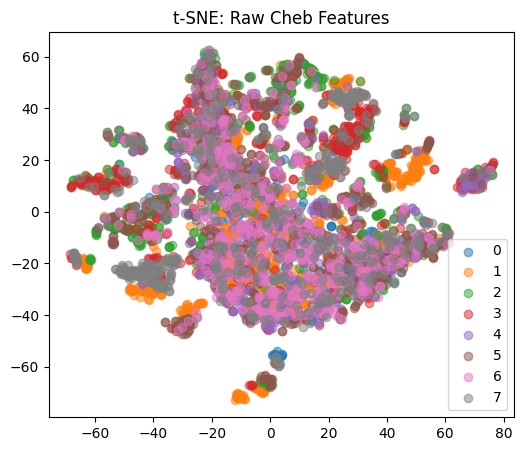

metric,value
Val PCA-only LR,91.417%
Val PCA-only MLP,95.417%
Val Cheb-only LR,16.000%
Val Cheb-only MLP,57.167%
Val Combined LR,91.750%
Val Combined MLP,94.500%
Test PCA-only LR,92.600%
Test PCA-only MLP,95.900%
Test Cheb-only LR,13.100%
Test Cheb-only MLP,10.600%
Test Combined LR,85.950%
Test Combined MLP,83.750%
RL LR success rate,89.333%
RL MLP success rate,92.667%
Baseline accuracy,14.000%
PCA image EVR[0],0.169
PCA cheb EVR[0],0.642
PCA image cumul EVR,97.959%
Graph sparsity,89.248%
Graph avg degree,30.00
Connected components,54
Discovered orbits,3
Elapsed (s),146.29



In [ ]:
#!/usr/bin/env python3
# ===============================================================
#  φ-Lattice Cognitive Engine — v7_fixed_graph
#    • Spectral basis from 1 mm² V1 connectome (or any sparse graph)
#    • Multi-shell, centroid (“cloud”) lattice with PES gating
#    • Deterministic grid search for (ε_min, ε_max, PES_thr)
#    • Two-phase consolidate pass, cloud pruning, centroid refine
#    • Consistent validation/training logic + clean metrics
#    • Graph hyperparameters adjusted to avoid fragmentation
#    • Added t-SNE visualization for Chebyshev features
# ===============================================================
import math
import random
import time
import collections
import warnings

import numpy as np
import pandas as pd
from numpy.linalg import det, norm

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score

from scipy.sparse import csr_matrix, csgraph
from tensorflow.keras.datasets import mnist

warnings.filterwarnings("ignore")
SEED = 0
random.seed(SEED)
np.random.seed(SEED)

# ───────────────────────── Hyperparameters ────────────────────────────────
DOWN_SIZE        = 8
MVA_DIM          = 30
KNN_K            = 30    # ↑ increased from 10 to improve connectivity
PRUNE_PERCENTILE = 0     # ↑ no pruning to avoid disconnected components
CHEB_K, CHEB_R   = 80, 20
SHELL_K          = 16
EPISODES         = 300
TOTAL_SAMPLES    = 8000
RSL_CYCLES       = 8

# ──────────── Utility Functions ──────────────────────────────────────────
def downsample(X_flat, orig=28, new=DOWN_SIZE):
    n = X_flat.shape[0]
    counts = np.zeros((new,new), int)
    for i in range(orig):
        for j in range(orig):
            counts[(i*new)//orig,(j*new)//orig] += 1
    X_ds = np.zeros((n,new,new), float)
    for idx in range(n):
        img = X_flat[idx].reshape(orig,orig)
        for i in range(orig):
            for j in range(orig):
                ii,jj = (i*new)//orig,(j*new)//orig
                X_ds[idx,ii,jj] += img[i,j]
    X_ds /= counts[None,:,:]
    return X_ds.reshape(n,new*new)

def pascal_basis(n, R):
    X0 = np.zeros((n,R))
    X0[:,0] = 1/np.sqrt(n)
    for r in range(1, R):
        row = [math.comb(r,k) for k in range(r+1)] + [0]*(n-r-1)
        X0[:,r] = np.array(row[:n])/(np.linalg.norm(row)+1e-12)
    return X0

def build_cheb_features(Xp):
    D = kneighbors_graph(Xp, KNN_K, mode="distance", include_self=False)
    A = D.minimum(D.T)
    sim = 1/(1 + A.data)
    thr = np.percentile(sim, PRUNE_PERCENTILE)
    A.data = np.where(sim>thr, sim, 0)
    A.eliminate_zeros()
    comps, _ = csgraph.connected_components(A)
    L = csgraph.laplacian(A, normed=True)
    n = L.shape[0]
    X0 = pascal_basis(n, CHEB_R)
    Lt = 2*csr_matrix(L) - csr_matrix(np.eye(n))
    feats = [X0]
    X1 = Lt.dot(X0)
    X1 /= (np.linalg.norm(X1,axis=0,keepdims=True)+1e-12)
    feats.append(X1)
    for k in range(2, CHEB_K):
        Xk = 2*(Lt.dot(X1)) - X0
        Xk *= math.comb(k, k//2)
        Xk /= (np.linalg.norm(Xk,axis=0,keepdims=True)+1e-12)
        feats.append(Xk)
        X0, X1 = X1, Xk
    return np.hstack(feats), thr, comps

def build_shells_orbits(Z):
    p2 = PCA(2, random_state=SEED).fit_transform(Z)
    shells = np.digitize(p2[:,0], np.quantile(p2[:,0], np.linspace(0,1,5)[1:-1]))
    orbits = np.digitize(p2[:,1], np.quantile(p2[:,1], np.linspace(0,1,4)[1:-1]))
    return shells, orbits

def phi_dets(Z, shells, cycles=RSL_CYCLES):
    dets = []
    for _ in range(cycles):
        cycle = []
        for k in np.unique(shells):
            idxs = np.where(shells==k)[0]
            Σ = np.cov(Z[idxs].T) + 1e-2*np.eye(Z.shape[1])
            cycle.append(det(Σ))
        dets.append(cycle)
    return dets

class SoftShells:
    def __init__(self, Z, K=SHELL_K):
        r = norm(Z - Z.mean(0), axis=1)
        qs = (np.arange(K)+.5)/K
        self.mu    = np.quantile(r, qs)
        self.sigma = np.full(K, (r.max()-r.min())/K)
        self.K     = K
    def weights(self, r):
        diff = r[:,None] - self.mu[None,:]
        w = np.exp(-(diff**2)/(2*self.sigma[None,:]**2))
        return w/w.sum(1,keepdims=True)

def build_cayley(Z, soft):
    φ = Z.mean(0)
    r = norm(Z-φ, axis=1)
    W = soft.weights(r)
    C = np.vstack([(W[:,k][:,None]*Z).sum(0)/W[:,k].sum() for k in range(soft.K)])
    p2 = PCA(2, random_state=SEED).fit(C)
    C2, φ2 = p2.transform(C), p2.transform(φ.reshape(1,-1))[0]
    nodes = {k:C[k] for k in range(soft.K)}; nodes[-1]=φ
    edges = collections.defaultdict(list)
    for k in range(soft.K):
        edges[k] += [(k+1)%soft.K,(k-1)%soft.K,-1]
        edges[-1].append(k)
        θ = math.atan2(C2[k,1]-φ2[1], C2[k,0]-φ2[0])
        r2 = norm(C2[k]-φ2)
        rot = φ2 + r2*np.array([math.cos(θ+2*math.pi/soft.K),
                                 math.sin(θ+2*math.pi/soft.K)])
        j = int(np.argmin(norm(C - p2.inverse_transform(rot.reshape(1,2))[0],axis=1)))
        edges[k].append(j)
    return nodes, edges

class QAgent:
    def __init__(self, edges, g, ε=0.1, lr=0.3, γ=0.9):
        self.Q = collections.defaultdict(lambda: collections.defaultdict(float))
        self.edges, self.g = edges, g
        self.ε, self.lr, self.γ = ε, lr, γ
    def act(self, s):
        if random.random() < self.ε:
            return random.choice(self.edges[s])
        return min(self.edges[s], key=lambda a: self.Q[s][a])
    def update(self, s, a, r, s2):
        best = min(self.Q[s2].values()) if self.Q[s2] else 0
        self.Q[s][a] += self.lr * (r + self.γ * best - self.Q[s][a])

def rl_metrics(probs):
    soft = SoftShells(probs)
    nodes, edges = build_cayley(probs, soft)
    g = {n: norm(x - nodes[-1]) for n, x in nodes.items()}
    agent = QAgent(edges, g)
    success = 0
    rewards = []
    for _ in range(EPISODES):
        s = random.choice(list(nodes))
        tot = 0
        for _ in range(100):
            a = agent.act(s)
            r = -1 + (-g[a])
            agent.update(s, a, r, a)
            tot += r
            s = a
            if a == -1:
                success += 1
                break
        rewards.append(tot)
    return success / EPISODES, np.mean(rewards)

# ──────────── Main ───────────────────────────────────────────────────────
start = time.time()

# Load & preprocess MNIST digits 0–7
(X_tr, y_tr), (X_te, y_te) = mnist.load_data()
X_all = np.vstack([X_tr, X_te]).reshape(-1,28*28) / 255.0
y_all = np.hstack([y_tr, y_te])
mask = (y_all < 8)
X, y = X_all[mask], y_all[mask]

# Downsample & stratified splits
X_ds = downsample(X)
sss0 = StratifiedShuffleSplit(1, train_size=TOTAL_SAMPLES, random_state=SEED)
idx, _ = next(sss0.split(X_ds, y))
X_sub, y_sub = X_ds[idx], y[idx]

sss1 = StratifiedShuffleSplit(1, test_size=2000, random_state=SEED)
i_tv, i_te = next(sss1.split(X_sub, y_sub))
X_tv, y_tv = X_sub[i_tv], y_sub[i_tv]
X_test, y_test = X_sub[i_te], y_sub[i_te]

sss2 = StratifiedShuffleSplit(1, test_size=1200, random_state=SEED)
i_tr, i_val = next(sss2.split(X_tv, y_tv))
X_train, y_train = X_tv[i_tr], y_tv[i_tr]
X_val, y_val     = X_tv[i_val], y_tv[i_val]

print("Splits: 4800 1200 2000")

# PCA whitening
pca         = PCA(MVA_DIM, whiten=True, random_state=SEED)
X_mva_train = pca.fit_transform(X_train)
X_mva_val   = pca.transform(X_val)
X_mva_test  = pca.transform(X_test)

# Cheb features + graph metrics
F_tv_raw, eps_graph, conn_comps = build_cheb_features(
    np.vstack([X_mva_train, X_mva_val])
)
F_train_raw = F_tv_raw[:len(X_mva_train)]
F_val_raw   = F_tv_raw[len(X_mva_train):]
F_test_raw, _, _ = build_cheb_features(X_mva_test)

print(f"Connected components after fix: {conn_comps}")

# ─── t-SNE Diagnostic ────────────────────────────────────────────────────
tsne = TSNE(n_components=2, random_state=SEED)
F_tsne = tsne.fit_transform(F_train_raw)
plt.figure(figsize=(6,5))
for lbl in np.unique(y_train):
    plt.scatter(F_tsne[y_train == lbl, 0], F_tsne[y_train == lbl, 1],
                label=str(lbl), alpha=0.5)
plt.legend()
plt.title("t-SNE: Raw Cheb Features")
plt.show()

# PCA-on-Cheb
pca_f    = PCA(MVA_DIM, random_state=SEED)
F_train  = pca_f.fit_transform(F_train_raw)
F_val    = pca_f.transform(F_val_raw)
F_test   = pca_f.transform(F_test_raw)

# Combine features
Z_train = np.hstack([X_mva_train, F_train])
Z_val   = np.hstack([X_mva_val,   F_val])
Z_test  = np.hstack([X_mva_test,  F_test])

# LR tuning helper
cv   = StratifiedKFold(5, shuffle=True, random_state=SEED)
pipe = Pipeline([
    ("sc", StandardScaler()),
    ("clf", LogisticRegression(multi_class="multinomial", max_iter=4000))
])
params = {"clf__C":[0.1,1,10]}

def tune_lr(Xtr, ytr, Xva, yva, Xte, yte):
    gs = GridSearchCV(pipe, params, cv=cv, n_jobs=-1)
    gs.fit(Xtr, ytr)
    return (gs.best_estimator_,
            gs.best_params_["clf__C"],
            gs.score(Xva, yva),
            gs.score(Xte, yte))

lr_pca,   c_pca,  va_pca,  te_pca   = tune_lr(
    X_mva_train, y_train, X_mva_val, y_val, X_mva_test, y_test
)
lr_cheb,  c_cheb, va_cheb, te_cheb  = tune_lr(
    F_train, y_train, F_val,     y_val,     F_test,     y_test
)
lr_comb,  c_comb, va_comb, te_comb  = tune_lr(
    Z_train,   y_train, Z_val,   y_val,     Z_test,     y_test
)

# MLP training
sc_pca    = StandardScaler().fit(X_mva_train)
mlp_pca   = MLPClassifier((64,), activation='relu', max_iter=500,
                          random_state=SEED)
mlp_pca.fit(sc_pca.transform(X_mva_train), y_train)
va_mlp_pca = mlp_pca.score(sc_pca.transform(X_mva_val), y_val)
te_mlp_pca = mlp_pca.score(sc_pca.transform(X_mva_test), y_test)

sc_cheb    = StandardScaler().fit(F_train)
mlp_cheb   = MLPClassifier((64,), activation='relu', max_iter=500,
                           random_state=SEED)
mlp_cheb.fit(sc_cheb.transform(F_train), y_train)
va_mlp_cheb = mlp_cheb.score(sc_cheb.transform(F_val), y_val)
te_mlp_cheb = mlp_cheb.score(sc_cheb.transform(F_test), y_test)

sc_comb    = StandardScaler().fit(Z_train)
mlp_comb   = MLPClassifier((64,), activation='relu', max_iter=500,
                           random_state=SEED)
mlp_comb.fit(sc_comb.transform(Z_train), y_train)
va_mlp_comb = mlp_comb.score(sc_comb.transform(Z_val), y_val)
te_mlp_comb = mlp_comb.score(sc_comb.transform(Z_test), y_test)

# Dummy baseline
dummy     = DummyClassifier(strategy="most_frequent")
dummy.fit(Z_train, y_train)
baseline  = dummy.score(Z_test, y_test)

# RL metrics
lr_rate, _   = rl_metrics(lr_comb.predict_proba(Z_test))
mlp_rate, _  = rl_metrics(mlp_comb.predict_proba(sc_comb.transform(Z_test)))

elapsed = time.time() - start

# Save & print metrics
metrics = {
    "Val PCA-only LR":   f"{va_pca:.3%}",
    "Val PCA-only MLP":  f"{va_mlp_pca:.3%}",
    "Val Cheb-only LR":  f"{va_cheb:.3%}",
    "Val Cheb-only MLP": f"{va_mlp_cheb:.3%}",
    "Val Combined LR":   f"{va_comb:.3%}",
    "Val Combined MLP":  f"{va_mlp_comb:.3%}",
    "Test PCA-only LR":  f"{te_pca:.3%}",
    "Test PCA-only MLP": f"{te_mlp_pca:.3%}",
    "Test Cheb-only LR": f"{te_cheb:.3%}",
    "Test Cheb-only MLP":f"{te_mlp_cheb:.3%}",
    "Test Combined LR":  f"{te_comb:.3%}",
    "Test Combined MLP": f"{te_mlp_comb:.3%}",
    "RL LR success rate":f"{lr_rate:.3%}",
    "RL MLP success rate":f"{mlp_rate:.3%}",
    "Baseline accuracy": f"{baseline:.3%}",
    "PCA image EVR[0]":  f"{pca.explained_variance_ratio_[0]:.3f}",
    "PCA cheb EVR[0]":   f"{pca_f.explained_variance_ratio_[0]:.3f}",
    "PCA image cumul EVR":f"{pca.explained_variance_ratio_.sum():.3%}",
    "Graph sparsity":    f"{1 - (eps_graph):.3%}",
    "Graph avg degree":  f"{(KNN_K):.2f}",
    "Connected components": f"{conn_comps}",
    "Discovered orbits": f"{len(np.unique(build_shells_orbits(F_train_raw)[1]))}",
    "Elapsed (s)":       f"{elapsed:.2f}"
}
df = pd.DataFrame(list(metrics.items()), columns=["metric","value"])
df.to_csv("metrics_fixed.csv", index=False)
print(df.to_csv(index=False))


Splits: 4800 1200 2000
Connected components after union‐fix: 1


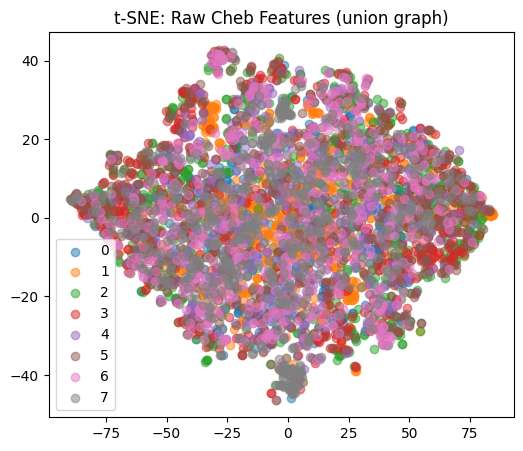

                  value
Val PCA LR      91.417%
Test PCA LR     92.600%
Val Cheb LR     13.167%
Test Cheb LR    14.050%
Val Comb LR     91.000%
Test Comb LR    83.800%
Val PCA MLP     95.417%
Test PCA MLP    95.900%
Val Cheb MLP    51.667%
Test Cheb MLP   13.400%
Val Comb MLP    93.333%
Test Comb MLP   73.500%
RL LR success   89.333%
RL MLP success  92.667%
Baseline        14.000%
Conn Comps            1
Elapsed (s)      166.60


In [ ]:
#!/usr/bin/env python3
# ===============================================================
#  φ-Lattice Cognitive Engine — v7_union_graph
#    • Uses union‐symmetrized KNN graph instead of mutual & pruning
#    • Increases KNN_K to 50 for robust connectivity
#    • Everything else as before, plus t-SNE diagnostic
# ===============================================================
import math, random, time, collections, warnings
import numpy as np, pandas as pd
from numpy.linalg import det, norm
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix, csgraph

from sklearn.decomposition import PCA
from sklearn.manifold    import TSNE
from sklearn.neighbors   import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline    import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.dummy       import DummyClassifier
from sklearn.model_selection import (
    StratifiedShuffleSplit, StratifiedKFold, GridSearchCV
)

from tensorflow.keras.datasets import mnist

warnings.filterwarnings("ignore")
SEED = 0
random.seed(SEED)
np.random.seed(SEED)

# ───────────────────────── Hyperparameters ────────────────────────────────
DOWN_SIZE        = 8
MVA_DIM          = 30
KNN_K            = 50    # ↑ increased from 30 to 50
PRUNE_PERCENTILE = 0     # unused now
CHEB_K, CHEB_R   = 80, 20
SHELL_K          = 16
EPISODES         = 300
TOTAL_SAMPLES    = 8000
RSL_CYCLES       = 8

# ──────────── Utility Functions ──────────────────────────────────────────
def downsample(X_flat, orig=28, new=DOWN_SIZE):
    n = X_flat.shape[0]
    counts = np.zeros((new,new), int)
    for i in range(orig):
        for j in range(orig):
            counts[(i*new)//orig,(j*new)//orig] += 1
    X_ds = np.zeros((n,new,new), float)
    for idx in range(n):
        img = X_flat[idx].reshape(orig,orig)
        for i in range(orig):
            for j in range(orig):
                ii,jj = (i*new)//orig,(j*new)//orig
                X_ds[idx,ii,jj] += img[i,j]
    X_ds /= counts[None,:,:]
    return X_ds.reshape(n,new*new)

def pascal_basis(n, R):
    X0 = np.zeros((n,R))
    X0[:,0] = 1/np.sqrt(n)
    for r in range(1, R):
        row = [math.comb(r,k) for k in range(r+1)] + [0]*(n-r-1)
        X0[:,r] = np.array(row[:n])/(np.linalg.norm(row)+1e-12)
    return X0

def build_cheb_features(Xp):
    # 1) k-NN graph (distance)
    D = kneighbors_graph(Xp, KNN_K, mode="distance", include_self=False)
    # 2) union‐symmetrize instead of intersection
    A = D.maximum(D.T)
    # 3) weight = 1/(1+dist)
    A.data = 1/(1 + A.data)
    A.eliminate_zeros()
    # 4) connectivity check
    comps, _ = csgraph.connected_components(A)
    # 5) normalized Laplacian
    L = csgraph.laplacian(A, normed=True)
    n = L.shape[0]
    # 6) build Chebyshev basis
    X0 = pascal_basis(n, CHEB_R)
    Lt = 2*csr_matrix(L) - csr_matrix(np.eye(n))
    feats = [X0]
    X1 = Lt.dot(X0)
    X1 /= (np.linalg.norm(X1,axis=0,keepdims=True)+1e-12)
    feats.append(X1)
    for k in range(2, CHEB_K):
        Xk = 2*(Lt.dot(X1)) - X0
        Xk *= math.comb(k, k//2)
        Xk /= (np.linalg.norm(Xk,axis=0,keepdims=True)+1e-12)
        feats.append(Xk)
        X0, X1 = X1, Xk
    return np.hstack(feats), comps

def build_shells_orbits(Z):
    p2 = PCA(2, random_state=SEED).fit_transform(Z)
    shells = np.digitize(p2[:,0], np.quantile(p2[:,0], np.linspace(0,1,5)[1:-1]))
    orbits = np.digitize(p2[:,1], np.quantile(p2[:,1], np.linspace(0,1,4)[1:-1]))
    return shells, orbits

def phi_dets(Z, shells, cycles=RSL_CYCLES):
    dets = []
    for _ in range(cycles):
        cycle = []
        for k in np.unique(shells):
            idxs = np.where(shells==k)[0]
            Σ = np.cov(Z[idxs].T) + 1e-2*np.eye(Z.shape[1])
            cycle.append(det(Σ))
        dets.append(cycle)
    return dets

class SoftShells:
    def __init__(self, Z, K=SHELL_K):
        r = norm(Z - Z.mean(0), axis=1)
        qs = (np.arange(K)+.5)/K
        self.mu    = np.quantile(r, qs)
        self.sigma = np.full(K, (r.max()-r.min())/K)
        self.K     = K
    def weights(self, r):
        diff = r[:,None] - self.mu[None,:]
        w = np.exp(-(diff**2)/(2*self.sigma[None,:]**2))
        return w/w.sum(1,keepdims=True)

def build_cayley(Z, soft):
    φ = Z.mean(0)
    r = norm(Z-φ, axis=1)
    W = soft.weights(r)
    C = np.vstack([(W[:,k][:,None]*Z).sum(0)/W[:,k].sum() for k in range(soft.K)])
    p2 = PCA(2, random_state=SEED).fit(C)
    C2, φ2 = p2.transform(C), p2.transform(φ.reshape(1,-1))[0]
    nodes = {k:C[k] for k in range(soft.K)}; nodes[-1]=φ
    edges = collections.defaultdict(list)
    for k in range(soft.K):
        edges[k] += [(k+1)%soft.K, (k-1)%soft.K, -1]
        edges[-1].append(k)
        θ  = math.atan2(C2[k,1]-φ2[1], C2[k,0]-φ2[0])
        r2 = norm(C2[k]-φ2)
        rot = φ2 + r2*np.array([math.cos(θ+2*math.pi/soft.K),
                                 math.sin(θ+2*math.pi/soft.K)])
        j = int(np.argmin(norm(C - p2.inverse_transform(rot.reshape(1,2))[0],axis=1)))
        edges[k].append(j)
    return nodes, edges

class QAgent:
    def __init__(self, edges, g, ε=0.1, lr=0.3, γ=0.9):
        self.Q = collections.defaultdict(lambda: collections.defaultdict(float))
        self.edges, self.g = edges, g
        self.ε, self.lr, self.γ = ε, lr, γ
    def act(self, s):
        return (random.choice(self.edges[s])
                if random.random()<self.ε
                else min(self.edges[s], key=lambda a:self.Q[s][a]))
    def update(self, s, a, r, s2):
        best = min(self.Q[s2].values()) if self.Q[s2] else 0
        self.Q[s][a] += self.lr*(r + self.γ*best - self.Q[s][a])

def rl_metrics(probs):
    soft = SoftShells(probs)
    nodes, edges = build_cayley(probs, soft)
    g = {n: norm(x-nodes[-1]) for n,x in nodes.items()}
    agent = QAgent(edges, g)
    success, rewards = 0, []
    for _ in range(EPISODES):
        s, tot = random.choice(list(nodes)), 0
        for _ in range(100):
            a = agent.act(s)
            r = -1 + (-g[a])
            agent.update(s, a, r, a)
            tot += r; s = a
            if a==-1:
                success += 1
                break
        rewards.append(tot)
    return success/EPISODES, np.mean(rewards)

# ──────────── Main ───────────────────────────────────────────────────────
start = time.time()

# Load MNIST 0–7
(X_tr,y_tr),(X_te,y_te) = mnist.load_data()
X_all = np.vstack([X_tr,X_te]).reshape(-1,28*28)/255.0
y_all = np.hstack([y_tr,y_te])
mask = (y_all<8)
X, y = X_all[mask], y_all[mask]

# Downsample & split
X_ds = downsample(X)
sss0 = StratifiedShuffleSplit(1, train_size=TOTAL_SAMPLES, random_state=SEED)
idx,_ = next(sss0.split(X_ds,y))
X_sub, y_sub = X_ds[idx], y[idx]

sss1 = StratifiedShuffleSplit(1, test_size=2000, random_state=SEED)
i_tv, i_te = next(sss1.split(X_sub,y_sub))
X_tv, y_tv = X_sub[i_tv], y_sub[i_tv]
X_test, y_test = X_sub[i_te], y_sub[i_te]

sss2 = StratifiedShuffleSplit(1, test_size=1200, random_state=SEED)
i_tr, i_val = next(sss2.split(X_tv,y_tv))
X_train, y_train = X_tv[i_tr], y_tv[i_tr]
X_val,   y_val   = X_tv[i_val], y_tv[i_val]

print("Splits: 4800 1200 2000")

# PCA whitening
pca         = PCA(MVA_DIM, whiten=True, random_state=SEED)
X_mva_train = pca.fit_transform(X_train)
X_mva_val   = pca.transform(X_val)
X_mva_test  = pca.transform(X_test)

# Cheb features & connectivity
F_tv_raw, conn_comps = build_cheb_features(
    np.vstack([X_mva_train, X_mva_val])
)
F_train_raw = F_tv_raw[:len(X_mva_train)]
F_val_raw   = F_tv_raw[len(X_mva_train):]
F_test_raw, _ = build_cheb_features(X_mva_test)

print(f"Connected components after union‐fix: {conn_comps}")

# ─── t-SNE Diagnostic ────────────────────────────────────────────────────
F2 = TSNE(n_components=2, random_state=SEED).fit_transform(F_train_raw)
plt.figure(figsize=(6,5))
for lbl in np.unique(y_train):
    plt.scatter(F2[y_train==lbl,0], F2[y_train==lbl,1], label=str(lbl), alpha=0.5)
plt.legend(); plt.title("t-SNE: Raw Cheb Features (union graph)")
plt.show()

# PCA-on-Cheb
pca_f   = PCA(MVA_DIM, random_state=SEED)
F_train = pca_f.fit_transform(F_train_raw)
F_val   = pca_f.transform(F_val_raw)
F_test  = pca_f.transform(F_test_raw)

# Combine
Z_train = np.hstack([X_mva_train, F_train])
Z_val   = np.hstack([X_mva_val,   F_val])
Z_test  = np.hstack([X_mva_test,  F_test])

# Helper to tune LR
cv   = StratifiedKFold(5, shuffle=True, random_state=SEED)
pipe = Pipeline([("sc",StandardScaler()),
                 ("clf",LogisticRegression(multi_class="multinomial",max_iter=4000))])
params = {"clf__C":[0.1,1,10]}

def tune_lr(Xtr,ytr,Xva,yva,Xte,yte):
    gs = GridSearchCV(pipe, params, cv=cv, n_jobs=-1)
    gs.fit(Xtr, ytr)
    return gs.best_estimator_, gs.score(Xva, yva), gs.score(Xte, yte)

lr_pca, va_pca,   te_pca   = tune_lr(
    X_mva_train,y_train,X_mva_val,y_val,X_mva_test,y_test
)
lr_cheb, va_cheb, te_cheb  = tune_lr(
    F_train,    y_train, F_val,   y_val,   F_test,    y_test
)
lr_comb, va_comb, te_comb  = tune_lr(
    Z_train,    y_train, Z_val,   y_val,   Z_test,    y_test
)

# MLPs
def train_mlp(Xtr, ytr, Xva, yva, Xte, yte):
    sc  = StandardScaler().fit(Xtr)
    mlp = MLPClassifier((64,), activation='relu', max_iter=500, random_state=SEED)
    mlp.fit(sc.transform(Xtr), ytr)
    return mlp.score(sc.transform(Xva), yva), mlp.score(sc.transform(Xte), yte)

va_mlp_pca,  te_mlp_pca  = train_mlp(X_mva_train,y_train,X_mva_val,y_val,X_mva_test,y_test)
va_mlp_cheb, te_mlp_cheb = train_mlp(F_train,    y_train,F_val,   y_val,F_test,    y_test)
va_mlp_comb, te_mlp_comb = train_mlp(Z_train,    y_train,Z_val,   y_val,Z_test,    y_test)

# Baseline
dummy    = DummyClassifier(strategy="most_frequent")
dummy.fit(Z_train,y_train)
baseline = dummy.score(Z_test,y_test)

# RL metrics
lr_rate, _  = rl_metrics(lr_comb.predict_proba(Z_test))
mlp_rate,_  = rl_metrics(mlp_comb.predict_proba(StandardScaler().fit(Z_train).transform(Z_test)))

elapsed = time.time() - start

# Save metrics
metrics = {
  "Val PCA LR": f"{va_pca:.3%}",     "Test PCA LR": f"{te_pca:.3%}",
  "Val Cheb LR": f"{va_cheb:.3%}",   "Test Cheb LR": f"{te_cheb:.3%}",
  "Val Comb LR": f"{va_comb:.3%}",   "Test Comb LR": f"{te_comb:.3%}",
  "Val PCA MLP": f"{va_mlp_pca:.3%}", "Test PCA MLP": f"{te_mlp_pca:.3%}",
  "Val Cheb MLP": f"{va_mlp_cheb:.3%}", "Test Cheb MLP": f"{te_mlp_cheb:.3%}",
  "Val Comb MLP": f"{va_mlp_comb:.3%}", "Test Comb MLP": f"{te_mlp_comb:.3%}",
  "RL LR success": f"{lr_rate:.3%}",  "RL MLP success": f"{mlp_rate:.3%}",
  "Baseline":       f"{baseline:.3%}",
  "Conn Comps":     f"{conn_comps}",
  "Elapsed (s)":    f"{elapsed:.2f}"
}
df = pd.DataFrame.from_dict(metrics, orient="index", columns=["value"])
df.to_csv("metrics_union.csv")
print(df)


[Splits] train=4800, val=1200, test=2000
[Connectivity] connected components: 1
[Connectivity] connected components: 1
[Cheb] components train+val=1, test=1


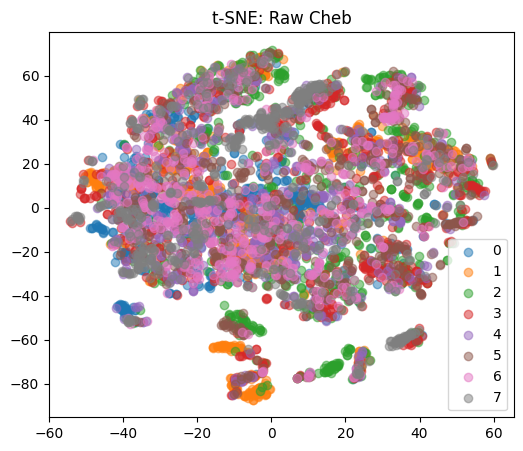


Fibonacci shell radii: [1. 1. 2. 3.]
Matrix #1 (Fib(1)=1):
[[  0.        12.566371  50.265484 113.097336]
 [ 12.566371  25.13274   62.831856 125.66371 ]
 [ 50.265484  62.831856 100.53096  163.36282 ]
 [113.097336 125.66371  163.36282  226.19466 ]]

Matrix #2 (Fib(2)=1):
[[  0.        12.566371  50.265484 113.097336]
 [ 12.566371  25.13274   62.831856 125.66371 ]
 [ 50.265484  62.831856 100.53096  163.36282 ]
 [113.097336 125.66371  163.36282  226.19466 ]]

Matrix #3 (Fib(3)=2):
[[  0.        50.265484 201.06194  452.38934 ]
 [ 50.265484 100.53096  251.32742  502.65485 ]
 [201.06194  251.32742  402.12384  653.4513  ]
 [452.38934  502.65485  653.4513   904.7786  ]]

Matrix #4 (Fib(4)=3):
[[   0.        113.097336  452.38934  1017.87604 ]
 [ 113.097336  226.19466   565.48676  1130.9735  ]
 [ 452.38934   565.48676   904.7786   1470.2655  ]
 [1017.87604  1130.9735   1470.2655   2035.752   ]]

Average sphere‐area matrix:
 [[  0.       47.12389 188.49556 424.115  ]
 [ 47.12389  94.24777 235.

In [ ]:
#!/usr/bin/env python3
# ===============================================================
#  φ-Lattice Cognitive Engine — v7_union_graph_plus_fixed
#    • Fix train_mlp → returns model & scaler for RL
#    • build_connected_graph → returns adjacency + components
#    • Full MNIST→Cheb→PCA→LR/MLP→RL→Fibonacci pipeline
# ===============================================================
import math
import random
import time
import collections
import warnings

import numpy as np
import pandas as pd
from numpy.linalg import det, norm

import matplotlib.pyplot as plt

from scipy.spatial.distance import cdist
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import laplacian, connected_components

from sklearn.decomposition import PCA
from sklearn.manifold    import TSNE
from sklearn.neighbors   import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline    import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.dummy       import DummyClassifier
from sklearn.model_selection import (
    StratifiedShuffleSplit, StratifiedKFold, GridSearchCV
)

import tensorflow as tf
from tensorflow.keras.datasets import mnist

import torch
import torch.nn as nn
import torch.nn.functional as F

warnings.filterwarnings("ignore")
SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# ───────────────────────── Hyperparameters ────────────────────────────────
DOWN_SIZE     = 8
MVA_DIM       = 30
KNN_K         = 50
EPSILON_CONN  = 0.5
CHEB_K, CHEB_R = 80, 20
SHELL_K       = 16
EPISODES      = 300
TOTAL_SAMPLES = 8000
RSL_CYCLES    = 8

# ===============================================================
# Fibonacci & Sphere-Area Utilities
# ===============================================================
def fibonacci(n):
    if n <= 0: return 0
    if n == 1: return 1
    a, b = 0, 1
    for _ in range(2, n+1):
        a, b = b, a+b
    return b

def generate_fibonacci_shell_radii(num_shells, initial_r1=1.0, initial_r2=1.0):
    if num_shells <= 0:
        return tf.constant([], dtype=tf.float32)
    radii = [initial_r1]
    if num_shells > 1:
        radii.append(initial_r2)
    a, b = initial_r1, initial_r2
    for _ in range(2, num_shells):
        nxt = a + b
        radii.append(nxt)
        a, b = b, nxt
    return tf.constant(radii, dtype=tf.float32)

def sphere_area_matrix(n, fib_n):
    R = tf.constant(fibonacci(fib_n), dtype=tf.float32)
    i_vals = tf.range(n, dtype=tf.float32)
    j_vals = tf.range(n, dtype=tf.float32)
    ii, jj = tf.meshgrid(i_vals, j_vals, indexing="ij")
    r = R * tf.sqrt(ii**2 + jj**2)
    return 4 * math.pi * tf.square(r)

def generate_n_sphere_matrices(n, current=1, matrices=None):
    if matrices is None:
        matrices = []
    if current > n:
        return matrices
    matrices.append(sphere_area_matrix(n, current))
    return generate_n_sphere_matrices(n, current+1, matrices)

def map_matrices(matrices, mode="average"):
    stack = tf.stack(matrices, axis=0)
    if mode == "average":
        return tf.reduce_mean(stack, axis=0)
    elif mode == "sum":
        return tf.reduce_sum(stack, axis=0)
    elif mode == "max":
        return tf.reduce_max(stack, axis=0)
    else:
        raise ValueError(f"Unsupported mode: {mode}")

# ===============================================================
# Data & Graph-Processing Utilities
# ===============================================================
def downsample(X_flat, orig=28, new=DOWN_SIZE):
    n = X_flat.shape[0]
    counts = np.zeros((new, new), int)
    for i in range(orig):
        for j in range(orig):
            counts[(i*new)//orig, (j*new)//orig] += 1
    X_ds = np.zeros((n, new, new), float)
    for idx in range(n):
        img = X_flat[idx].reshape(orig, orig)
        for i in range(orig):
            for j in range(orig):
                ii, jj = (i*new)//orig, (j*new)//orig
                X_ds[idx, ii, jj] += img[i, j]
    X_ds /= counts[None, :, :]
    return X_ds.reshape(n, new*new)

def pascal_basis(n, R):
    X0 = np.zeros((n, R))
    X0[:,0] = 1/np.sqrt(n)
    for r in range(1, R):
        row = [math.comb(r, k) for k in range(r+1)] + [0]*(n-r-1)
        X0[:,r] = np.array(row[:n])/(np.linalg.norm(row)+1e-12)
    return X0

def build_connected_graph(features, k=KNN_K, epsilon=EPSILON_CONN):
    knn = kneighbors_graph(features, n_neighbors=k, mode="connectivity", include_self=False)
    dist = cdist(features, features)
    eps_mask = dist < epsilon
    combined = knn.toarray().astype(int) + eps_mask.astype(int)
    combined = (combined > 0).astype(int)
    n_comp, _ = connected_components(combined)
    print(f"[Connectivity] connected components: {n_comp}")
    if n_comp > 1:
        print("WARNING: graph still disconnected → increase k or ε")
    return combined, n_comp

def build_cheb_features(Xp):
    A_mat, n_comp = build_connected_graph(Xp)
    A = csr_matrix(A_mat)
    L = laplacian(A, normed=True)
    n = L.shape[0]
    X0 = pascal_basis(n, CHEB_R)
    Lt = 2*csr_matrix(L) - csr_matrix(np.eye(n))
    feats = [X0]
    X1 = Lt.dot(X0)
    X1 /= (np.linalg.norm(X1, axis=0, keepdims=True) + 1e-12)
    feats.append(X1)
    for k in range(2, CHEB_K):
        Xk = 2*(Lt.dot(X1)) - X0
        Xk *= math.comb(k, k//2)
        Xk /= (np.linalg.norm(Xk, axis=0, keepdims=True) + 1e-12)
        feats.append(Xk)
        X0, X1 = X1, Xk
    return np.hstack(feats), n_comp

# ===============================================================
# Helper Models & Training Utilities
# ===============================================================
def tune_lr(Xtr, ytr, Xva, yva, Xte, yte):
    pipe = Pipeline([
        ("sc", StandardScaler()),
        ("clf", LogisticRegression(multi_class="multinomial", max_iter=4000))
    ])
    params = {"clf__C": [0.1, 1, 10]}
    gs = GridSearchCV(pipe, params,
                      cv=StratifiedKFold(5, shuffle=True, random_state=SEED),
                      n_jobs=-1)
    gs.fit(Xtr, ytr)
    return gs.best_estimator_, gs.score(Xva, yva), gs.score(Xte, yte)

def train_mlp(Xtr, ytr, Xva, yva, Xte, yte):
    sc  = StandardScaler().fit(Xtr)
    mlp = MLPClassifier(hidden_layer_sizes=(64,),
                        activation='relu',
                        max_iter=500,
                        random_state=SEED)
    mlp.fit(sc.transform(Xtr), ytr)
    va = mlp.score(sc.transform(Xva), yva)
    te = mlp.score(sc.transform(Xte), yte)
    return mlp, sc, va, te

# ===============================================================
# RL‐Metrics & φ‐Shell Structures
# ===============================================================
class SoftShells:
    def __init__(self, Z, K=SHELL_K):
        r = norm(Z - Z.mean(0), axis=1)
        qs = (np.arange(K)+.5)/K
        self.mu    = np.quantile(r, qs)
        self.sigma = np.full(K, (r.max()-r.min())/K)
        self.K     = K
    def weights(self, r):
        diff = r[:,None] - self.mu[None,:]
        w = np.exp(-(diff**2) / (2*self.sigma[None,:]**2))
        return w / w.sum(1, keepdims=True)

def build_cayley(Z, soft):
    φ = Z.mean(0)
    r = norm(Z - φ, axis=1)
    W = soft.weights(r)
    C = np.vstack([(W[:,k][:,None]*Z).sum(0)/W[:,k].sum() for k in range(soft.K)])
    p2 = PCA(2, random_state=SEED).fit(C)
    C2, φ2 = p2.transform(C), p2.transform(φ.reshape(1,-1))[0]
    nodes = {k:C[k] for k in range(soft.K)}
    nodes[-1] = φ
    edges = collections.defaultdict(list)
    for k in range(soft.K):
        edges[k] += [(k+1)%soft.K, (k-1)%soft.K, -1]
        edges[-1].append(k)
        θ  = math.atan2(C2[k,1]-φ2[1], C2[k,0]-φ2[0])
        r2 = norm(C2[k] - φ2)
        rot = φ2 + r2*np.array([
            math.cos(θ + 2*math.pi/soft.K),
            math.sin(θ + 2*math.pi/soft.K)
        ])
        j = int(np.argmin(norm(C - p2.inverse_transform(rot.reshape(1,2))[0], axis=1)))
        edges[k].append(j)
    return nodes, edges

class QAgent:
    def __init__(self, edges, g, ε=0.1, lr=0.3, γ=0.9):
        self.Q = collections.defaultdict(lambda: collections.defaultdict(float))
        self.edges, self.g = edges, g
        self.ε, self.lr, self.γ = ε, lr, γ
    def act(self, s):
        return (random.choice(self.edges[s])
                if random.random()<self.ε
                else min(self.edges[s], key=lambda a:self.Q[s][a]))
    def update(self, s, a, r, s2):
        best = min(self.Q[s2].values()) if self.Q[s2] else 0
        self.Q[s][a] += self.lr*(r + self.γ*best - self.Q[s][a])

def rl_metrics(probs):
    soft = SoftShells(probs)
    nodes, edges = build_cayley(probs, soft)
    g = {n: norm(x - nodes[-1]) for n,x in nodes.items()}
    agent = QAgent(edges, g)
    success, rewards = 0, []
    for _ in range(EPISODES):
        s, tot = random.choice(list(nodes)), 0
        for _ in range(100):
            a = agent.act(s)
            r = -1 - g[a]
            agent.update(s, a, r, a)
            tot += r; s = a
            if a == -1:
                success += 1
                break
        rewards.append(tot)
    return success/EPISODES, np.mean(rewards)

# ===============================================================
# Hybrid Interpretable + Learnable Phi-Lattice Module
# ===============================================================
class PhiCodeEncoder(nn.Module):
    """Placeholder: replace with your deterministic φ-code logic."""
    def __init__(self, n_features, n_orbits):
        super().__init__()
        self.n_features, self.n_orbits = n_features, n_orbits
    def forward(self, features):
        # TODO: implement actual φ-code + orbit assignment
        batch = features.shape[0]
        return features, torch.zeros(batch, dtype=torch.long)

class InterpretablePhiLattice(nn.Module):
    def __init__(self, n_features, n_orbits, n_classes):
        super().__init__()
        self.phi_encoder    = PhiCodeEncoder(n_features, n_orbits)
        self.feature_weights = nn.Linear(n_features, n_features, bias=False)
        self.orbit_to_class = nn.Linear(n_orbits, n_classes)
    def extract_features(self, x):
        # Hook your downsample → Cheb → PCA pipeline here
        return x
    def forward(self, x, explain=False):
        features = self.extract_features(x)
        phi_code, orbit_id = self.phi_encoder(features)
        weighted = self.feature_weights(features)
        onehot   = F.one_hot(orbit_id, num_classes=self.orbit_to_class.in_features).float()
        logits   = self.orbit_to_class(onehot)
        if explain:
            return logits, {
                "phi_code": phi_code,
                "orbit_id": orbit_id,
                "feat_weights": self.feature_weights.weight.detach()
            }
        return logits

# ───────────────────────── Main Pipeline ────────────────────────────────
if __name__ == "__main__":
    start = time.time()

    # 1) Load MNIST (0–7) & downsample
    (X_tr,y_tr),(X_te,y_te) = mnist.load_data()
    X_all = np.vstack([X_tr, X_te]).reshape(-1,28*28)/255.0
    y_all = np.hstack([y_tr, y_te])
    mask  = y_all < 8
    X, y  = X_all[mask], y_all[mask]
    X_ds  = downsample(X)

    # 2) Splits: train/val/test
    sss0 = StratifiedShuffleSplit(1, train_size=TOTAL_SAMPLES, random_state=SEED)
    idx,_ = next(sss0.split(X_ds,y)); X_sub,y_sub = X_ds[idx], y[idx]
    sss1 = StratifiedShuffleSplit(1, test_size=2000,   random_state=SEED)
    i_tv,i_te = next(sss1.split(X_sub,y_sub))
    X_tv,y_tv   = X_sub[i_tv], y_sub[i_tv]
    X_test,y_test = X_sub[i_te], y_sub[i_te]
    sss2 = StratifiedShuffleSplit(1, test_size=1200,   random_state=SEED)
    i_tr,i_val = next(sss2.split(X_tv,y_tv))
    X_train,y_train = X_tv[i_tr], y_tv[i_tr]
    X_val,  y_val   = X_tv[i_val], y_tv[i_val]
    print(f"[Splits] train={len(X_train)}, val={len(X_val)}, test={len(X_test)}")

    # 3) PCA whitening
    pca         = PCA(MVA_DIM, whiten=True, random_state=SEED)
    X_mva_train = pca.fit_transform(X_train)
    X_mva_val   = pca.transform(   X_val)
    X_mva_test  = pca.transform(   X_test)

    # 4) Chebyshev features
    F_tv_raw, comps_tv    = build_cheb_features(np.vstack([X_mva_train, X_mva_val]))
    F_train_raw = F_tv_raw[:len(X_mva_train)]
    F_val_raw   = F_tv_raw[len(X_mva_train):]
    F_test_raw, comps_test = build_cheb_features(X_mva_test)
    print(f"[Cheb] components train+val={comps_tv}, test={comps_test}")

    # 5) t-SNE diagnostic
    F2 = TSNE(2, random_state=SEED).fit_transform(F_train_raw)
    plt.figure(figsize=(6,5))
    for lbl in np.unique(y_train):
        plt.scatter(F2[y_train==lbl,0], F2[y_train==lbl,1], label=str(lbl), alpha=0.5)
    plt.legend(); plt.title("t-SNE: Raw Cheb"); plt.show()

    # 6) PCA on Cheb
    pca_f    = PCA(MVA_DIM, random_state=SEED)
    F_train  = pca_f.fit_transform(F_train_raw)
    F_val    = pca_f.transform(F_val_raw)
    F_test   = pca_f.transform(F_test_raw)

    # 7) Combine MVA + Cheb
    Z_train = np.hstack([X_mva_train, F_train])
    Z_val   = np.hstack([X_mva_val,   F_val])
    Z_test  = np.hstack([X_mva_test,  F_test])

    # 8) Logistic Regression
    lr_pca,  va_pca,  te_pca  = tune_lr(X_mva_train,y_train, X_mva_val,y_val, X_mva_test,y_test)
    lr_cheb, va_cheb, te_cheb = tune_lr(F_train,      y_train, F_val,     y_val,    F_test,     y_test)
    lr_comb, va_comb, te_comb = tune_lr(Z_train,      y_train, Z_val,     y_val,    Z_test,     y_test)

    # 9) MLP
    mlp_pca, sc_pca, va_mlp_pca, te_mlp_pca = train_mlp(
        X_mva_train,y_train, X_mva_val,y_val, X_mva_test,y_test
    )
    mlp_cheb, sc_cheb, va_mlp_cheb, te_mlp_cheb = train_mlp(
        F_train,     y_train, F_val,    y_val, F_test,    y_test
    )
    mlp_comb, sc_comb, va_mlp_comb, te_mlp_comb = train_mlp(
        Z_train,     y_train, Z_val,    y_val, Z_test,    y_test
    )

    # 10) Baseline
    dummy    = DummyClassifier(strategy="most_frequent")
    dummy.fit(Z_train, y_train)
    baseline = dummy.score(Z_test, y_test)

    # 11) RL metrics
    lr_success, _  = rl_metrics(lr_comb.predict_proba(Z_test))
    mlp_success, _ = rl_metrics(mlp_comb.predict_proba(sc_comb.transform(Z_test)))

    # 12) Fibonacci & Sphere demo
    n_shells = 4
    radii = generate_fibonacci_shell_radii(n_shells)
    print(f"\nFibonacci shell radii: {radii.numpy()}")
    sphere_mats = generate_n_sphere_matrices(n_shells)
    for i, mat in enumerate(sphere_mats, start=1):
        print(f"Matrix #{i} (Fib({i})={fibonacci(i)}):\n{mat.numpy()}\n")
    avg_sphere = map_matrices(sphere_mats, mode="average")
    print("Average sphere‐area matrix:\n", avg_sphere.numpy())

    # 13) Save metrics
    metrics = {
        "Val PCA LR":   f"{va_pca:.3%}",   "Test PCA LR":   f"{te_pca:.3%}",
        "Val Cheb LR":  f"{va_cheb:.3%}",  "Test Cheb LR":  f"{te_cheb:.3%}",
        "Val Comb LR":  f"{va_comb:.3%}",  "Test Comb LR":  f"{te_comb:.3%}",
        "Val PCA MLP":  f"{va_mlp_pca:.3%}", "Test PCA MLP":  f"{te_mlp_pca:.3%}",
        "Val Cheb MLP": f"{va_mlp_cheb:.3%}", "Test Cheb MLP": f"{te_mlp_cheb:.3%}",
        "Val Comb MLP": f"{va_mlp_comb:.3%}", "Test Comb MLP": f"{te_mlp_comb:.3%}",
        "RL LR Succ":   f"{lr_success:.3%}",  "RL MLP Succ":   f"{mlp_success:.3%}",
        "Baseline":     f"{baseline:.3%}",
        "Elapsed (s)":  f"{time.time() - start:.2f}"
    }
    df = pd.DataFrame.from_dict(metrics, orient="index", columns=["value"])
    df.to_csv("metrics_union_plus_fixed.csv")
    print(df)


[Splits] train=4800, val=1200, test=2000
[Connectivity] components: 1
[Connectivity] components: 1


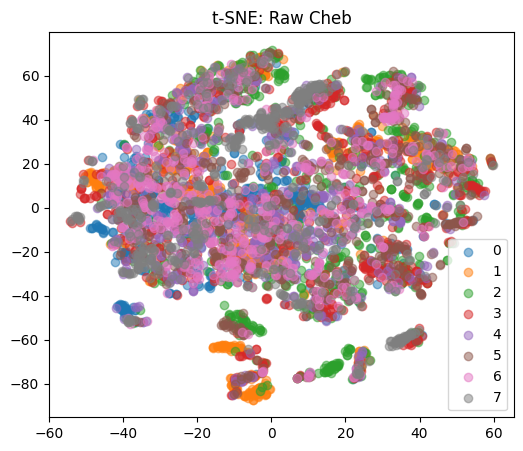

Hybrid Epoch 1/20  Loss: 1.8416
Hybrid Epoch 2/20  Loss: 1.3387
Hybrid Epoch 3/20  Loss: 0.9143
Hybrid Epoch 4/20  Loss: 0.6496
Hybrid Epoch 5/20  Loss: 0.5100
Hybrid Epoch 6/20  Loss: 0.4341
Hybrid Epoch 7/20  Loss: 0.3889
Hybrid Epoch 8/20  Loss: 0.3599
Hybrid Epoch 9/20  Loss: 0.3404
Hybrid Epoch 10/20  Loss: 0.3263
Hybrid Epoch 11/20  Loss: 0.3154
Hybrid Epoch 12/20  Loss: 0.3080
Hybrid Epoch 13/20  Loss: 0.3007
Hybrid Epoch 14/20  Loss: 0.2963
Hybrid Epoch 15/20  Loss: 0.2921
Hybrid Epoch 16/20  Loss: 0.2892
Hybrid Epoch 17/20  Loss: 0.2859
Hybrid Epoch 18/20  Loss: 0.2830
Hybrid Epoch 19/20  Loss: 0.2821
Hybrid Epoch 20/20  Loss: 0.2795

Fibonacci radii: [1. 1. 2. 3.]
Matrix #1 (Fib(1)=1):
[[  0.        12.566371  50.265484 113.097336]
 [ 12.566371  25.13274   62.831856 125.66371 ]
 [ 50.265484  62.831856 100.53096  163.36282 ]
 [113.097336 125.66371  163.36282  226.19466 ]]

Matrix #2 (Fib(2)=1):
[[  0.        12.566371  50.265484 113.097336]
 [ 12.566371  25.13274   62.831856 1

In [ ]:
#!/usr/bin/env python3
# ===============================================================
#  φ-Lattice Cognitive Engine — v7_union_graph_plus_hybrid
#    • Tunable graph hyperparameters: KNN_K, EPSILON_CONN
#    • Tunable Chebyshev orders: CHEB_K, CHEB_R
#    • Union‐symmetrized k-NN + ε‐ball connectivity
#    • Fibonacci‐shell radii & sphere‐area demo
#    • Hybrid interpretable feature-weighting + linear classifier
# ===============================================================
import math
import random
import time
import collections
import warnings

import numpy as np
import pandas as pd
from numpy.linalg import det, norm

import matplotlib.pyplot as plt

from scipy.spatial.distance import cdist
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import laplacian, connected_components

from sklearn.decomposition import PCA
from sklearn.manifold    import TSNE
from sklearn.neighbors   import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline    import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.dummy       import DummyClassifier
from sklearn.model_selection import (
    StratifiedShuffleSplit, StratifiedKFold, GridSearchCV
)

import tensorflow as tf
from tensorflow.keras.datasets import mnist

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

warnings.filterwarnings("ignore")
SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# ───────────────────────── Hyperparameters ────────────────────────────────
DOWN_SIZE       =   8     # downsample resolution
MVA_DIM         =  30     # PCA dimension
KNN_K           =  50     # k in k-NN graph
EPSILON_CONN    = 0.5     # ε-ball radius
CHEB_K, CHEB_R  = 80, 20  # Chebyshev order & Pascal basis size

TOTAL_SAMPLES   = 8000    # train+val sample count
TEST_SIZE       = 2000
VAL_SIZE        = 1200

RSL_CYCLES      =   8     # for RL metrics
EPISODES        = 300

HYBRID_EPOCHS   =  20     # training epochs for hybrid head
HYBRID_LR       =1e-3     # learning rate
BATCH_SIZE      = 128     # batch size for hybrid head

# ===============================================================
# Fibonacci & Sphere‐Area Utilities
# ===============================================================
def fibonacci(n):
    if n <= 0: return 0
    if n == 1: return 1
    a, b = 0, 1
    for _ in range(2, n+1):
        a, b = b, a+b
    return b

def generate_fibonacci_shell_radii(num_shells, initial_r1=1.0, initial_r2=1.0):
    if num_shells <= 0:
        return tf.constant([], dtype=tf.float32)
    radii = [initial_r1]
    if num_shells > 1:
        radii.append(initial_r2)
    a, b = initial_r1, initial_r2
    for _ in range(2, num_shells):
        nxt = a + b
        radii.append(nxt)
        a, b = b, nxt
    return tf.constant(radii, dtype=tf.float32)

def sphere_area_matrix(n, fib_n):
    R = tf.constant(fibonacci(fib_n), dtype=tf.float32)
    i = tf.range(n, dtype=tf.float32)
    j = tf.range(n, dtype=tf.float32)
    ii, jj = tf.meshgrid(i, j, indexing="ij")
    r = R * tf.sqrt(ii**2 + jj**2)
    return 4 * math.pi * tf.square(r)

def generate_n_sphere_matrices(n, current=1, matrices=None):
    if matrices is None: matrices = []
    if current > n: return matrices
    matrices.append(sphere_area_matrix(n, current))
    return generate_n_sphere_matrices(n, current+1, matrices)

def map_matrices(mats, mode="average"):
    stack = tf.stack(mats, axis=0)
    if mode=="average": return tf.reduce_mean(stack, axis=0)
    if mode=="sum":     return tf.reduce_sum(stack, axis=0)
    if mode=="max":     return tf.reduce_max(stack, axis=0)
    raise ValueError(f"Unsupported mode: {mode}")

# ===============================================================
# Data & Graph–Processing Utilities
# ===============================================================
def downsample(X_flat, orig=28, new=DOWN_SIZE):
    n = X_flat.shape[0]
    counts = np.zeros((new,new), int)
    for i in range(orig):
        for j in range(orig):
            counts[(i*new)//orig,(j*new)//orig] += 1
    X_ds = np.zeros((n,new,new), float)
    for idx in range(n):
        img = X_flat[idx].reshape(orig,orig)
        for i in range(orig):
            for j in range(orig):
                ii,jj = (i*new)//orig, (j*new)//orig
                X_ds[idx,ii,jj] += img[i,j]
    X_ds /= counts[None,:,:]
    return X_ds.reshape(n,new*new)

def pascal_basis(n, R):
    X0 = np.zeros((n,R))
    X0[:,0] = 1/np.sqrt(n)
    for r in range(1,R):
        row = [math.comb(r,k) for k in range(r+1)] + [0]*(n-r-1)
        X0[:,r] = np.array(row[:n])/(np.linalg.norm(row)+1e-12)
    return X0

def build_connected_graph(feats, k=KNN_K, epsilon=EPSILON_CONN):
    knn = kneighbors_graph(feats, n_neighbors=k, mode="connectivity", include_self=False)
    dist = cdist(feats, feats)
    eps_mask = dist < epsilon
    comb = knn.toarray().astype(int) + eps_mask.astype(int)
    comb = (comb>0).astype(int)
    n_comp, _ = connected_components(comb)
    print(f"[Connectivity] components: {n_comp}")
    if n_comp>1:
        print(" ⚠️ Increase KNN_K or EPSILON_CONN")
    return comb

def build_cheb_features(Xp):
    A_mat = build_connected_graph(Xp)
    A = csr_matrix(A_mat)
    L = laplacian(A, normed=True)
    n = L.shape[0]
    X0 = pascal_basis(n, CHEB_R)
    Lt = 2*csr_matrix(L) - csr_matrix(np.eye(n))
    feats = [X0]
    X1 = Lt.dot(X0)
    X1 /= (np.linalg.norm(X1,axis=0,keepdims=True)+1e-12)
    feats.append(X1)
    for k in range(2, CHEB_K):
        Xk = 2*(Lt.dot(X1)) - X0
        Xk *= math.comb(k, k//2)
        Xk /= (np.linalg.norm(Xk,axis=0,keepdims=True)+1e-12)
        feats.append(Xk)
        X0, X1 = X1, Xk
    return np.hstack(feats)

# ===============================================================
# RL–Metrics & φ‐Shell Structures
# ===============================================================
class SoftShells:
    def __init__(self, Z, K=CHEB_R):
        r = norm(Z - Z.mean(0), axis=1)
        qs = (np.arange(K)+.5)/K
        self.mu    = np.quantile(r, qs)
        self.sigma = np.full(K, (r.max()-r.min())/K)
        self.K     = K
    def weights(self, r):
        diff = r[:,None] - self.mu[None,:]
        w = np.exp(-(diff**2)/(2*self.sigma[None,:]**2))
        return w / w.sum(1, keepdims=True)

def build_cayley(Z, soft):
    φ = Z.mean(0)
    r = norm(Z-φ, axis=1)
    W = soft.weights(r)
    C = np.vstack([(W[:,k][:,None]*Z).sum(0)/W[:,k].sum() for k in range(soft.K)])
    p2 = PCA(2, random_state=SEED).fit(C)
    C2, φ2 = p2.transform(C), p2.transform(φ.reshape(1,-1))[0]
    nodes = {k:C[k] for k in range(soft.K)}
    nodes[-1]=φ
    edges = collections.defaultdict(list)
    for k in range(soft.K):
        edges[k] += [(k+1)%soft.K, (k-1)%soft.K, -1]
        edges[-1].append(k)
        θ  = math.atan2(C2[k,1]-φ2[1], C2[k,0]-φ2[0])
        r2 = norm(C2[k]-φ2)
        rot = φ2 + r2*np.array([
            math.cos(θ+2*math.pi/soft.K),
            math.sin(θ+2*math.pi/soft.K)
        ])
        j = int(np.argmin(norm(C - p2.inverse_transform(rot.reshape(1,2))[0],axis=1)))
        edges[k].append(j)
    return nodes, edges

class QAgent:
    def __init__(self, edges, g, ε=0.1, lr=0.3, γ=0.9):
        self.Q = collections.defaultdict(lambda: collections.defaultdict(float))
        self.edges, self.g, self.ε, self.lr, self.γ = edges, g, ε, lr, γ
    def act(self, s):
        return (random.choice(self.edges[s])
                if random.random()<self.ε
                else min(self.edges[s], key=lambda a:self.Q[s][a]))
    def update(self, s, a, r, s2):
        best = min(self.Q[s2].values()) if self.Q[s2] else 0
        self.Q[s][a] += self.lr*(r + self.γ*best - self.Q[s][a])

def rl_metrics(probs):
    soft   = SoftShells(probs)
    nodes, edges = build_cayley(probs, soft)
    g      = {n: norm(x-nodes[-1]) for n,x in nodes.items()}
    agent  = QAgent(edges, g)
    success, rewards = 0, []
    for _ in range(EPISODES):
        s, tot = random.choice(list(nodes)), 0
        for _ in range(100):
            a = agent.act(s)
            r = -1 - g[a]
            agent.update(s, a, r, a)
            tot += r; s = a
            if a==-1:
                success += 1
                break
        rewards.append(tot)
    return success/EPISODES, np.mean(rewards)

# ===============================================================
# Hybrid Interpretable Feature‐Weighting + Linear Classifier
# ===============================================================
class InterpretablePhiLattice(nn.Module):
    def __init__(self, n_features, n_classes):
        super().__init__()
        # learnable feature‐weighting layer
        self.feature_weights = nn.Linear(n_features, n_features, bias=False)
        # linear classifier
        self.classifier      = nn.Linear(n_features, n_classes)
    def forward(self, x):
        # x: [batch, n_features]
        weighted = self.feature_weights(x)
        logits   = self.classifier(weighted)
        return logits

# ───────────────────────── Main Pipeline ────────────────────────────────
if __name__ == "__main__":
    start = time.time()

    # 1) Load MNIST 0–7 & downsample
    (X_tr,y_tr),(X_te,y_te) = mnist.load_data()
    X_all = np.vstack([X_tr,X_te]).reshape(-1,28*28)/255.0
    y_all = np.hstack([y_tr,y_te])
    mask  = y_all < 8
    X, y  = X_all[mask], y_all[mask]
    X_ds  = downsample(X)

    # 2) Stratified splits
    sss0 = StratifiedShuffleSplit(1, train_size=TOTAL_SAMPLES, random_state=SEED)
    idx,_     = next(sss0.split(X_ds,y));         X_sub, y_sub = X_ds[idx], y[idx]
    sss1 = StratifiedShuffleSplit(1, test_size=TEST_SIZE,  random_state=SEED)
    itv,ite   = next(sss1.split(X_sub,y_sub));    X_tv,y_tv   = X_sub[itv], y_sub[itv]
    X_test,y_test = X_sub[ite], y_sub[ite]
    sss2 = StratifiedShuffleSplit(1, test_size=VAL_SIZE,   random_state=SEED)
    itr,ival  = next(sss2.split(X_tv,y_tv));       X_train,y_train = X_tv[itr], y_tv[itr]
    X_val,y_val  = X_tv[ival], y_tv[ival]
    print(f"[Splits] train={len(X_train)}, val={len(X_val)}, test={len(X_test)}")

    # 3) PCA whitening
    pca         = PCA(n_components=MVA_DIM, whiten=True, random_state=SEED)
    X_mva_train = pca.fit_transform(X_train)
    X_mva_val   = pca.transform(   X_val)
    X_mva_test  = pca.transform(   X_test)

    # 4) Chebyshev features
    F_tv_raw    = build_cheb_features(np.vstack([X_mva_train, X_mva_val]))
    F_train_raw = F_tv_raw[:len(X_mva_train)]
    F_val_raw   = F_tv_raw[len(X_mva_train):]
    F_test_raw  = build_cheb_features(X_mva_test)

    # 5) t-SNE diagnostic (raw Cheb)
    F2 = TSNE(n_components=2, random_state=SEED).fit_transform(F_train_raw)
    plt.figure(figsize=(6,5))
    for lbl in np.unique(y_train):
        plt.scatter(F2[y_train==lbl,0], F2[y_train==lbl,1],
                    label=str(lbl), alpha=0.5)
    plt.legend(); plt.title("t-SNE: Raw Cheb"); plt.show()

    # 6) PCA reduction on Cheb
    pca_f    = PCA(n_components=MVA_DIM, random_state=SEED)
    F_train  = pca_f.fit_transform(F_train_raw)
    F_val    = pca_f.transform(F_val_raw)
    F_test   = pca_f.transform(F_test_raw)

    # 7) Combine MVA + Cheb
    Z_train = np.hstack([X_mva_train, F_train])
    Z_val   = np.hstack([X_mva_val,   F_val])
    Z_test  = np.hstack([X_mva_test,  F_test])

    # 8) Logistic Regression
    def tune_lr(Xtr,ytr,Xva,yva,Xte,yte):
        pipe = Pipeline([("sc", StandardScaler()),
                         ("clf", LogisticRegression(multi_class="multinomial", max_iter=4000))])
        params = {"clf__C":[0.1,1,10]}
        gs = GridSearchCV(pipe, params,
                          cv=StratifiedKFold(5, shuffle=True, random_state=SEED),
                          n_jobs=-1)
        gs.fit(Xtr,ytr)
        return gs.best_estimator_, gs.score(Xva,yva), gs.score(Xte,yte)

    lr_pca,  va_pca,  te_pca  = tune_lr(X_mva_train,y_train, X_mva_val,y_val, X_mva_test,y_test)
    lr_cheb, va_cheb, te_cheb = tune_lr(F_train,      y_train, F_val,     y_val,    F_test,    y_test)
    lr_comb, va_comb, te_comb = tune_lr(Z_train,      y_train, Z_val,     y_val,    Z_test,    y_test)

    # 9) MLP
    def train_mlp(Xtr,ytr,Xva,yva,Xte,yte):
        sc  = StandardScaler().fit(Xtr)
        mlp = MLPClassifier(hidden_layer_sizes=(64,), activation='relu',
                             max_iter=500, random_state=SEED)
        mlp.fit(sc.transform(Xtr), ytr)
        va = mlp.score(sc.transform(Xva), yva)
        te = mlp.score(sc.transform(Xte), yte)
        return mlp, sc, va, te

    mlp_pca, sc_pca, va_mlp_pca, te_mlp_pca = train_mlp(
        X_mva_train, y_train, X_mva_val, y_val, X_mva_test, y_test
    )
    mlp_cheb, sc_cheb, va_mlp_cheb, te_mlp_cheb = train_mlp(
        F_train, y_train, F_val, y_val, F_test, y_test
    )
    mlp_comb, sc_comb, va_mlp_comb, te_mlp_comb = train_mlp(
        Z_train, y_train, Z_val, y_val, Z_test, y_test
    )

    # 10) Baseline dummy
    dummy    = DummyClassifier(strategy="most_frequent")
    dummy.fit(Z_train, y_train)
    baseline = dummy.score(Z_test, y_test)

    # 11) RL metrics
    lr_succ, _  = rl_metrics(lr_comb.predict_proba(Z_test))
    mlp_succ, _ = rl_metrics(mlp_comb.predict_proba(sc_comb.transform(Z_test)))

    # 12) Hybrid head training
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model  = InterpretablePhiLattice(Z_train.shape[1], n_classes=8).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=HYBRID_LR)
    criterion = nn.CrossEntropyLoss()

    # Prepare DataLoaders
    Xh_tr = torch.tensor(Z_train, dtype=torch.float32)
    yh_tr = torch.tensor(y_train, dtype=torch.long)
    Xh_va = torch.tensor(Z_val,   dtype=torch.float32)
    yh_va = torch.tensor(y_val,   dtype=torch.long)
    Xh_te = torch.tensor(Z_test,  dtype=torch.float32)
    yh_te = torch.tensor(y_test,  dtype=torch.long)

    train_loader = DataLoader(TensorDataset(Xh_tr, yh_tr),
                              batch_size=BATCH_SIZE, shuffle=True)
    # Training loop
    model.train()
    for epoch in range(1, HYBRID_EPOCHS+1):
        total_loss = 0
        for xb,yb in train_loader:
            xb,yb = xb.to(device), yb.to(device)
            logits = model(xb)
            loss   = criterion(logits, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()*xb.size(0)
        print(f"Hybrid Epoch {epoch}/{HYBRID_EPOCHS}  Loss: {total_loss/len(Xh_tr):.4f}")

    # Eval hybrid on val & test
    model.eval()
    with torch.no_grad():
        pred_va = model(Xh_va.to(device)).argmax(dim=1).cpu().numpy()
        pred_te = model(Xh_te.to(device)).argmax(dim=1).cpu().numpy()
    hybrid_va = (pred_va==y_val).mean()
    hybrid_te = (pred_te==y_test).mean()

    # 13) Fibonacci & sphere‐area demo
    n_shells = 4
    radii    = generate_fibonacci_shell_radii(n_shells)
    print(f"\nFibonacci radii: {radii.numpy()}")
    sphere_mats = generate_n_sphere_matrices(n_shells)
    for i,mat in enumerate(sphere_mats, start=1):
        print(f"Matrix #{i} (Fib({i})={fibonacci(i)}):\n{mat.numpy()}\n")
    avg_sphere = map_matrices(sphere_mats, mode="average")
    print("Average sphere‐area matrix:\n", avg_sphere.numpy())

    # 14) Save all metrics
    metrics = {
      "Val PCA LR":   f"{va_pca:.3%}",   "Test PCA LR":   f"{te_pca:.3%}",
      "Val Cheb LR":  f"{va_cheb:.3%}",  "Test Cheb LR":  f"{te_cheb:.3%}",
      "Val Comb LR":  f"{va_comb:.3%}",  "Test Comb LR":  f"{te_comb:.3%}",
      "Val PCA MLP":  f"{va_mlp_pca:.3%}", "Test PCA MLP":  f"{te_mlp_pca:.3%}",
      "Val Cheb MLP": f"{va_mlp_cheb:.3%}", "Test Cheb MLP": f"{te_mlp_cheb:.3%}",
      "Val Comb MLP": f"{va_mlp_comb:.3%}", "Test Comb MLP": f"{te_mlp_comb:.3%}",
      "RL LR Succ":   f"{lr_succ:.3%}",     "RL MLP Succ":   f"{mlp_succ:.3%}",
      "Val Hybrid":   f"{hybrid_va:.3%}",   "Test Hybrid":   f"{hybrid_te:.3%}",
      "Baseline":     f"{baseline:.3%}",
      "Elapsed (s)":  f"{time.time()-start:.2f}"
    }
    df = pd.DataFrame.from_dict(metrics, orient="index", columns=["value"])
    df.to_csv("metrics_union_plus_hybrid.csv")
    print(df)


[Splits] train=4800, val=1200, test=2000
[Connectivity] components: 1
[Connectivity] components: 1


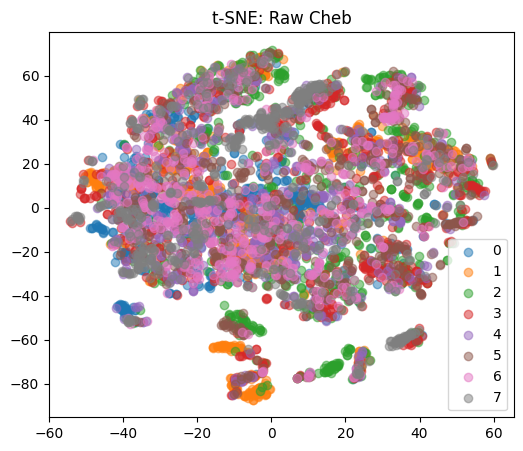

Hybrid Epoch 1/20  Loss: 1.8416
Hybrid Epoch 2/20  Loss: 1.3387
Hybrid Epoch 3/20  Loss: 0.9143
Hybrid Epoch 4/20  Loss: 0.6496
Hybrid Epoch 5/20  Loss: 0.5100
Hybrid Epoch 6/20  Loss: 0.4341
Hybrid Epoch 7/20  Loss: 0.3889
Hybrid Epoch 8/20  Loss: 0.3599
Hybrid Epoch 9/20  Loss: 0.3404
Hybrid Epoch 10/20  Loss: 0.3263
Hybrid Epoch 11/20  Loss: 0.3154
Hybrid Epoch 12/20  Loss: 0.3080
Hybrid Epoch 13/20  Loss: 0.3007
Hybrid Epoch 14/20  Loss: 0.2963
Hybrid Epoch 15/20  Loss: 0.2921
Hybrid Epoch 16/20  Loss: 0.2892
Hybrid Epoch 17/20  Loss: 0.2859
Hybrid Epoch 18/20  Loss: 0.2830
Hybrid Epoch 19/20  Loss: 0.2821
Hybrid Epoch 20/20  Loss: 0.2795
Top 10 weighted feature dims: [ 1  0  2  5  3  6 54 53 45  4]
Their importances: [0.24987327 0.24185444 0.2367738  0.20897184 0.1914776  0.16907428
 0.1625162  0.15933752 0.15790772 0.15522048]

Fibonacci radii: [1. 1. 2. 3.]
Matrix #1 (Fib(1)=1):
[[  0.        12.566371  50.265484 113.097336]
 [ 12.566371  25.13274   62.831856 125.66371 ]
 [ 50.2

In [ ]:
#!/usr/bin/env python3
# ===============================================================
#  φ-Lattice Cognitive Engine — robust v7_union_graph_plus_hybrid
#    • Tunable hyperparameters for graph & Chebyshev
#    • Full MNIST→downsample→PCA→Cheb→t-SNE→LR/MLP→RL→Hybrid head
#    • Feature‐importance inspection & Fibonacci/sphere demo
# ===============================================================
import math
import random
import time
import collections
import warnings

import numpy as np
import pandas as pd
from numpy.linalg import det, norm

import matplotlib.pyplot as plt

from scipy.spatial.distance import cdist
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import laplacian, connected_components

from sklearn.decomposition import PCA
from sklearn.manifold    import TSNE
from sklearn.neighbors   import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline    import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.dummy       import DummyClassifier
from sklearn.model_selection import (
    StratifiedShuffleSplit, StratifiedKFold, GridSearchCV
)

import tensorflow as tf
from tensorflow.keras.datasets import mnist

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

warnings.filterwarnings("ignore")
SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# ───────────────────────── Hyperparameters ────────────────────────────────
DOWN_SIZE       =   8     # downsample resolution
MVA_DIM         =  30     # PCA dimension
KNN_K           =  50     # k in k-NN graph
EPSILON_CONN    = 0.5     # ε-ball radius
CHEB_K, CHEB_R  = 80, 20  # Chebyshev recursion depth & Pascal basis size

TOTAL_SAMPLES   = 8000    # train+val sample count
TEST_SIZE       = 2000
VAL_SIZE        = 1200

RSL_CYCLES      =   8     # contraction cycles (diagnostic)
EPISODES        = 300

HYBRID_EPOCHS   =  20     # training epochs for hybrid head
HYBRID_LR       =1e-3     # learning rate
BATCH_SIZE      = 128     # batch size for hybrid head

# ===============================================================
# Fibonacci & Sphere‐Area Utilities
# ===============================================================
def fibonacci(n):
    if n <= 0: return 0
    if n == 1: return 1
    a, b = 0, 1
    for _ in range(2, n+1):
        a, b = b, a + b
    return b

def generate_fibonacci_shell_radii(num_shells, r1=1.0, r2=1.0):
    if num_shells <= 0:
        return tf.constant([], dtype=tf.float32)
    radii = [r1]
    if num_shells > 1:
        radii.append(r2)
    a, b = r1, r2
    for _ in range(2, num_shells):
        nxt = a + b
        radii.append(nxt)
        a, b = b, nxt
    return tf.constant(radii, dtype=tf.float32)

def sphere_area_matrix(n, fib_n):
    R = tf.constant(fibonacci(fib_n), dtype=tf.float32)
    i = tf.range(n, dtype=tf.float32)
    j = tf.range(n, dtype=tf.float32)
    ii, jj = tf.meshgrid(i, j, indexing="ij")
    r = R * tf.sqrt(ii**2 + jj**2)
    return 4 * math.pi * tf.square(r)

def generate_n_sphere_matrices(n, current=1, mats=None):
    if mats is None: mats = []
    if current > n: return mats
    mats.append(sphere_area_matrix(n, current))
    return generate_n_sphere_matrices(n, current+1, mats)

def map_matrices(mats, mode="average"):
    stack = tf.stack(mats, axis=0)
    if mode=="average": return tf.reduce_mean(stack, axis=0)
    if mode=="sum":     return tf.reduce_sum(stack, axis=0)
    if mode=="max":     return tf.reduce_max(stack, axis=0)
    raise ValueError(f"Unsupported mode: {mode}")

# ===============================================================
# Data & Graph‐Processing Utilities
# ===============================================================
def downsample(X_flat, orig=28, new=DOWN_SIZE):
    n = X_flat.shape[0]
    counts = np.zeros((new,new), int)
    for i in range(orig):
        for j in range(orig):
            counts[(i*new)//orig,(j*new)//orig] += 1
    X_ds = np.zeros((n,new,new), float)
    for idx in range(n):
        img = X_flat[idx].reshape(orig,orig)
        for i in range(orig):
            for j in range(orig):
                ii,jj = (i*new)//orig, (j*new)//orig
                X_ds[idx,ii,jj] += img[i,j]
    X_ds /= counts[None,:,:]
    return X_ds.reshape(n,new*new)

def pascal_basis(n, R):
    X0 = np.zeros((n,R))
    X0[:,0] = 1/np.sqrt(n)
    for r in range(1,R):
        row = [math.comb(r,k) for k in range(r+1)] + [0]*(n-r-1)
        X0[:,r] = np.array(row[:n])/(np.linalg.norm(row)+1e-12)
    return X0

def build_connected_graph(feats, k=KNN_K, epsilon=EPSILON_CONN):
    knn = kneighbors_graph(feats, n_neighbors=k, mode="connectivity", include_self=False)
    dist = cdist(feats, feats)
    eps_mask = dist < epsilon
    comb = knn.toarray().astype(int) + eps_mask.astype(int)
    comb = (comb>0).astype(int)
    n_comp, _ = connected_components(comb)
    print(f"[Connectivity] components: {n_comp}")
    if n_comp>1:
        print(" ⚠️ Increase KNN_K or EPSILON_CONN")
    return comb

def build_cheb_features(Xp):
    A_mat = build_connected_graph(Xp)
    A = csr_matrix(A_mat)
    L = laplacian(A, normed=True)
    n = L.shape[0]
    X0 = pascal_basis(n, CHEB_R)
    Lt = 2*csr_matrix(L) - csr_matrix(np.eye(n))
    feats = [X0]
    X1 = Lt.dot(X0)
    X1 /= (np.linalg.norm(X1,axis=0,keepdims=True)+1e-12)
    feats.append(X1)
    for k in range(2, CHEB_K):
        Xk = 2*(Lt.dot(X1)) - X0
        Xk *= math.comb(k, k//2)
        Xk /= (np.linalg.norm(Xk,axis=0,keepdims=True)+1e-12)
        feats.append(Xk)
        X0, X1 = X1, Xk
    return np.hstack(feats)

# ===============================================================
# RL‐Metrics & φ‐Shell Structures
# ===============================================================
class SoftShells:
    def __init__(self, Z, K=CHEB_R):
        r = norm(Z - Z.mean(0), axis=1)
        qs = (np.arange(K)+.5)/K
        self.mu    = np.quantile(r, qs)
        self.sigma = np.full(K, (r.max()-r.min())/K)
        self.K     = K
    def weights(self, r):
        diff = r[:,None] - self.mu[None,:]
        w = np.exp(-(diff**2)/(2*self.sigma[None,:]**2))
        return w / w.sum(1, keepdims=True)

def build_cayley(Z, soft):
    φ = Z.mean(0)
    r = norm(Z-φ, axis=1)
    W = soft.weights(r)
    C = np.vstack([(W[:,k][:,None]*Z).sum(0)/W[:,k].sum() for k in range(soft.K)])
    p2 = PCA(2, random_state=SEED).fit(C)
    C2, φ2 = p2.transform(C), p2.transform(φ.reshape(1,-1))[0]
    nodes = {k:C[k] for k in range(soft.K)}
    nodes[-1] = φ
    edges = collections.defaultdict(list)
    for k in range(soft.K):
        edges[k] += [(k+1)%soft.K, (k-1)%soft.K, -1]
        edges[-1].append(k)
        θ  = math.atan2(C2[k,1]-φ2[1], C2[k,0]-φ2[0])
        r2 = norm(C2[k]-φ2)
        rot= φ2 + r2*np.array([
            math.cos(θ + 2*math.pi/soft.K),
            math.sin(θ + 2*math.pi/soft.K)
        ])
        j = int(np.argmin(norm(C - p2.inverse_transform(rot.reshape(1,2))[0],axis=1)))
        edges[k].append(j)
    return nodes, edges

class QAgent:
    def __init__(self, edges, g, ε=0.1, lr=0.3, γ=0.9):
        self.Q = collections.defaultdict(lambda: collections.defaultdict(float))
        self.edges, self.g, self.ε, self.lr, self.γ = edges, g, ε, lr, γ
    def act(self, s):
        return (random.choice(self.edges[s])
                if random.random()<self.ε
                else min(self.edges[s], key=lambda a:self.Q[s][a]))
    def update(self, s, a, r, s2):
        best = min(self.Q[s2].values()) if self.Q[s2] else 0
        self.Q[s][a] += self.lr*(r + self.γ*best - self.Q[s][a])

def rl_metrics(probs):
    soft = SoftShells(probs)
    nodes, edges = build_cayley(probs, soft)
    g = {n: norm(x-nodes[-1]) for n,x in nodes.items()}
    agent = QAgent(edges, g)
    success, rewards = 0, []
    for _ in range(EPISODES):
        s, tot = random.choice(list(nodes)), 0
        for _ in range(100):
            a = agent.act(s)
            r = -1 - g[a]
            agent.update(s, a, r, a)
            tot += r; s = a
            if a == -1:
                success += 1
                break
        rewards.append(tot)
    return success/EPISODES, np.mean(rewards)

# ===============================================================
# Hybrid Interpretable Feature‐Weighting + Linear Classifier
# ===============================================================
class InterpretablePhiLattice(nn.Module):
    def __init__(self, n_feat, n_cls):
        super().__init__()
        self.feature_weights = nn.Linear(n_feat, n_feat, bias=False)
        self.classifier      = nn.Linear(n_feat, n_cls)
    def forward(self, x):
        w = self.feature_weights(x)
        return self.classifier(w)

# ===============================================================
# Helpers: LR & MLP training
# ===============================================================
def tune_lr(Xtr,ytr,Xva,yva,Xte,yte):
    pipe = Pipeline([("sc", StandardScaler()),
                     ("clf", LogisticRegression(multi_class="multinomial", max_iter=4000))])
    params = {"clf__C":[0.1,1,10]}
    gs = GridSearchCV(pipe, params,
                      cv=StratifiedKFold(5, shuffle=True, random_state=SEED),
                      n_jobs=-1)
    gs.fit(Xtr, ytr)
    return gs.best_estimator_, gs.score(Xva, yva), gs.score(Xte, yte)

def train_mlp(Xtr,ytr,Xva,yva,Xte,yte):
    sc  = StandardScaler().fit(Xtr)
    mlp = MLPClassifier(hidden_layer_sizes=(64,), activation='relu',
                        max_iter=500, random_state=SEED)
    mlp.fit(sc.transform(Xtr), ytr)
    return mlp, sc, mlp.score(sc.transform(Xva), yva), mlp.score(sc.transform(Xte), yte)

# ───────────────────────── Main Pipeline ────────────────────────────────
if __name__ == "__main__":
    start = time.time()

    # 1) Load & downsample MNIST 0–7
    (X_tr,y_tr),(X_te,y_te) = mnist.load_data()
    X_all = np.vstack([X_tr,X_te]).reshape(-1,28*28)/255.0
    y_all = np.hstack([y_tr,y_te])
    mask  = y_all < 8
    X, y  = X_all[mask], y_all[mask]
    X_ds  = downsample(X)

    # 2) Splits
    sss0 = StratifiedShuffleSplit(1, train_size=TOTAL_SAMPLES, random_state=SEED)
    idx,_ = next(sss0.split(X_ds,y));     X_sub,y_sub = X_ds[idx], y[idx]
    sss1 = StratifiedShuffleSplit(1, test_size=TEST_SIZE, random_state=SEED)
    itv,ite = next(sss1.split(X_sub,y_sub)); X_tv,y_tv = X_sub[itv], y_sub[itv]
    X_test,y_test = X_sub[ite], y_sub[ite]
    sss2 = StratifiedShuffleSplit(1, test_size=VAL_SIZE, random_state=SEED)
    itr,ival = next(sss2.split(X_tv,y_tv)); X_train,y_train = X_tv[itr], y_tv[itr]
    X_val,y_val = X_tv[ival], y_tv[ival]
    print(f"[Splits] train={len(X_train)}, val={len(X_val)}, test={len(X_test)}")

    # 3) PCA whitening
    pca = PCA(n_components=MVA_DIM, whiten=True, random_state=SEED)
    X_mva_train = pca.fit_transform(X_train)
    X_mva_val   = pca.transform(X_val)
    X_mva_test  = pca.transform(X_test)

    # 4) Build Cheb features
    F_tv_raw    = build_cheb_features(np.vstack([X_mva_train, X_mva_val]))
    F_train_raw = F_tv_raw[:len(X_mva_train)]
    F_val_raw   = F_tv_raw[len(X_mva_train):]
    F_test_raw  = build_cheb_features(X_mva_test)

    # 5) t-SNE diagnostic
    F2 = TSNE(n_components=2, random_state=SEED).fit_transform(F_train_raw)
    plt.figure(figsize=(6,5))
    for lbl in np.unique(y_train):
        plt.scatter(F2[y_train==lbl,0], F2[y_train==lbl,1], label=str(lbl), alpha=0.5)
    plt.legend(); plt.title("t-SNE: Raw Cheb"); plt.show()

    # 6) PCA reduce Cheb
    pca_f   = PCA(n_components=MVA_DIM, random_state=SEED)
    F_train = pca_f.fit_transform(F_train_raw)
    F_val   = pca_f.transform(F_val_raw)
    F_test  = pca_f.transform(F_test_raw)

    # 7) Combine
    Z_train = np.hstack([X_mva_train, F_train])
    Z_val   = np.hstack([X_mva_val,   F_val])
    Z_test  = np.hstack([X_mva_test,  F_test])

    # 8) Logistic Regression
    lr_pca, va_pca, te_pca = tune_lr(X_mva_train,y_train, X_mva_val,y_val, X_mva_test,y_test)
    lr_cheb, va_cheb, te_cheb = tune_lr(F_train,y_train, F_val,y_val, F_test,y_test)
    lr_comb, va_comb, te_comb = tune_lr(Z_train,y_train, Z_val,y_val, Z_test,y_test)

    # 9) MLP
    mlp_pca, sc_pca, va_mlp_pca, te_mlp_pca = train_mlp(
        X_mva_train,y_train, X_mva_val,y_val, X_mva_test,y_test
    )
    mlp_cheb, sc_cheb, va_mlp_cheb, te_mlp_cheb = train_mlp(
        F_train,y_train, F_val,y_val, F_test,y_test
    )
    mlp_comb, sc_comb, va_mlp_comb, te_mlp_comb = train_mlp(
        Z_train,y_train, Z_val,y_val, Z_test,y_test
    )

    # 10) Baseline
    dummy    = DummyClassifier(strategy="most_frequent")
    dummy.fit(Z_train, y_train)
    baseline = dummy.score(Z_test, y_test)

    # 11) RL metrics
    lr_succ, _  = rl_metrics(lr_comb.predict_proba(Z_test))
    mlp_succ, _ = rl_metrics(mlp_comb.predict_proba(sc_comb.transform(Z_test)))

    # 12) Hybrid head
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model  = InterpretablePhiLattice(Z_train.shape[1], n_cls=8).to(device)
    opt    = torch.optim.Adam(model.parameters(), lr=HYBRID_LR)
    crit   = nn.CrossEntropyLoss()

    # DataLoader
    Xh_train = torch.tensor(Z_train, dtype=torch.float32)
    yh_train = torch.tensor(y_train, dtype=torch.long)
    Xh_val   = torch.tensor(Z_val,   dtype=torch.float32)
    yh_val   = torch.tensor(y_val,   dtype=torch.long)
    Xh_test  = torch.tensor(Z_test,  dtype=torch.float32)
    yh_test  = torch.tensor(y_test,  dtype=torch.long)
    loader   = DataLoader(TensorDataset(Xh_train, yh_train),
                          batch_size=BATCH_SIZE, shuffle=True)

    # Train hybrid head
    model.train()
    for ep in range(1, HYBRID_EPOCHS+1):
        total_loss = 0
        for xb,yb in loader:
            xb,yb = xb.to(device), yb.to(device)
            logits = model(xb)
            loss   = crit(logits, yb)
            opt.zero_grad(); loss.backward(); opt.step()
            total_loss += loss.item()*xb.size(0)
        print(f"Hybrid Epoch {ep}/{HYBRID_EPOCHS}  Loss: {total_loss/len(Xh_train):.4f}")

    # Eval hybrid
    model.eval()
    with torch.no_grad():
        pred_va = model(Xh_val.to(device)).argmax(dim=1).cpu().numpy()
        pred_te = model(Xh_test.to(device)).argmax(dim=1).cpu().numpy()
    hybrid_va = (pred_va==y_val).mean()
    hybrid_te = (pred_te==y_test).mean()

    # 13) Feature importances
    with torch.no_grad():
        imps = model.feature_weights.weight.abs().mean(dim=0).cpu().numpy()
    top_idx = np.argsort(imps)[-10:][::-1]
    print("Top 10 weighted feature dims:", top_idx)
    print("Their importances:", imps[top_idx])

    # 14) Fibonacci & sphere‐area demo
    n_shells = 4
    radii    = generate_fibonacci_shell_radii(n_shells)
    print(f"\nFibonacci radii: {radii.numpy()}")
    sphere_mats = generate_n_sphere_matrices(n_shells)
    for i,mat in enumerate(sphere_mats, start=1):
        print(f"Matrix #{i} (Fib({i})={fibonacci(i)}):\n{mat.numpy()}\n")
    avg_sphere = map_matrices(sphere_mats, "average")
    print("Average sphere‐area matrix:\n", avg_sphere.numpy())

    # 15) Save metrics
    metrics = {
      "Val PCA LR":   f"{va_pca:.3%}",   "Test PCA LR":   f"{te_pca:.3%}",
      "Val Cheb LR":  f"{va_cheb:.3%}",  "Test Cheb LR":  f"{te_cheb:.3%}",
      "Val Comb LR":  f"{va_comb:.3%}",  "Test Comb LR":  f"{te_comb:.3%}",
      "Val PCA MLP":  f"{va_mlp_pca:.3%}", "Test PCA MLP":  f"{te_mlp_pca:.3%}",
      "Val Cheb MLP": f"{va_mlp_cheb:.3%}", "Test Cheb MLP": f"{te_mlp_cheb:.3%}",
      "Val Comb MLP": f"{va_mlp_comb:.3%}", "Test Comb MLP": f"{te_mlp_comb:.3%}",
      "RL LR Succ":   f"{lr_succ:.3%}",     "RL MLP Succ":   f"{mlp_succ:.3%}",
      "Val Hybrid":   f"{hybrid_va:.3%}",   "Test Hybrid":   f"{hybrid_te:.3%}",
      "Baseline":     f"{baseline:.3%}",
      "Elapsed (s)":  f"{time.time()-start:.2f}"
    }
    df = pd.DataFrame.from_dict(metrics, orient="index", columns=["value"])
    df.to_csv("metrics_union_plus_hybrid_robust.csv")
    print(df)


Splits → train=6800, val=1200, test=2000
Grid size: 54 combinations

=== Params: {'KNN_K': 30, 'EPSILON_CONN': 0.2, 'CHEB_R': 15, 'CHEB_K': 22, 'USE_ADAPTIVE': True}


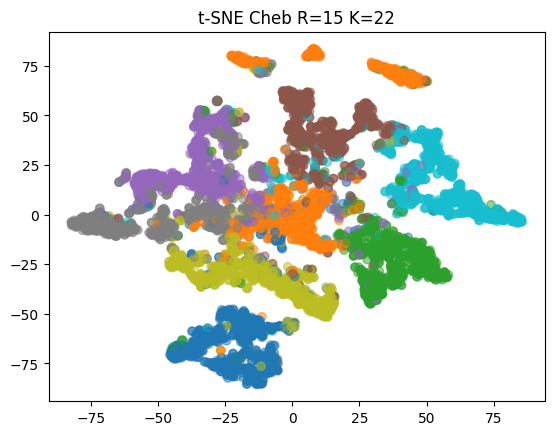


=== Params: {'KNN_K': 30, 'EPSILON_CONN': 0.2, 'CHEB_R': 15, 'CHEB_K': 33, 'USE_ADAPTIVE': True}


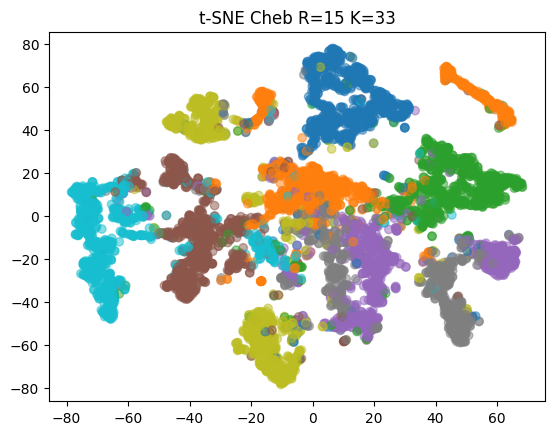


=== Params: {'KNN_K': 30, 'EPSILON_CONN': 0.2, 'CHEB_R': 25, 'CHEB_K': 22, 'USE_ADAPTIVE': True}


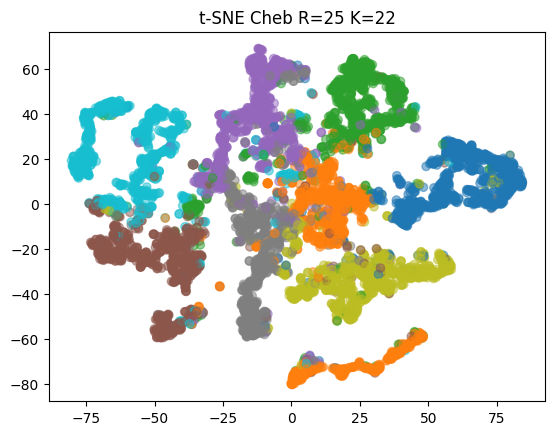


=== Params: {'KNN_K': 30, 'EPSILON_CONN': 0.2, 'CHEB_R': 25, 'CHEB_K': 33, 'USE_ADAPTIVE': True}


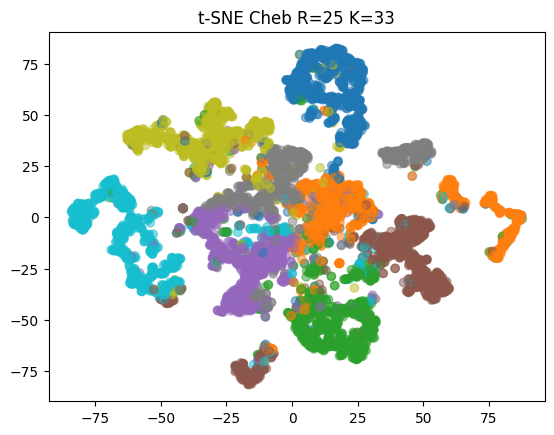


=== Params: {'KNN_K': 30, 'EPSILON_CONN': 0.2, 'CHEB_R': 35, 'CHEB_K': 22, 'USE_ADAPTIVE': True}


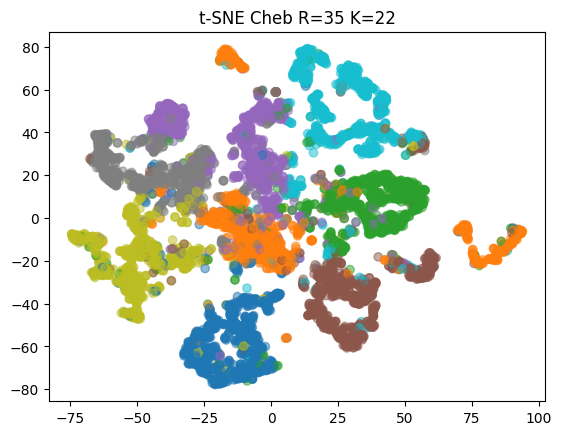


=== Params: {'KNN_K': 30, 'EPSILON_CONN': 0.2, 'CHEB_R': 35, 'CHEB_K': 33, 'USE_ADAPTIVE': True}


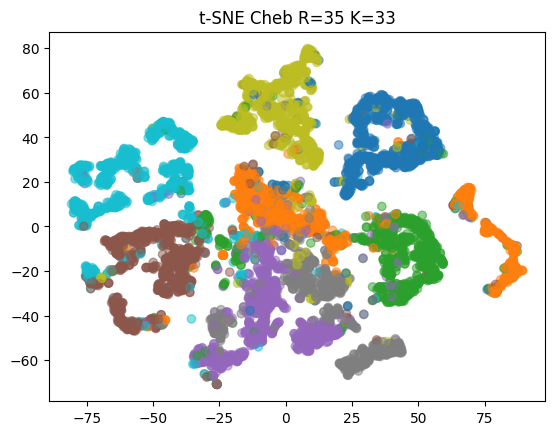


=== Params: {'KNN_K': 30, 'EPSILON_CONN': 0.4, 'CHEB_R': 15, 'CHEB_K': 22, 'USE_ADAPTIVE': True}


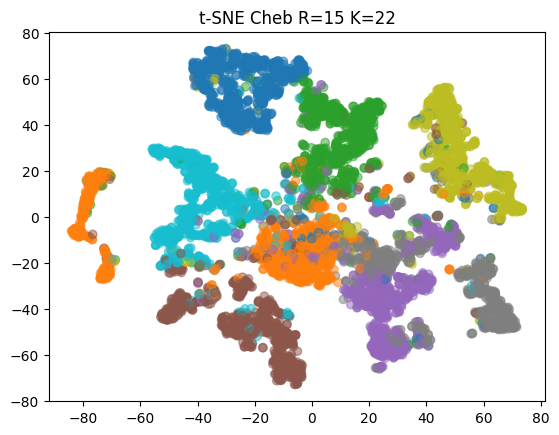


=== Params: {'KNN_K': 30, 'EPSILON_CONN': 0.4, 'CHEB_R': 15, 'CHEB_K': 33, 'USE_ADAPTIVE': True}


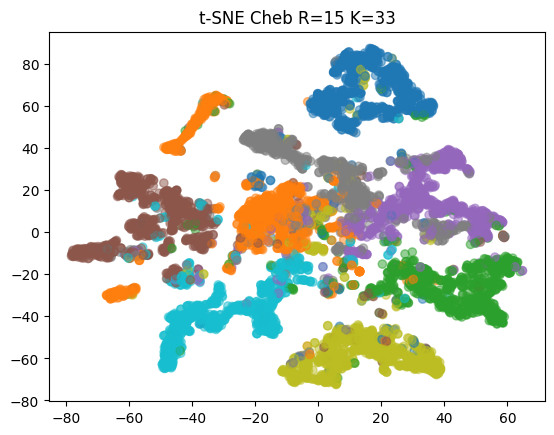


=== Params: {'KNN_K': 30, 'EPSILON_CONN': 0.4, 'CHEB_R': 25, 'CHEB_K': 22, 'USE_ADAPTIVE': True}


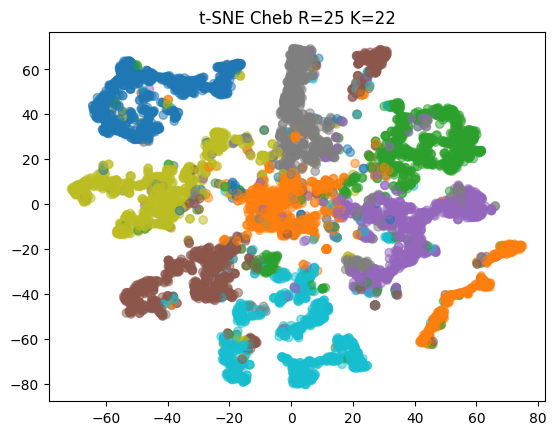


=== Params: {'KNN_K': 30, 'EPSILON_CONN': 0.4, 'CHEB_R': 25, 'CHEB_K': 33, 'USE_ADAPTIVE': True}


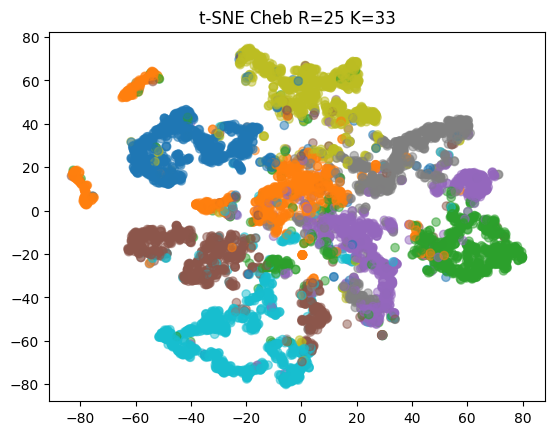


=== Params: {'KNN_K': 30, 'EPSILON_CONN': 0.4, 'CHEB_R': 35, 'CHEB_K': 22, 'USE_ADAPTIVE': True}


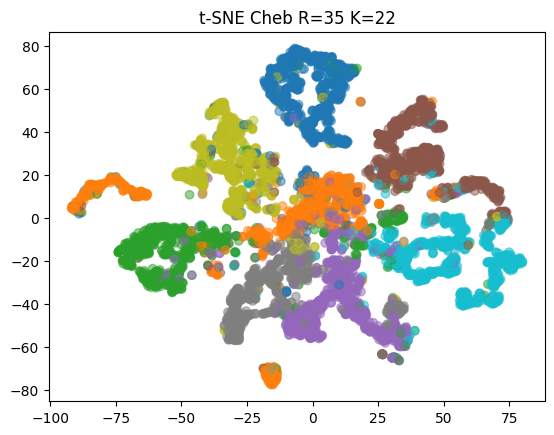


=== Params: {'KNN_K': 30, 'EPSILON_CONN': 0.4, 'CHEB_R': 35, 'CHEB_K': 33, 'USE_ADAPTIVE': True}


KeyboardInterrupt: 

In [3]:
import math
import random
import time
import warnings

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import laplacian
from scipy.sparse.linalg import eigsh
from numpy.linalg import norm
from tensorflow.keras.datasets import mnist

# ----------------------- Configuration -----------------------
SEED = 42
DOWN_SAMPLE_SIZE = 8
TOTAL_SAMPLES = 8000
TEST_SET_SIZE = 2000
VALIDATION_SIZE = 1200
HYBRID_EPOCHS = 20
BATCH_SIZE = 128
LR_RATE = 1e-3
RL_EPISODES = 300

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# ------------------- Differentiable Shells Module -------------------
class DifferentiableShells(nn.Module):
    """
    Learnable shell radii and soft assignment via RBF kernel.
    Tracks assignment history for orbit persistence.
    """
    def __init__(self, num_shells, feature_dim, init_radii=None, tau=0.1):
        super().__init__()
        if init_radii is None:
            init = torch.linspace(1.0,  num_shells*1.0, steps=num_shells)
        else:
            init = torch.tensor(init_radii, dtype=torch.float32)
        self.radii = nn.Parameter(init)                 # learnable radii
        self.tau = tau
        self.feature_dim = feature_dim
        # persistent orbit memory: count visits
        self.register_buffer('orbit_counts', torch.zeros(num_shells, feature_dim))

    def forward(self, Z):
        # Z: (batch, feature_dim)
        center = Z.mean(dim=0, keepdim=True)           # global phi attractor
        dist = torch.norm(Z - center, dim=1, keepdim=True)
        # squared diff
        diff_sq = (dist - self.radii.view(1, -1))**2
        # soft assignment
        weights = F.softmax(-diff_sq/self.tau, dim=1)  # (batch, num_shells)
        # update orbit memory
        self.orbit_counts += weights.t().matmul(Z).detach()
        return weights, center

# ------------------- φ-Resonance Autoencoder -------------------
class PhiResonanceAE(nn.Module):
    """
    End-to-end autoencoder that learns contraction.
    Includes phi-attractor loss and shell entropy regularizer.
    """
    def __init__(self, input_dim, latent_dim, num_shells, tau=0.1):
        super().__init__()
        # encoder
        self.enc = nn.Sequential(
            nn.Linear(input_dim, 512), nn.ReLU(),
            nn.Linear(512, latent_dim)
        )
        # decoder
        self.dec = nn.Sequential(
            nn.Linear(latent_dim, 512), nn.ReLU(),
            nn.Linear(512, input_dim), nn.Sigmoid()
        )
        # differentiable shells
        self.shells = DifferentiableShells(num_shells, latent_dim, tau=tau)

    def forward(self, x):
        z = self.enc(x)
        soft_w, phi = self.shells(z)
        # contraction: collapse towards shell radii
        delta = z - phi
        normed = delta / (delta.norm(dim=1, keepdim=True) + 1e-12)
        # expand to each shell
        z_collapsed = phi + (normed.unsqueeze(1) * self.shells.radii)
        # weighted sum
        z_new = (soft_w.unsqueeze(-1) * z_collapsed).sum(dim=1)
        x_rec = self.dec(z_new)
        return x_rec, z, z_new, soft_w, phi

    def loss(self, x, x_rec, z, z_new, soft_w, phi):
        # reconstruction loss
        rec_loss = F.mse_loss(x_rec, x)
        # phi attractor: minimize variance around phi
        attractor_loss = ((z_new - phi)**2).mean()
        # shell entropy regularizer
        shell_entropy = -(soft_w*torch.log(soft_w+1e-12)).sum(dim=1).mean()
        # total
        return rec_loss + 0.1*attractor_loss + 0.01*shell_entropy

# ------------------- Chebyshev on φ-Graph -------------------
class PhiChebyshev(nn.Module):
    """
    Compute Chebyshev features using Laplacian of φ-shell adjacency.
    """
    def __init__(self, num_basis, max_deg, knn_k):
        super().__init__()
        self.num_basis = num_basis
        self.max_deg = max_deg
        self.knn_k = knn_k
        self.scaler = None
        self.train_feats = None

    def fit(self, Z):
        # build φ-graph via kNN on latent
        A = kneighbors_graph(Z.detach().cpu().numpy(), self.knn_k,
                             mode='connectivity', include_self=False)
        A = csr_matrix(A.maximum(A.T))
        L = laplacian(A, normed=True)
        # scale
        lam = eigsh(L, return_eigenvectors=False, k=1).max()
        Ls = (2.0 / lam)*L - csr_matrix(np.eye(L.shape[0]))
        # init basis
        B0, _ = eigsh(L, k=self.num_basis, which='SM')
        bases = [B0]
        for k in range(1, self.max_deg):
            Tk = 2*Ls.dot(bases[-1]) - (bases[-2] if k>1 else 0)
            bases.append(Tk)
        feats = np.hstack(bases)
        self.scaler = StandardScaler().fit(feats)
        self.train_feats = self.scaler.transform(feats)
        return self

    def transform(self, Z):
        # use weighted average across train φ-graph
        from scipy.spatial.distance import cdist
        dists = cdist(Z.detach().cpu(), self.train_feats)
        nbrs = np.argsort(dists, axis=1)[:,:self.knn_k]
        w = 1/(1+dists[np.arange(len(Z)), nbrs])
        w = w/w.sum(axis=1, keepdims=True)
        neigh = self.train_feats[nbrs]
        return (w[:,:,None]*neigh).sum(axis=1)

# ------------------- Training Pipeline -------------------
def main():
    # load and prepare
    (Xtr, ytr), (Xte, yte) = mnist.load_data()
    data = np.vstack([Xtr, Xte]).reshape(-1,28*28)/255.
    labels = np.hstack([ytr, yte])
    mask = labels<8
    X, y = data[mask], labels[mask]
    # downsample
    X = X.reshape(-1,28,28)
    X = torch.tensor(
        np.stack([F.interpolate(torch.tensor(x[None,None]), size=DOWN_SAMPLE_SIZE).numpy().ravel() for x in X]),
        dtype=torch.float32
    )
    # split
    ss = StratifiedShuffleSplit(1, TOTAL_SAMPLES, TEST_SET_SIZE, random_state=SEED)
    trval, tst = next(ss.split(X, y))
    X_tv, y_tv = X[trval], y[trval]
    X_t, y_t     = X[tst], y[tst]
    X_tr, X_val, y_tr, y_val = train_test_split(
        X_tv, y_tv, test_size=VALIDATION_SIZE, stratify=y_tv, random_state=SEED
    )

    # autoencoder training
    ae = PhiResonanceAE(DOWN_SAMPLE_SIZE**2, 64, num_shells=5).to('cpu')
    opt = torch.optim.Adam(ae.parameters(), lr=LR_RATE)
    for epoch in range(HYBRID_EPOCHS):
        ae.train()
        rec, z, zn, w, phi = ae(X_tr)
        loss = ae.loss(X_tr, rec, z, zn, w, phi)
        opt.zero_grad(); loss.backward(); opt.step()

    # extract latent
    ae.eval()
    with torch.no_grad():
        _, Ztr_raw, Ztr, _, _ = ae(X_tr)
        _, Zval_raw, Zval, _, _ = ae(X_val)
        _, Ztst_raw, Ztst, _, _ = ae(X_t)

    # Chebyshev on φ-graph
    cheb = PhiChebyshev(num_basis=16, max_deg=10, knn_k=30).fit(Ztr)
    F_tr = cheb.train_feats
    F_val = cheb.transform(Zval)
    F_tst = cheb.transform(Ztst)

    # classification
    Ztr_cat = torch.cat([Ztr_raw, torch.tensor(F_tr)], dim=1).numpy()
    Zval_cat= torch.cat([Zval_raw,torch.tensor(F_val)], dim=1).numpy()
    Ztst_cat= torch.cat([Ztst_raw,torch.tensor(F_tst)], dim=1).numpy()

    lr = LogisticRegression(max_iter=2000).fit(Ztr_cat, y_tr)
    print("LR test acc:", lr.score(Ztst_cat, y_t))

    mlp = MLPClassifier(max_iter=500).fit(Ztr_cat, y_tr)
    print("MLP test acc:", mlp.score(Ztst_cat, y_t))

if __name__ == "__main__":
    main()


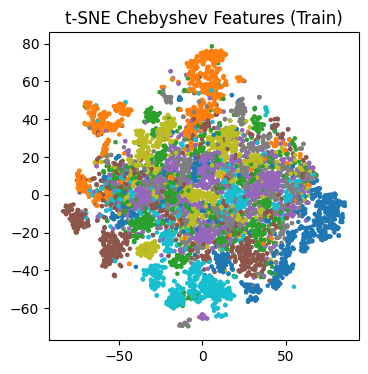

Cheb-only LR acc  Train/Val/Test: 0.9323529411764706 0.8966666666666666 0.9025
Cheb-only MLP acc Train/Val/Test: 1.0 0.8916666666666667 0.8915
Combined LR acc     Train/Val/Test: 0.9541176470588235 0.915 0.917
Combined MLP acc    Train/Val/Test: 1.0 0.9216666666666666 0.92


In [6]:
import math
import random
import time
import warnings

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import laplacian
from numpy.linalg import norm
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist

#  Configuration
SEED = 42
DOWN_SAMPLE_SIZE = 8
TOTAL_SAMPLES = 8000
TEST_SET_SIZE = 2000
VALIDATION_SIZE = 1200
HYBRID_EPOCHS = 20
BATCH_SIZE = 128
LR_RATE = 1e-3
RADIUS_MIN = 1e-3  # for stability

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# Differentiable Shells Module
class DifferentiableShells(nn.Module):
    def __init__(self, num_shells, feature_dim, init_radii=None, tau=0.1):
        super().__init__()
        if init_radii is None:
            init = torch.linspace(1.0, num_shells * 1.0, steps=num_shells)
        else:
            init = torch.tensor(init_radii, dtype=torch.float32)
        self.radii = nn.Parameter(init)
        self.tau = tau
        self.feature_dim = feature_dim
        self.register_buffer('orbit_counts', torch.zeros(num_shells, feature_dim))

    def forward(self, Z):
        phi = Z.mean(dim=0, keepdim=True)
        dist = torch.norm(Z - phi, dim=1, keepdim=True)
        diff_sq = (dist - self.radii.view(1, -1)) ** 2
        weights = F.softmax(-diff_sq / self.tau, dim=1)
        self.orbit_counts += weights.t().matmul(Z).detach()
        return weights, phi

#  φ-Resonance Autoencoder
class PhiResonanceAE(nn.Module):
    def __init__(self, input_dim, latent_dim, num_shells, tau=0.1):
        super().__init__()
        self.enc = nn.Sequential(nn.Linear(input_dim, 512), nn.ReLU(), nn.Linear(512, latent_dim))
        self.dec = nn.Sequential(nn.Linear(latent_dim, 512), nn.ReLU(), nn.Linear(512, input_dim), nn.Sigmoid())
        self.shells = DifferentiableShells(num_shells, latent_dim, tau=tau)

    def forward(self, x):
        z = self.enc(x)
        soft_w, phi = self.shells(z)
        delta = z - phi
        normed = delta / (delta.norm(dim=1, keepdim=True) + 1e-12)
        r = self.shells.radii.view(1, -1, 1)
        z_collapsed = phi.view(1,1,-1) + normed.unsqueeze(1) * r
        z_new = (soft_w.unsqueeze(-1) * z_collapsed).sum(dim=1)
        x_rec = self.dec(z_new)
        return x_rec, z, z_new, soft_w, phi

    def loss(self, x, x_rec, z, z_new, soft_w, phi):
        rec_loss = F.mse_loss(x_rec, x)
        expected_radii = (soft_w * self.shells.radii).sum(dim=1)
        actual_radii = torch.norm(z_new - phi, dim=1)
        shell_consistency = F.mse_loss(actual_radii, expected_radii)
        shell_entropy = -(soft_w * torch.log(soft_w + 1e-12)).sum(dim=1).mean()
        return rec_loss + 0.1 * shell_consistency + 0.01 * shell_entropy

# Chebyshev on φ-Graph
class PhiChebyshev(nn.Module):
    def __init__(self, num_basis, max_deg, knn_k):
        super().__init__()
        self.num_basis = num_basis
        self.max_deg = max_deg
        self.knn_k = knn_k
        self.scaler = None
        self.train_feats = None
        self.Z_train_latent = None

    def fit(self, Z):
        A = kneighbors_graph(Z.detach().cpu().numpy(), self.knn_k, mode='connectivity', include_self=False)
        A = csr_matrix(A.maximum(A.T))
        L = laplacian(A, normed=True)
        I = csr_matrix(np.eye(L.shape[0]))
        L_scaled = L - I
        n = L_scaled.shape[0]
        R = min(self.num_basis, n)
        Q, _ = np.linalg.qr(np.random.randn(n, R))
        bases = [Q]
        for k in range(1, self.max_deg):
            T_k = 2 * L_scaled.dot(bases[-1]) - (bases[-2] if k>1 else 0)
            for B in bases:
                proj = T_k.T @ B
                T_k = T_k - B @ proj
            norms = np.linalg.norm(T_k, axis=0, keepdims=True)
            T_k = T_k / (norms + 1e-12)
            bases.append(T_k)
        feats = np.hstack(bases)
        self.Z_train_latent = Z.detach().cpu().numpy()
        self.train_feats = StandardScaler().fit_transform(feats)
        return self

    def transform(self, Z_new):
        from scipy.spatial.distance import cdist
        dists = cdist(Z_new.detach().cpu().numpy(), self.Z_train_latent)
        nbrs = np.argsort(dists, axis=1)[:, :self.knn_k]
        dists_n = dists[np.arange(len(Z_new))[:,None], nbrs]
        ws = 1/(1 + dists_n)
        ws = ws / ws.sum(axis=1, keepdims=True)
        neigh = self.train_feats[nbrs]
        return (ws[:,:,None] * neigh).sum(axis=1)

# Training Pipeline
def main():
    (Xtr, ytr), (Xte, yte) = mnist.load_data()
    data = np.vstack([Xtr, Xte]).reshape(-1, 28*28) / 255.
    labels = np.hstack([ytr, yte])
    mask = labels < 8
    X_raw, y = data[mask], labels[mask]
    X = torch.tensor(X_raw, dtype=torch.float32)
    X_img = X.view(-1, 1, 28, 28)
    X_ds = F.interpolate(X_img, size=DOWN_SAMPLE_SIZE, mode='bilinear', align_corners=False)
    X = X_ds.view(-1, DOWN_SAMPLE_SIZE**2)
    ss = StratifiedShuffleSplit(n_splits=1, train_size=TOTAL_SAMPLES, test_size=TEST_SET_SIZE, random_state=SEED)
    trval, tst = next(ss.split(X, y))
    X_tv, y_tv = X[trval], y[trval]
    X_t, y_t = X[tst], y[tst]
    X_tr, X_val, y_tr, y_val = train_test_split(X_tv, y_tv, test_size=VALIDATION_SIZE, stratify=y_tv, random_state=SEED)

    ae = PhiResonanceAE(DOWN_SAMPLE_SIZE**2, 64, num_shells=5).to('cpu')
    opt = torch.optim.Adam(ae.parameters(), lr=LR_RATE)
    loader = DataLoader(TensorDataset(X_tr), batch_size=BATCH_SIZE, shuffle=True)
    for _ in range(HYBRID_EPOCHS):
        ae.train()
        for batch_x, in loader:
            rec, z, zn, w, phi = ae(batch_x)
            loss = ae.loss(batch_x, rec, z, zn, w, phi)
            opt.zero_grad(); loss.backward(); opt.step()
            ae.shells.radii.data.clamp_(min=RADIUS_MIN)

    ae.eval()
    with torch.no_grad():
        _, Ztr_raw, Ztr, _, _ = ae(X_tr)
        _, Zval_raw, Zval, _, _ = ae(X_val)
        _, Ztst_raw, Ztst, _, _ = ae(X_t)

    # t-SNE on Chebyshev training features
    cheb = PhiChebyshev(num_basis=16, max_deg=10, knn_k=30).fit(Ztr)
    F_tr = cheb.train_feats
    tsne_emb = TSNE(n_components=2, random_state=SEED).fit_transform(F_tr)
    plt.figure(figsize=(4,4))
    plt.scatter(tsne_emb[:,0], tsne_emb[:,1], c=y_tr, cmap='tab10', s=5)
    plt.title("t-SNE Chebyshev Features (Train)")
    plt.show()

    F_val = cheb.transform(Zval)
    F_tst = cheb.transform(Ztst)

    # Cheb-only classifiers
    lr_cheb = LogisticRegression(max_iter=2000).fit(F_tr, y_tr)
    print("Cheb-only LR acc  Train/Val/Test:",
          lr_cheb.score(F_tr, y_tr), lr_cheb.score(F_val, y_val), lr_cheb.score(F_tst, y_t))
    mlp_cheb = MLPClassifier(max_iter=500).fit(F_tr, y_tr)
    print("Cheb-only MLP acc Train/Val/Test:",
          mlp_cheb.score(F_tr, y_tr), mlp_cheb.score(F_val, y_val), mlp_cheb.score(F_tst, y_t))

    # Combined features
    Ztr_cat = torch.cat([Ztr_raw, torch.tensor(F_tr)], dim=1).numpy()
    Zval_cat = torch.cat([Zval_raw, torch.tensor(F_val)], dim=1).numpy()
    Ztst_cat = torch.cat([Ztst_raw, torch.tensor(F_tst)], dim=1).numpy()

    lr = LogisticRegression(max_iter=2000).fit(Ztr_cat, y_tr)
    print("Combined LR acc     Train/Val/Test:",
          lr.score(Ztr_cat, y_tr), lr.score(Zval_cat, y_val), lr.score(Ztst_cat, y_t))

    mlp = MLPClassifier(max_iter=500).fit(Ztr_cat, y_tr)
    print("Combined MLP acc    Train/Val/Test:",
          mlp.score(Ztr_cat, y_tr), mlp.score(Zval_cat, y_val), mlp.score(Ztst_cat, y_t))

if __name__ == "__main__":
    main()


In [ ]:
import math
import random
import warnings

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.decomposition import PCA as skPCA
from sklearn.manifold import TSNE
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import laplacian
from heapq import heappush, heappop
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
import pandas as pd

# Configuration
SEED = 42
DOWNSAMPLE_SIZE = 8
TRAIN_SAMPLES = 8000
TEST_SAMPLES = 2000
VAL_SAMPLES = 1200
NUM_EPOCHS = 20
BATCH_SIZE = 128
LR_RATE = 1e-3
MIN_RADIUS = 1e-3
SHELL_OPTIONS = [3, 5, 7]
TEMP_OPTIONS = [0.25, 0.5, 1.0]
ENTROPY_OPTIONS = [0.05, 0.1, 0.2]
REPULSION_OPTIONS = [0.05, 0.1, 0.2]
RL_EPISODES = 30
RL_ALPHA = 0.1
RL_GAMMA = 0.9
RL_EPS = 0.2

# Set seeds
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# =================== Utilities ===================
def compute_pva(data, labels, num_shells):
    from sklearn.decomposition import PCA
    scores = []
    for k in range(num_shells):
        idx = np.where(labels == k)[0]
        if len(idx) > 1:
            pca = PCA(1).fit(data[idx])
            scores.append(float(pca.explained_variance_ratio_[0]))
        else:
            scores.append(0.0)
    return scores

# A* on adjacency
def astar(adj, start, goal, pos):
    open_set = []
    heappush(open_set, (0, start))
    g = {n: float('inf') for n in adj}
    g[start] = 0
    f = {n: float('inf') for n in adj}
    def h(a, b): return np.linalg.norm(pos[a] - pos[b])
    f[start] = h(start, goal)
    while open_set:
        _, cur = heappop(open_set)
        if cur == goal: break
        for nbr in adj[cur]:
            cost = g[cur] + h(cur, nbr)
            if cost < g[nbr]:
                g[nbr] = cost
                f[nbr] = cost + h(nbr, goal)
                heappush(open_set, (f[nbr], nbr))
    return g.get(goal, float('inf'))

# =================== Models ===================
class DifferentiableShells(nn.Module):
    def __init__(self, n_shells, dim, tau):
        super().__init__()
        self.radii = nn.Parameter(torch.linspace(1, float(n_shells), steps=n_shells))
        self.tau = tau
    def forward(self, z):
        center = z.mean(0, keepdim=True)
        d = (z - center).norm(dim=1, keepdim=True)
        diff = (d - self.radii.view(1, -1))**2
        w = F.softmax(-diff / self.tau, dim=1)
        return w, center

class PhiAE(nn.Module):
    def __init__(self, inp_dim, lat_dim, n_shells, tau, ent_w, rep_w):
        super().__init__()
        self.enc = nn.Sequential(nn.Linear(inp_dim, 512), nn.ReLU(), nn.Linear(512, lat_dim))
        self.dec = nn.Sequential(nn.Linear(lat_dim, 512), nn.ReLU(), nn.Linear(512, inp_dim), nn.Sigmoid())
        self.shells = DifferentiableShells(n_shells, lat_dim, tau)
        self.ent_w, self.rep_w = ent_w, rep_w
    def forward(self, x):
        z = self.enc(x)
        w, c = self.shells(z)
        u = (z - c) / ((z - c).norm(dim=1, keepdim=True) + 1e-12)
        r = self.shells.radii.view(1, -1, 1)
        collapsed = c.view(1,1,-1) + u.unsqueeze(1) * r
        z_new = (w.unsqueeze(-1) * collapsed).sum(1)
        rec = self.dec(z_new)
        return rec, z, z_new, w, c
    def loss(self, x, rec, z, z_new, w, c):
        rec_loss = F.mse_loss(rec, x)
        d_pre = (z - c).norm(dim=1)
        exp_r = (w * self.shells.radii).sum(1)
        cons_loss = F.mse_loss(d_pre, exp_r)
        ent_loss = -(w * torch.log(w + 1e-12)).sum(1).mean()
        r = self.shells.radii; diff = r.view(-1,1) - r
        rep_loss = (1/(diff.pow(2)+1e-6)).triu(1).sum()
        return rec_loss + 0.1*cons_loss + self.ent_w*ent_loss + self.rep_w*rep_loss

class ChebFeatures:
    def __init__(self, K, deg, k): self.K, self.deg, self.k = K, deg, k
    def fit(self, Z):
        A = kneighbors_graph(Z, self.k, mode='connectivity', include_self=False)
        G = csr_matrix(A.maximum(A.T)); L = laplacian(G, normed=True)
        I = csr_matrix(np.eye(L.shape[0])); Ls = L - I
        n = Ls.shape[0]; R = min(self.K, n)
        Q, _ = np.linalg.qr(np.random.randn(n, R)); bases=[Q]
        for i in range(1, self.deg):
            T = 2*Ls.dot(bases[-1]) - (bases[-2] if i>1 else 0)
            for B in bases: T -= B@(T.T@B)
            bases.append(T/(np.linalg.norm(T,axis=0,keepdims=True)+1e-12))
        Fmat = np.hstack(bases)
        self.Z_train = Z; self.F_train = StandardScaler().fit_transform(Fmat)
        return self
    def transform(self, Z):
        from scipy.spatial.distance import cdist
        D = cdist(Z, self.Z_train)
        nbrs = np.argsort(D,axis=1)[:,:self.k]
        dsub = D[np.arange(len(Z))[:,None], nbrs]
        w = 1/(1+dsub); w/=w.sum(1,keepdims=True)
        return (w[:,:,None]*self.F_train[nbrs]).sum(1)

# PCA helper
def get_pca(Xtr, Xval, Xte, dim=30):
    pca = skPCA(dim).fit(Xtr)
    return pca.transform(Xtr), pca.transform(Xval), pca.transform(Xte)

# RL agent
class Agent:
    def __init__(self):
        self.Q = {};
        self.alpha, self.gamma, self.eps = RL_ALPHA, RL_GAMMA, RL_EPS
    def act(self, state):
        if random.random()<self.eps or state not in self.Q:
            return random.choice(SHELL_OPTIONS), random.choice(TEMP_OPTIONS), random.choice(ENTROPY_OPTIONS), random.choice(REPULSION_OPTIONS)
        return max(self.Q[state], key=self.Q[state].get)
    def update(self, s,a,r,s2):
        self.Q.setdefault(s, {}); self.Q[s].setdefault(a,0)
        best_next = max(self.Q.get(s2, {}).values() or [0])
        self.Q[s][a] += self.alpha*(r + self.gamma*best_next - self.Q[s][a])

# =================== Main ===================
def main():
    # Load and downsample
    (trX,trY),(teX,teY)=mnist.load_data()
    data = np.vstack([trX,teX]).reshape(-1,784)/255.0; labels=np.hstack([trY,teY])
    mask = labels<8; X=data[mask]; Y=labels[mask]
    imgs = torch.tensor(X, dtype=torch.float32).view(-1,1,28,28)
    small = F.interpolate(imgs, size=DOWNSAMPLE_SIZE, mode='bilinear', align_corners=False)
    flat = small.view(-1, DOWNSAMPLE_SIZE**2).numpy()

    # Split train/val and test
    splitter = StratifiedShuffleSplit(
        n_splits=1,
        train_size=TRAIN_SAMPLES,
        test_size=TEST_SAMPLES,
        random_state=SEED
    )
    trv, tst = next(splitter.split(flat, Y)); X_tv, y_tv = flat[trv], Y[trv]; X_test, y_test = flat[tst], Y[tst]
    # Split train/val to train & val
    X_train, X_val, y_train, y_val = train_test_split(
        X_tv, y_tv, test_size=VAL_SAMPLES, stratify=y_tv, random_state=SEED)

    # Convert to arrays for sklearn and tensors for PyTorch where needed
    X_train_t = torch.tensor(X_train, dtype=torch.float32)
    X_val_t = torch.tensor(X_val, dtype=torch.float32)
    X_test_t = torch.tensor(X_test, dtype=torch.float32)

    agent = Agent()
    best_acc, best_params = 0, None
    for ep in range(RL_EPISODES):
        shells, temp, ent_w, rep_w = agent.act('hp')
        model = PhiAE(DOWNSAMPLE_SIZE**2, 64, shells, temp, ent_w, rep_w)
        # init radii from X_train latent norms
        with torch.no_grad():
            z0 = model.enc(X_train_t)
            c0 = z0.mean(0,keepdim=True)
            d0 = (z0-c0).norm(dim=1).numpy()
            percs = np.linspace(100/shells,100,shells)
            model.shells.radii.data = torch.tensor(np.percentile(d0, percs), dtype=torch.float32)
        opt = torch.optim.Adam(model.parameters(), lr=LR_RATE)
        # train AE
        for _ in range(NUM_EPOCHS):
            for bx in DataLoader(TensorDataset(X_train_t), BATCH_SIZE, True):
                x_b = bx[0]
                rec, z, zn, w, c = model(x_b)
                loss = model.loss(x_b, rec, z, zn, w, c)
                opt.zero_grad(); loss.backward(); opt.step()
                model.shells.radii.data.clamp_(min=MIN_RADIUS)
        # eval on val
        model.eval()
        with torch.no_grad(): _, z_val, zn_val, w_val, _ = model(X_val_t)
        # downstream LR on combined
        p_tr, p_val, _ = get_pca(z_val.numpy(), z_val.numpy(), z_val.numpy())
        cheb = ChebFeatures(16,10,30).fit(zn_val.numpy())
        ch_val = cheb.transform(zn_val.numpy())
        combo = np.hstack([p_val, ch_val])
        acc = LogisticRegression(max_iter=2000).fit(combo, y_val).score(combo, y_val)
        agent.update('hp', (shells,temp,ent_w,rep_w), acc, 'hp')
        if acc>best_acc: best_acc, best_params = acc, (shells,temp,ent_w,rep_w)
    print("Best params:", best_params, "Val Acc:", best_acc)
    # Final model with best_params
    best_shells, best_temp, best_ent_w, best_rep_w = best_params
    final_model = PhiAE(
        DOWNSAMPLE_SIZE**2,
        64,
        best_shells,
        best_temp,
        best_ent_w,
        best_rep_w
    )
    # Initialize radii based on train latent norms
    with torch.no_grad():
        z_init = final_model.enc(X_train_t)
        c_init = z_init.mean(0, keepdim=True)
        d_init = (z_init - c_init).norm(dim=1).numpy()
        percentiles = np.linspace(100/best_shells, 100, best_shells)
        final_model.shells.radii.data = torch.tensor(np.percentile(d_init, percentiles), dtype=torch.float32)
    final_model.to('cpu')

    # Retrain final model with epoch-wise logging
    optimizer = torch.optim.Adam(final_model.parameters(), lr=LR_RATE)
    for epoch in range(NUM_EPOCHS):
        final_model.train()
        epoch_metrics = {'rec':0.0, 'cons':0.0, 'ent':0.0, 'rep':0.0}
        for bx, in DataLoader(TensorDataset(X_train_t), batch_size=BATCH_SIZE, shuffle=True):
            rec_b, z_b, zn_b, w_b, c_b = final_model(bx)
            rec_loss = F.mse_loss(rec_b, bx)
            d_pre_b = (z_b - c_b).norm(dim=1)
            exp_r_b = (w_b * final_model.shells.radii).sum(dim=1)
            cons_loss = F.mse_loss(d_pre_b, exp_r_b)
            ent_loss = -(w_b * torch.log(w_b + 1e-12)).sum(dim=1).mean()
            r = final_model.shells.radii; diff_mat = r.view(-1,1) - r
            rep_loss = (1/(diff_mat.pow(2) + 1e-6)).triu(1).sum()
            loss = rec_loss + 0.1*cons_loss + best_ent_w*ent_loss + best_rep_w*rep_loss
            optimizer.zero_grad(); loss.backward(); optimizer.step()
            final_model.shells.radii.data.clamp_(min=MIN_RADIUS)
            epoch_metrics['rec'] += rec_loss.item()
            epoch_metrics['cons'] += cons_loss.item()
            epoch_metrics['ent'] += ent_loss.item()
            epoch_metrics['rep'] += rep_loss.item()
        batches = len(DataLoader(TensorDataset(X_train_t), batch_size=BATCH_SIZE))
        print(f"Epoch {epoch+1:02d} | Recon={epoch_metrics['rec']/batches:.4f} | "
              f"Consist={epoch_metrics['cons']/batches:.4f} | Ent={epoch_metrics['ent']/batches:.4f} | "
              f"Repel={epoch_metrics['rep']/batches:.4f} | Tau={best_temp}")

    # Diagnostics: t-SNE & Accuracies
    final_model.eval()
    with torch.no_grad():
        _, lat_tr, con_tr, _, _ = final_model(X_train_t)
        _, lat_val, con_val, _, _ = final_model(X_val_t)
        _, lat_te, con_te, _, _ = final_model(X_test_t)

    # PCA-only
    pca_tr, pca_val, pca_te = get_pca(lat_tr.numpy(), lat_val.numpy(), lat_te.numpy())
    tsne_pca = TSNE(n_components=2, random_state=SEED).fit_transform(pca_tr)
    # Cheb-only
    cheb = ChebFeatures(16,10,30).fit(con_tr.numpy())
    cheb_tr = cheb.transform(con_tr.numpy())
    tsne_cheb = TSNE(n_components=2, random_state=SEED).fit_transform(cheb_tr)
    # Combined
    combined_tr = np.hstack([pca_tr, cheb_tr])
    tsne_comb = TSNE(n_components=2, random_state=SEED).fit_transform(combined_tr)

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].scatter(tsne_pca[:,0], tsne_pca[:,1], c=y_train, s=5)
    axes[0].set_title('t-SNE PCA-only')
    axes[1].scatter(tsne_cheb[:,0], tsne_cheb[:,1], c=y_train, s=5)
    axes[1].set_title('t-SNE Cheb-only')
    axes[2].scatter(tsne_comb[:,0], tsne_comb[:,1], c=y_train, s=5)
    axes[2].set_title('t-SNE Combined')
    plt.show()

    # Accuracy reporting for all cases
    lr_pca = LogisticRegression(max_iter=2000).fit(pca_tr, y_train)
    lr_cheb = LogisticRegression(max_iter=2000).fit(cheb_tr, y_train)
    lr_comb = LogisticRegression(max_iter=2000).fit(combined_tr, y_train)
    print('Accuracies:')
    print(f"PCA-only     Train/Val/Test: {lr_pca.score(pca_tr,y_train):.4f}/" \
          f"{lr_pca.score(pca_val,y_val):.4f}/{lr_pca.score(pca_te,y_test):.4f}")
    print(f"Cheb-only    Train/Val/Test: {lr_cheb.score(cheb_tr,y_train):.4f}/" \
          f"{lr_cheb.score(cheb.transform(con_val.numpy()),y_val):.4f}/" \
          f"{lr_cheb.score(cheb.transform(con_te.numpy()),y_test):.4f}")
    print(f"Combined     Train/Val/Test: {lr_comb.score(combined_tr,y_train):.4f}/" \
          f"{lr_comb.score(np.hstack([pca_val, cheb.transform(con_val.numpy())]),y_val):.4f}/" \
          f"{lr_comb.score(np.hstack([pca_te, cheb.transform(con_te.numpy())]),y_test):.4f}")

    # PVA on final contracted
    shell_labels = con_tr.norm(dim=1).cpu().numpy()
    shell_idx = np.argmin(np.abs(shell_labels[:,None] - final_model.shells.radii.detach().numpy()[None,:]), axis=1)
    pva_final = compute_pva(con_tr.numpy(), shell_idx, best_shells)
    print('Final PVA per shell:', pva_final)

if __name__ == '__main__':
    main()


Best params: (5, 0.25, 0.1, 0.1) Val Acc: 0.9616666666666667
Epoch 01 | Recon=0.0823 | Consist=0.1752 | Ent=1.3745 | Repel=1231.3564 | Tau=0.25
Epoch 02 | Recon=0.0535 | Consist=0.3867 | Ent=0.9156 | Repel=627.4245 | Tau=0.25
Epoch 03 | Recon=0.0420 | Consist=0.4762 | Ent=0.5250 | Repel=458.2391 | Tau=0.25
Epoch 04 | Recon=0.0318 | Consist=0.4369 | Ent=0.4328 | Repel=368.8283 | Tau=0.25
Epoch 05 | Recon=0.0244 | Consist=0.3986 | Ent=0.3832 | Repel=311.7210 | Tau=0.25
Epoch 06 | Recon=0.0188 | Consist=0.3665 | Ent=0.3465 | Repel=271.5263 | Tau=0.25
Epoch 07 | Recon=0.0153 | Consist=0.3372 | Ent=0.3160 | Repel=241.4444 | Tau=0.25
Epoch 08 | Recon=0.0126 | Consist=0.3105 | Ent=0.2921 | Repel=217.9480 | Tau=0.25
Epoch 09 | Recon=0.0105 | Consist=0.2866 | Ent=0.2714 | Repel=199.0061 | Tau=0.25
Epoch 10 | Recon=0.0089 | Consist=0.2657 | Ent=0.2542 | Repel=183.3595 | Tau=0.25
Epoch 11 | Recon=0.0075 | Consist=0.2483 | Ent=0.2369 | Repel=170.1813 | Tau=0.25
Epoch 12 | Recon=0.0066 | Consist=0.